In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

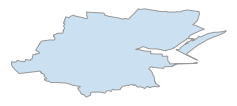

{'init': 'epsg:4326'}


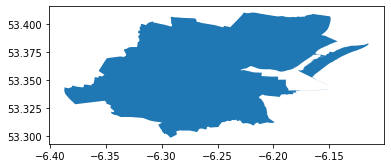

time: 426 ms


In [2]:
city = ox.gdf_from_place('Dublin, Ireland')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

5528
data max index: 5527
number of NA prices: 1
average bedroom price 83.62416634346047
pointinpoly length: 5031
check contains: True
check if there are NAs: True


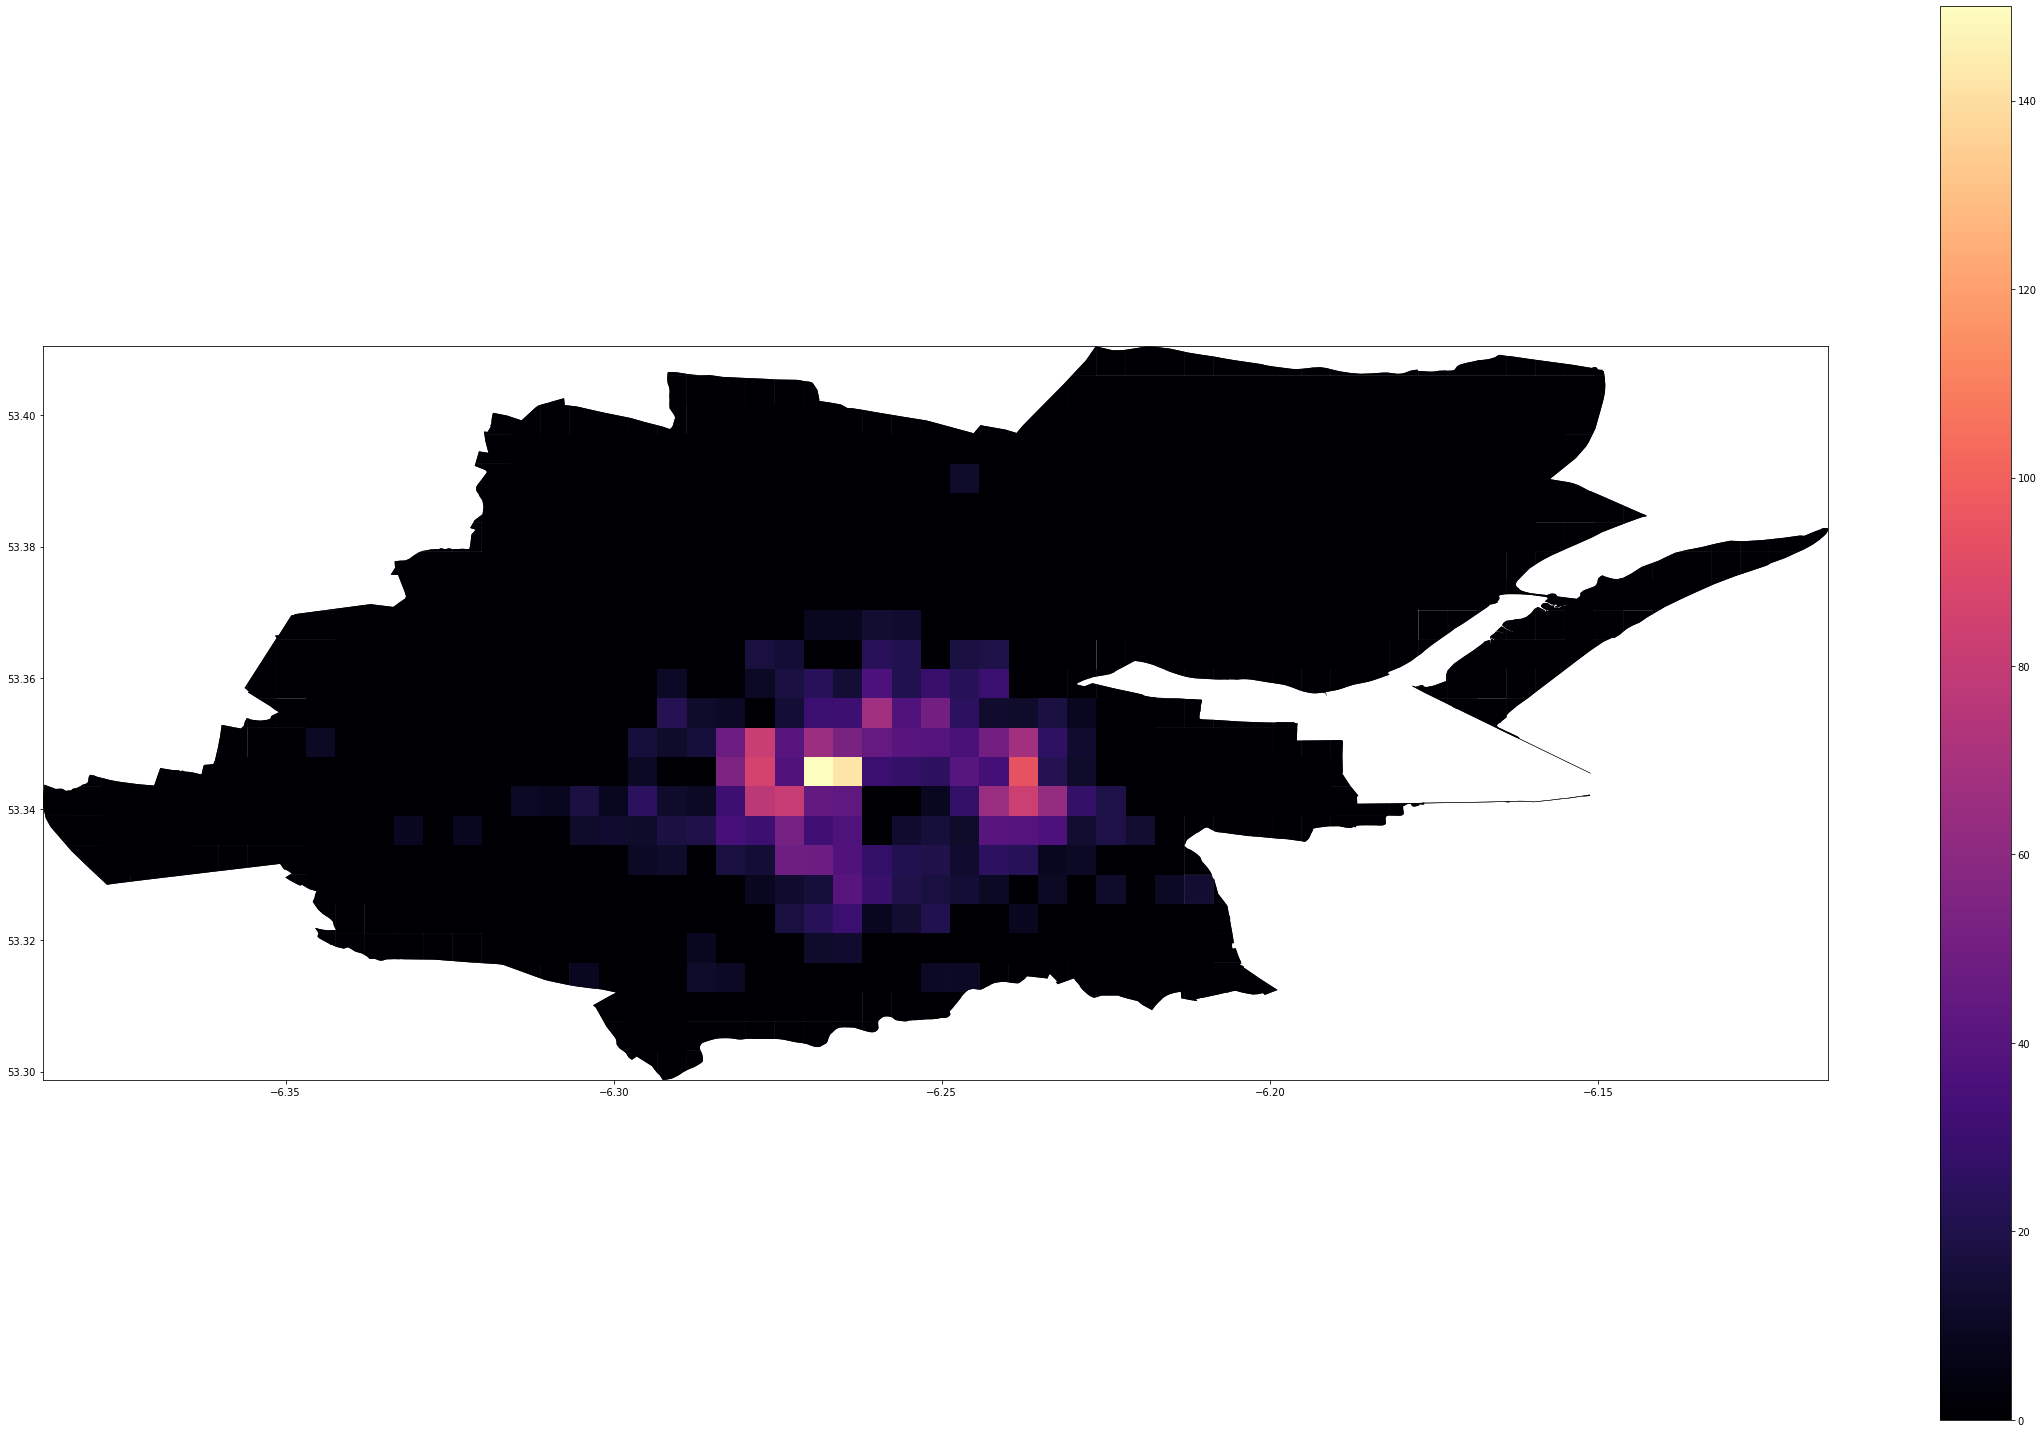

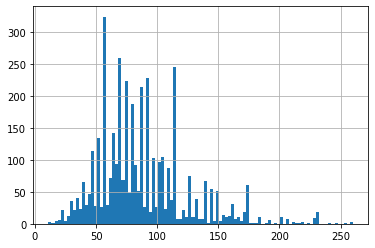

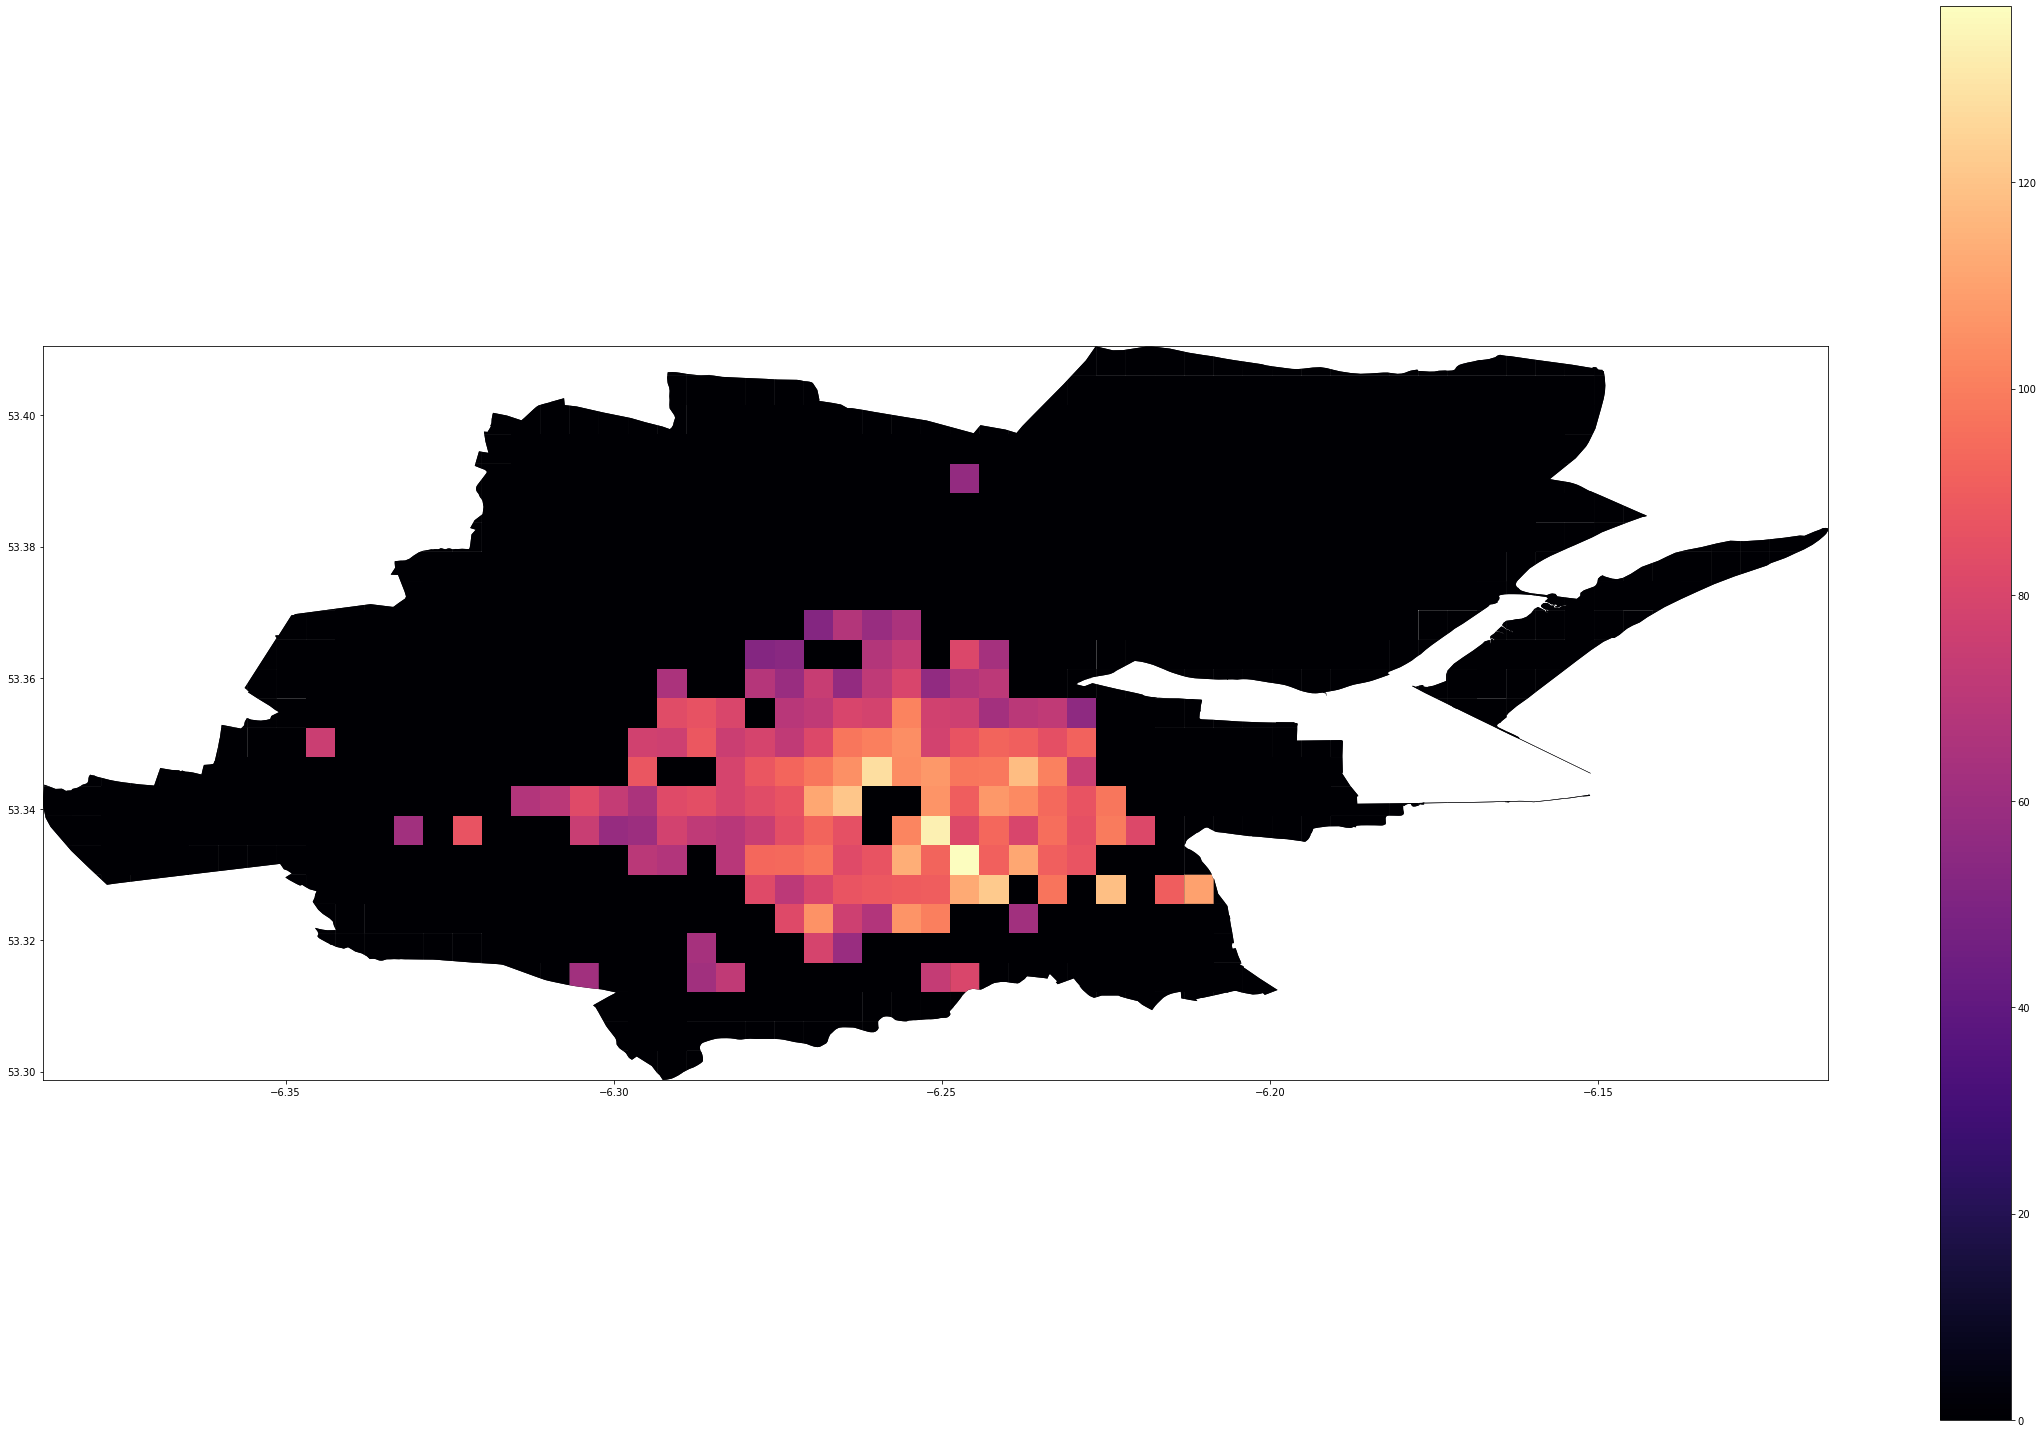

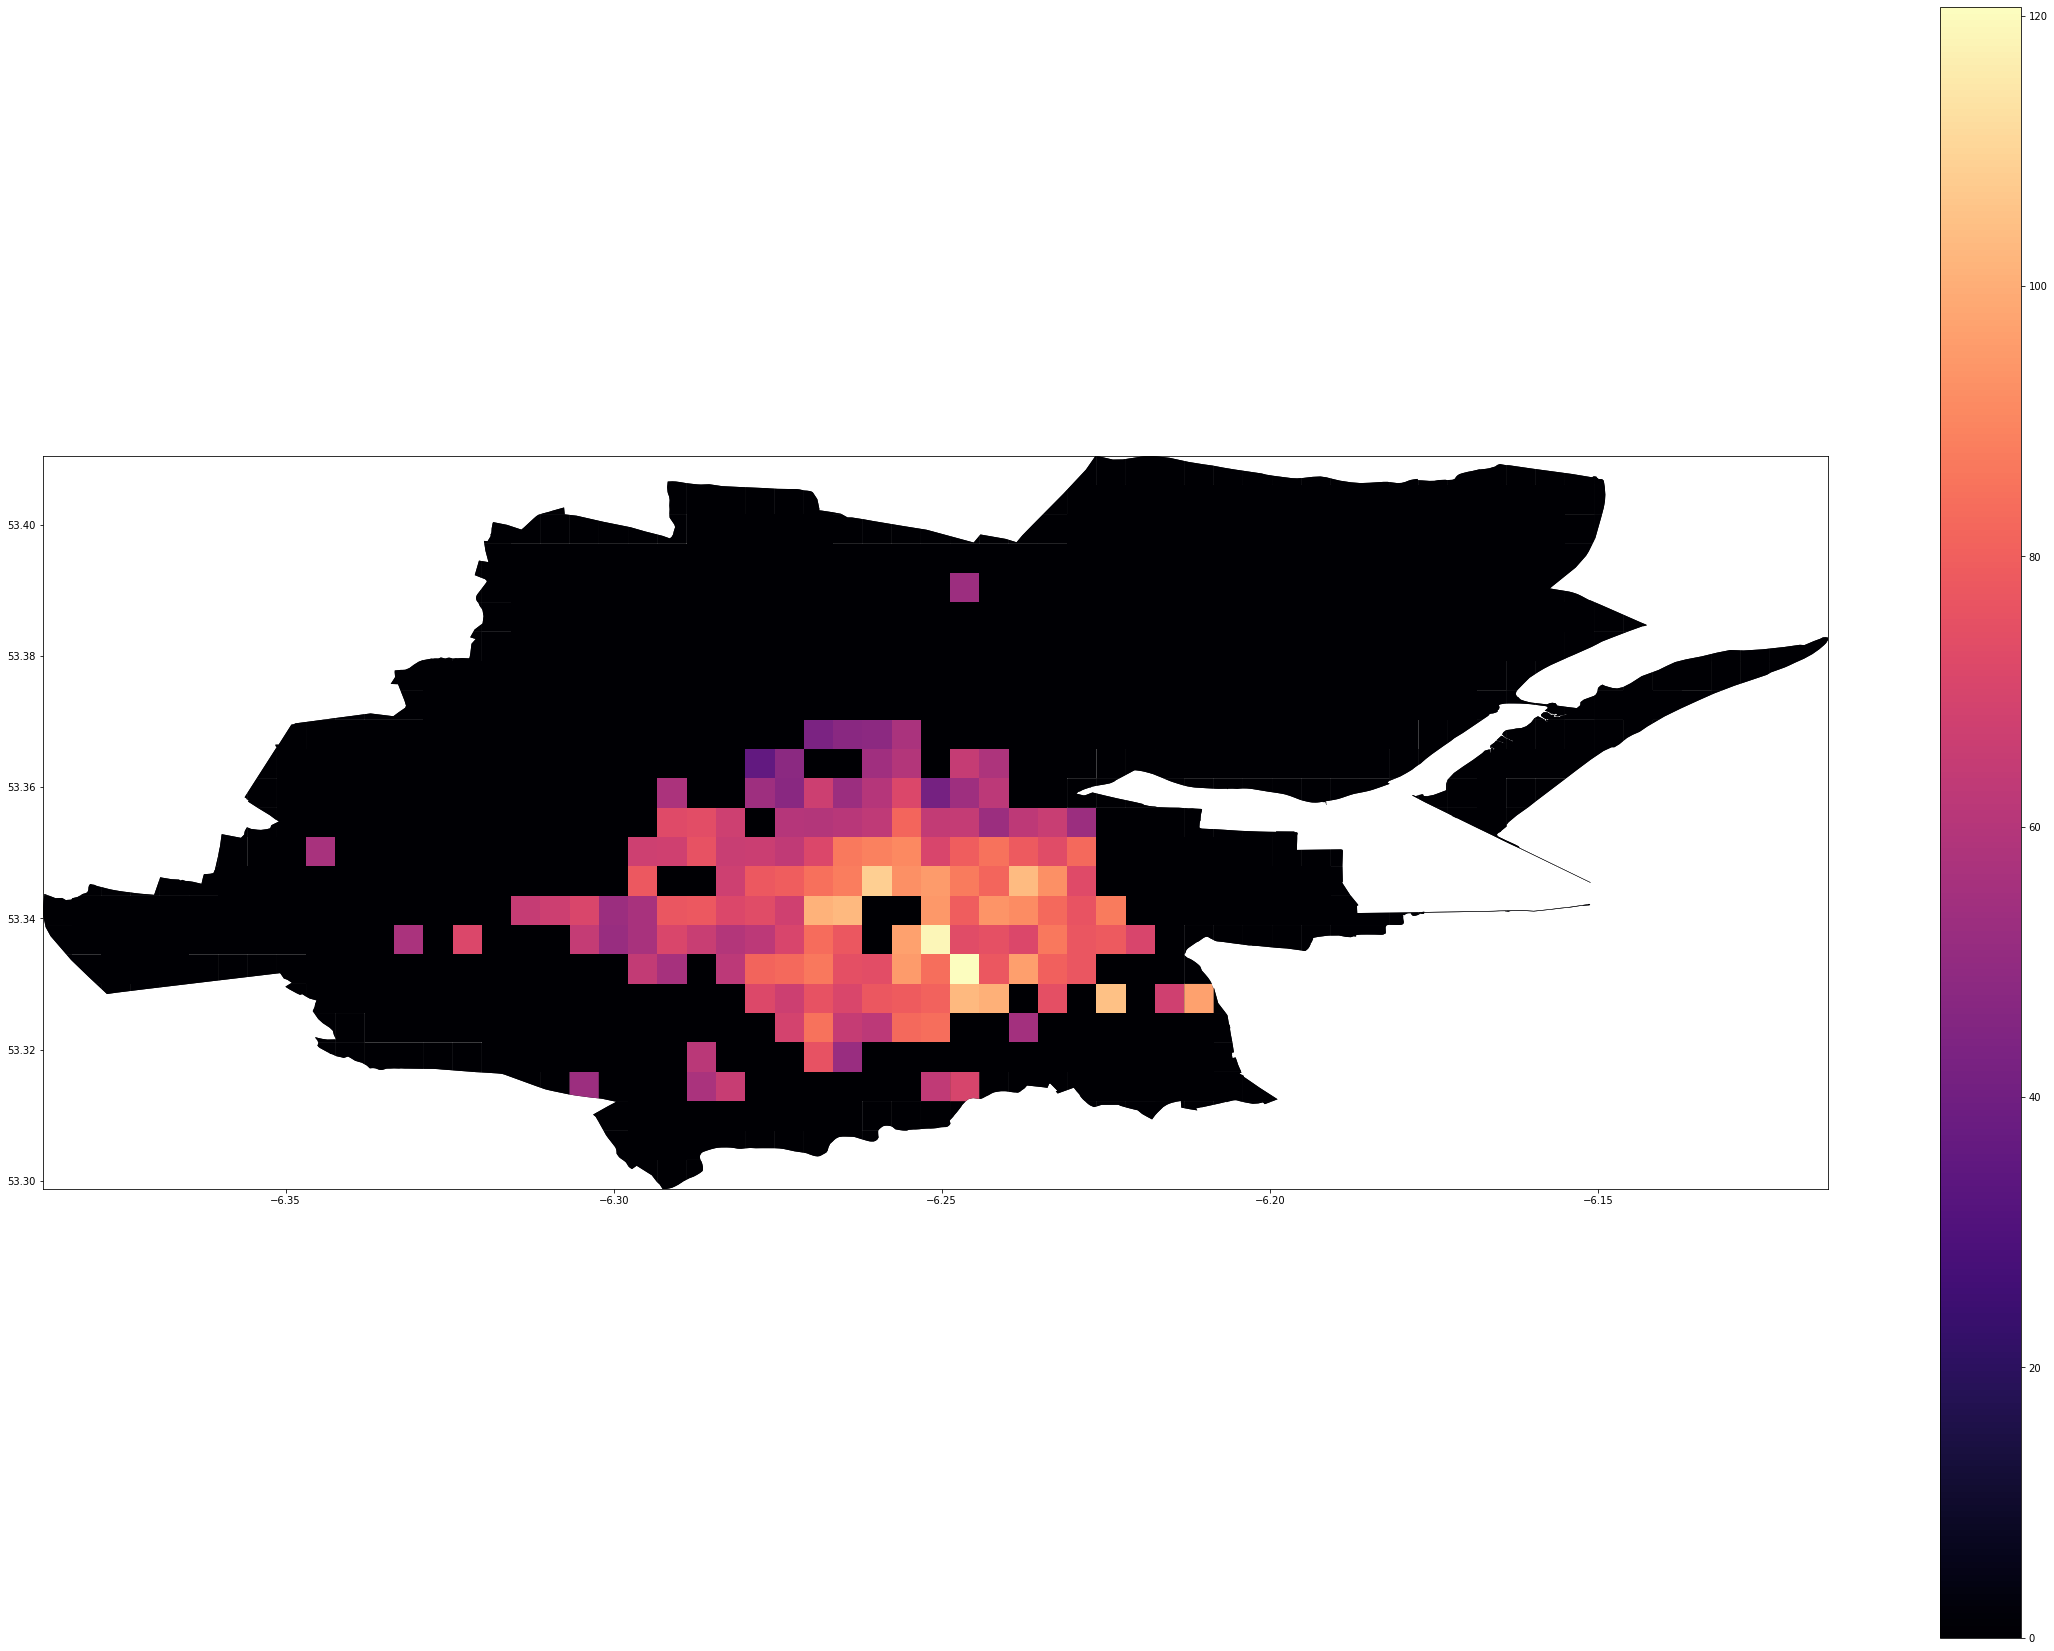

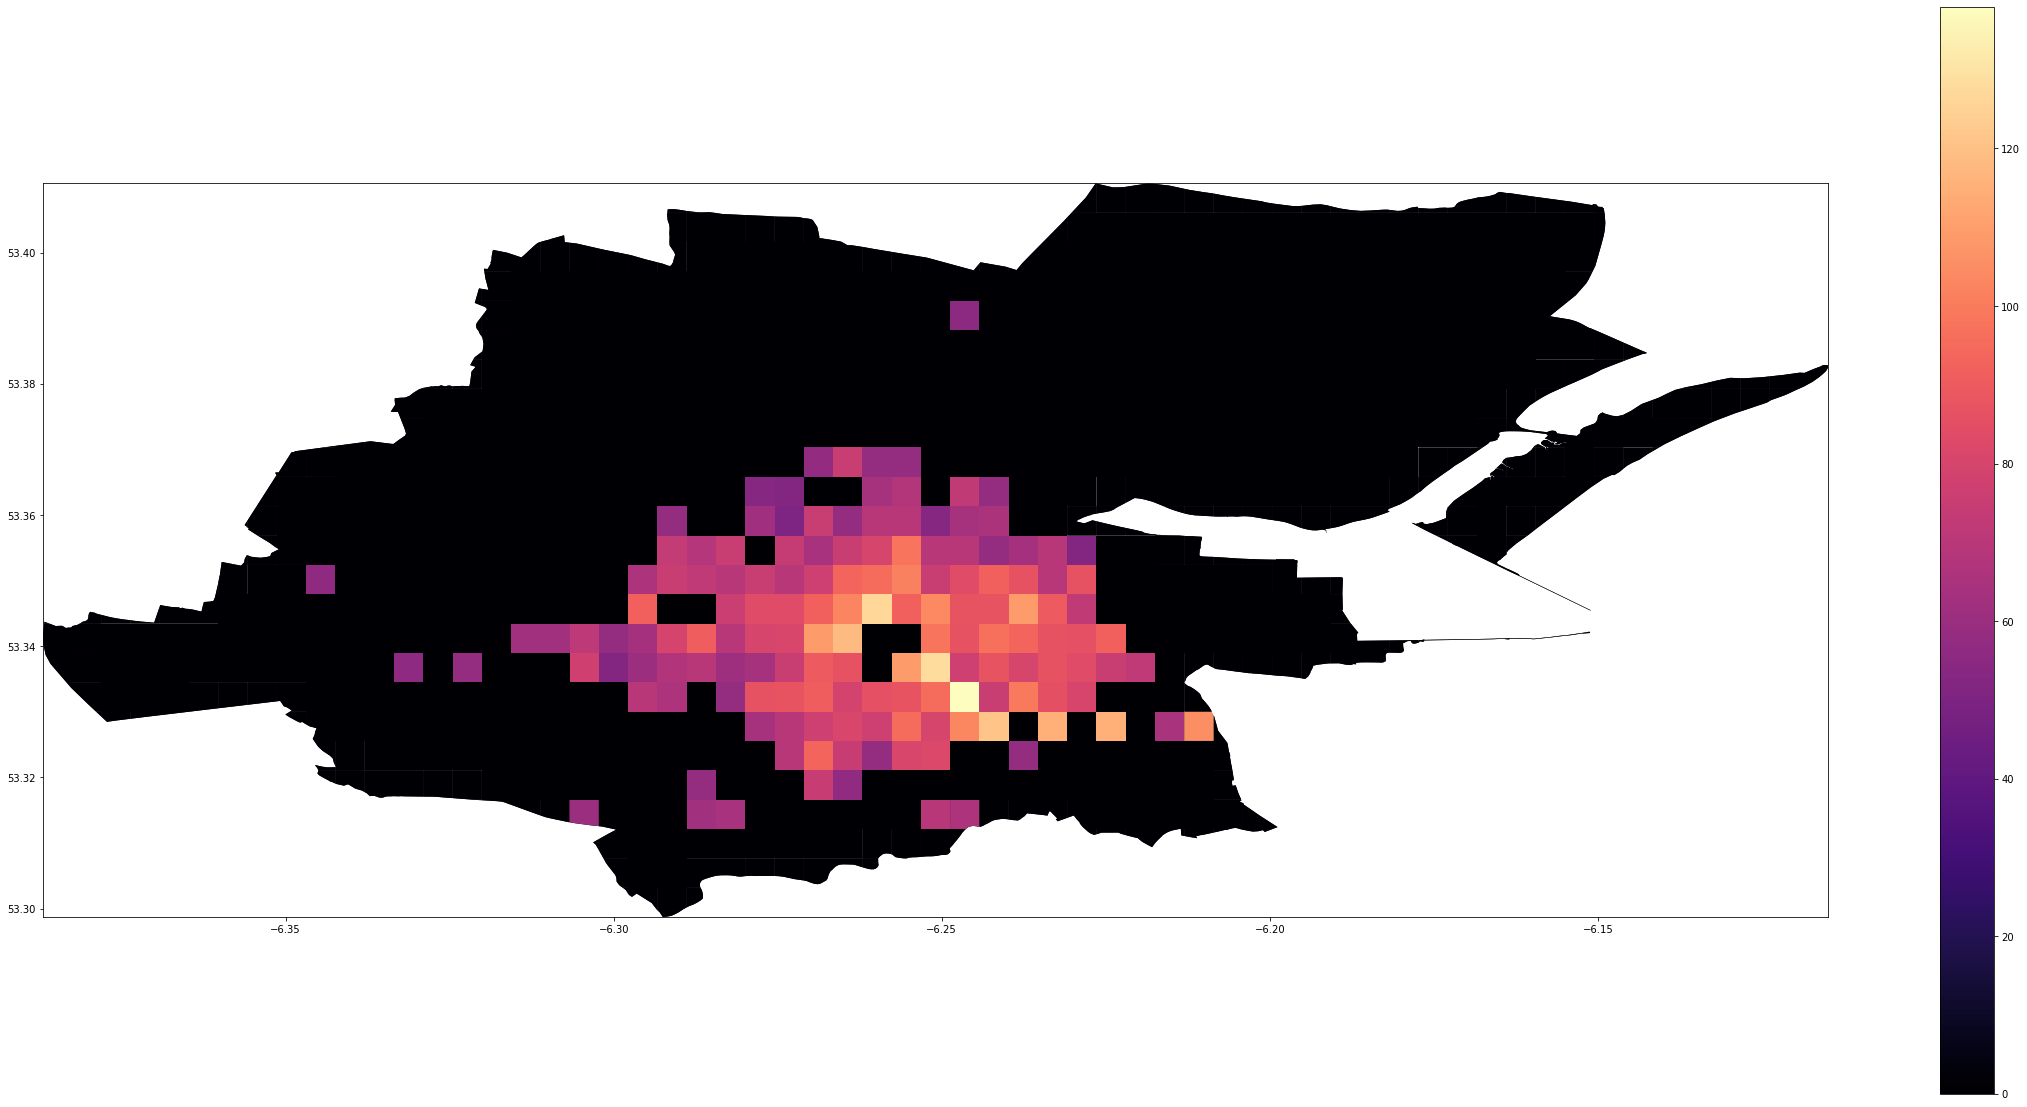

time: 7.38 s


In [3]:
data = pd.read_csv('data/Airbnb_Dublin.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>8]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


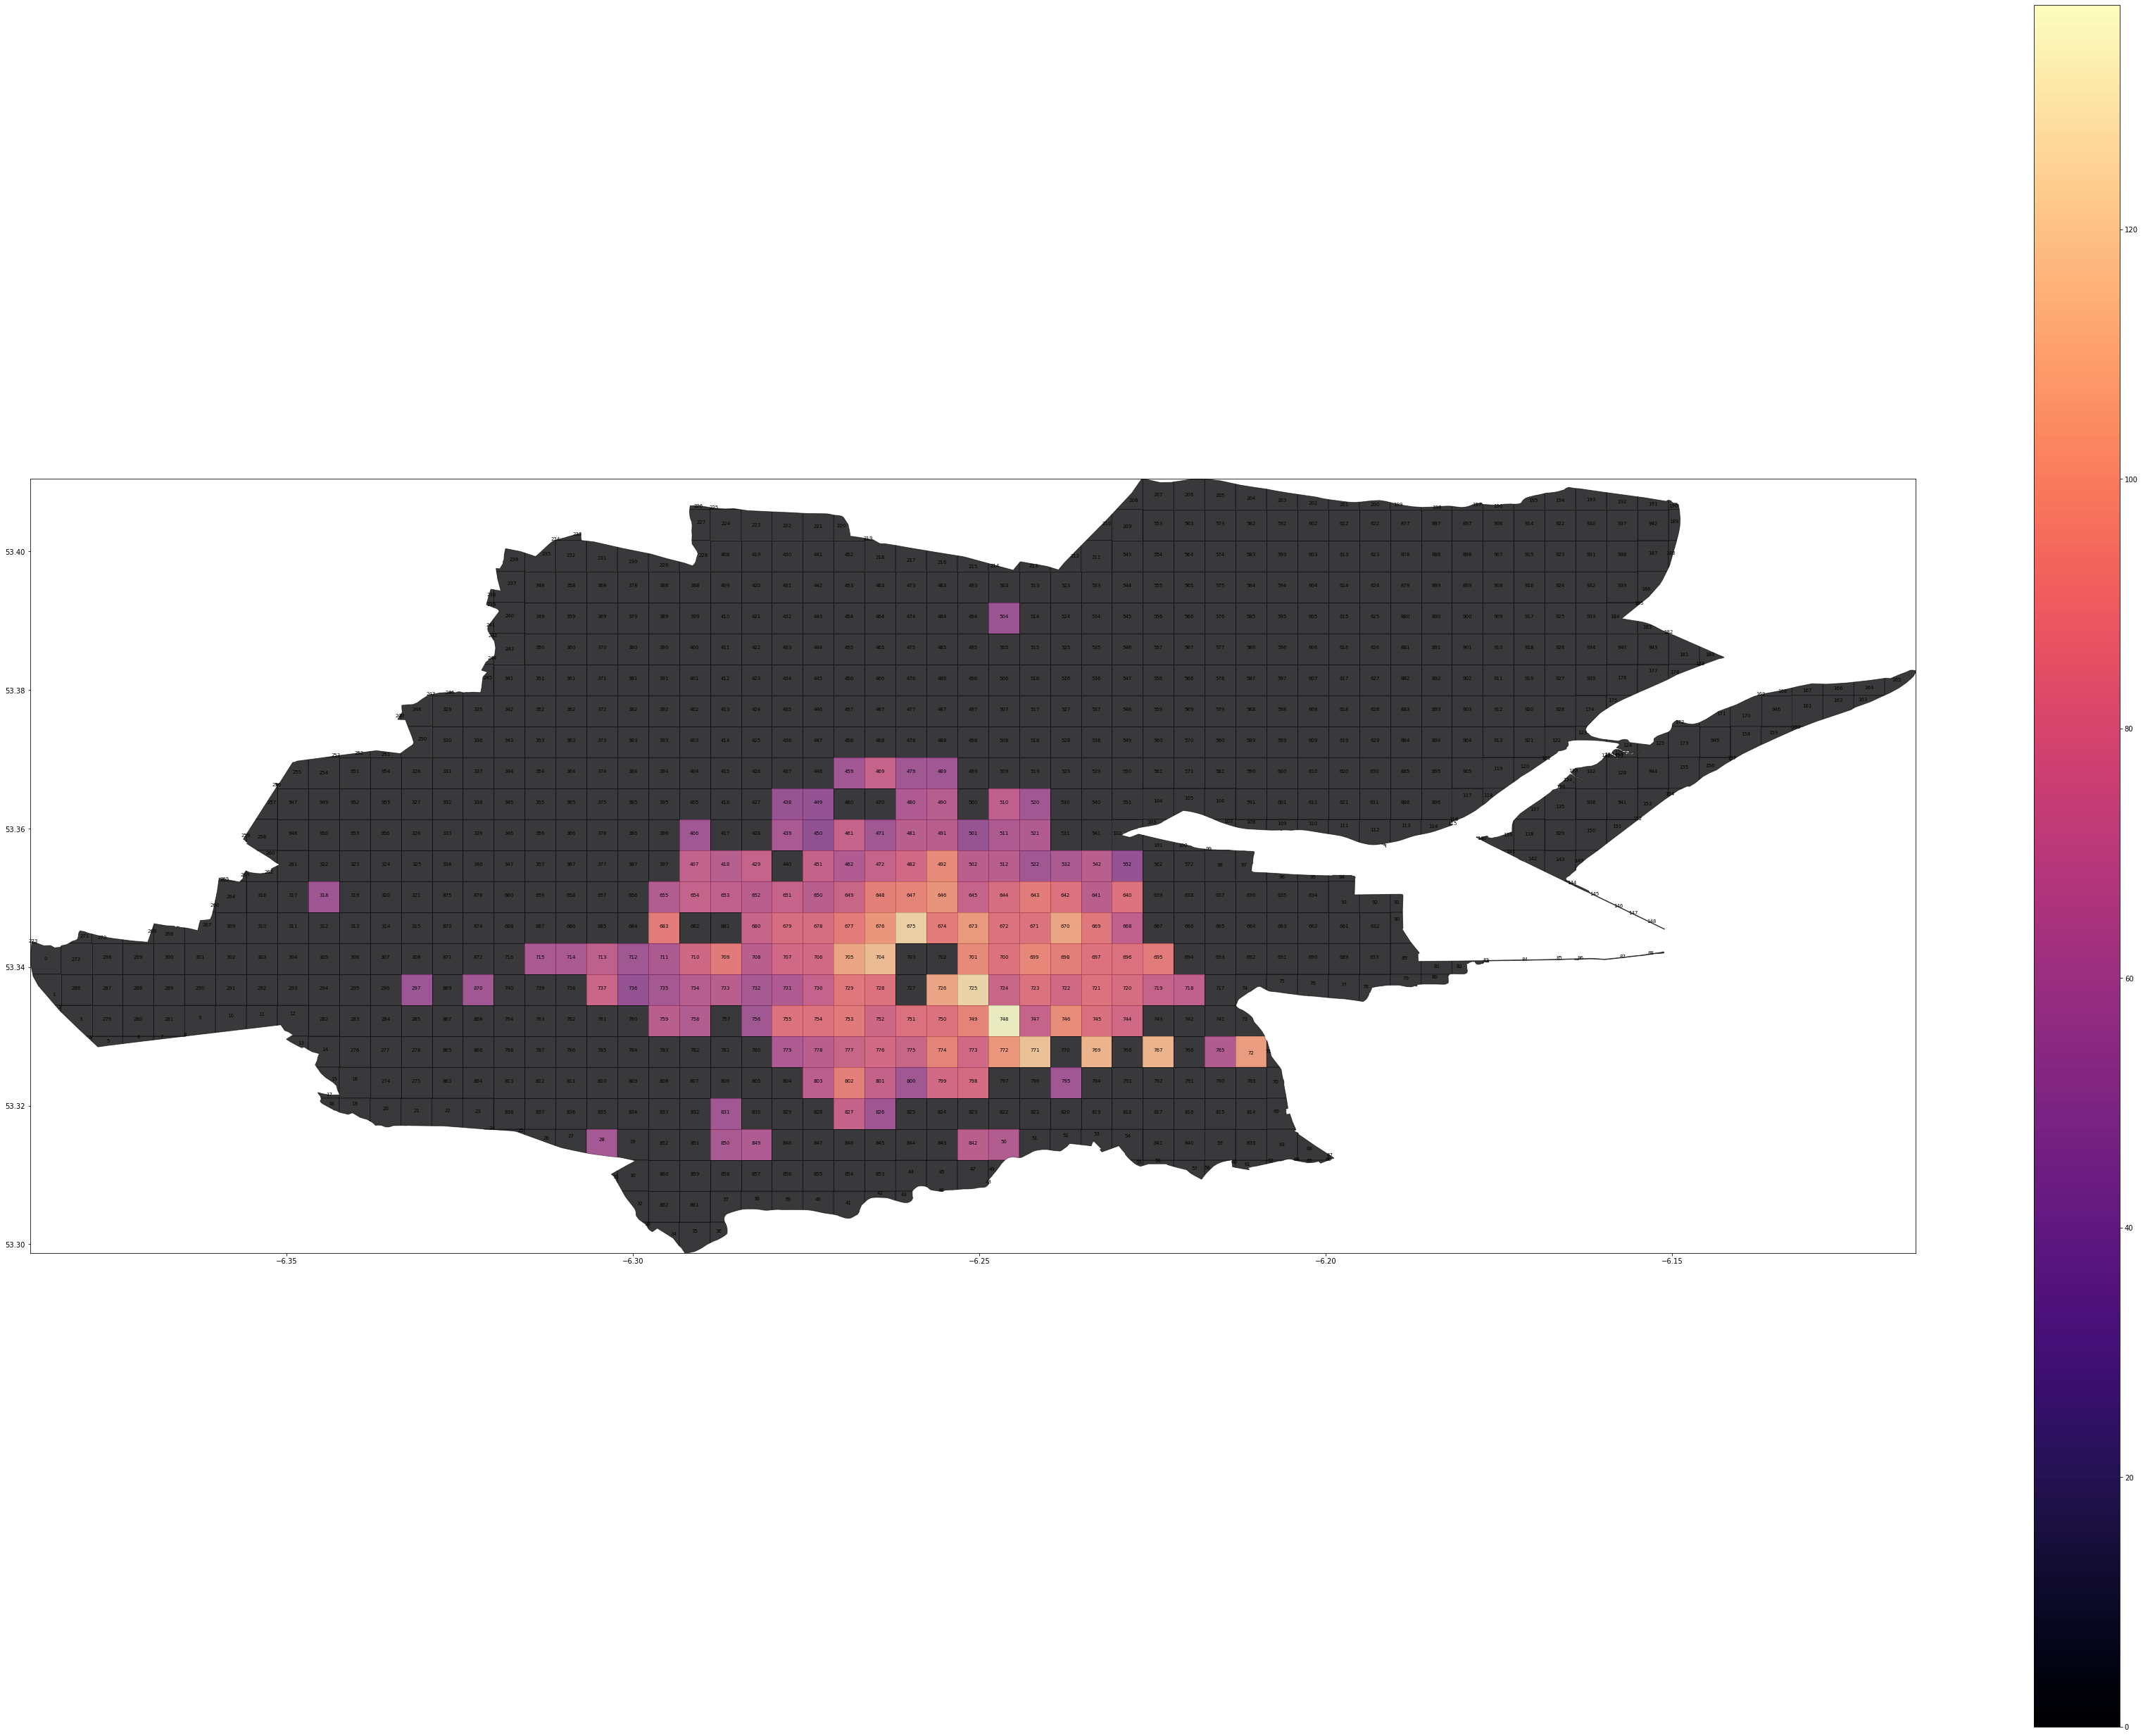

time: 10.4 s


In [4]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(60,45))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=7)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

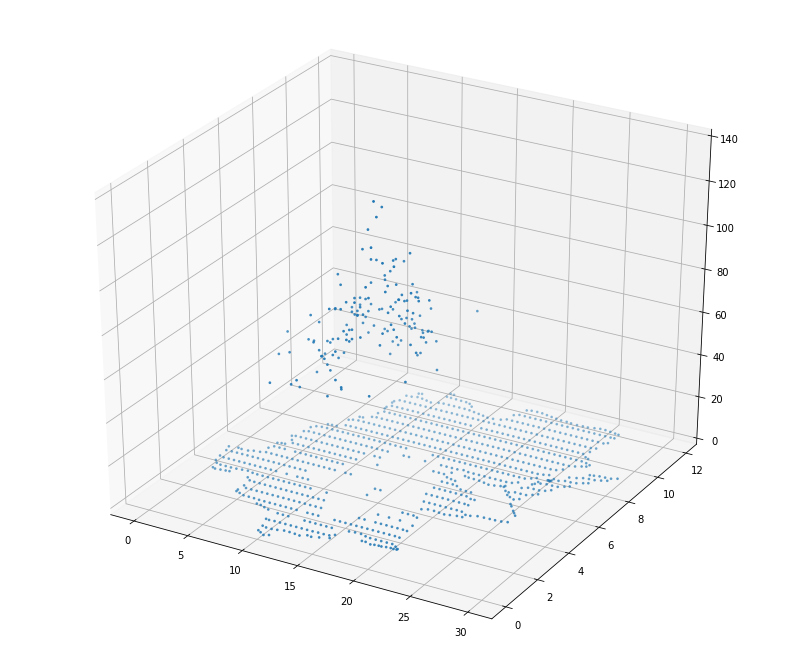

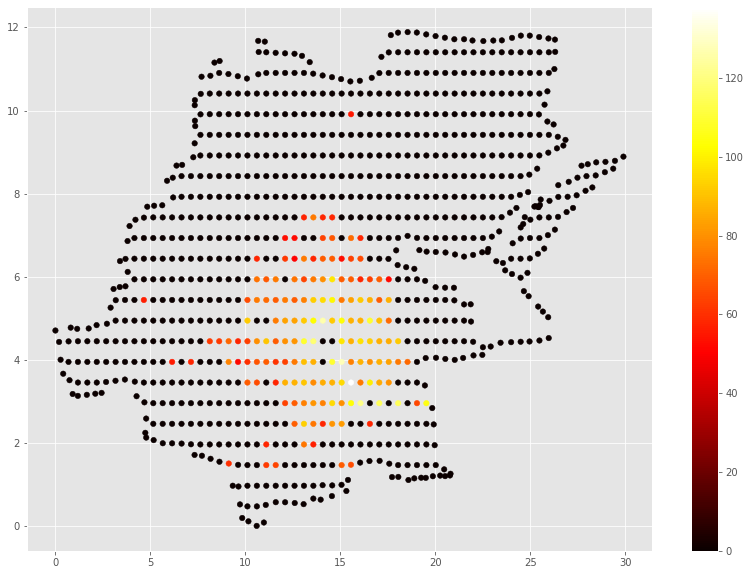

time: 2.32 s


In [5]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=30, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Dublin_observed.jpg')
plt.show()

In [6]:
cdf = polyair[polyair.index.isin([748, 675, 683])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
675  POLYGON ((-6.257646440988106 53.34792945599551...   -6.259877   
683  POLYGON ((-6.293337326234008 53.34792945599551...   -6.295568   
748  POLYGON ((-6.244262359020893 53.3345125679955,...   -6.246493   

     center_lat  count      prices  hmean_prices  median_prices  cen_lon_km  \
675   53.345693     30  127.948276    108.697058          126.5   14.074331   
683   53.345693     11   87.500000     78.206960           92.0   10.108359   
748   53.332276     13  137.057692    120.637007          138.0   15.561570   

     cen_lat_km  
675    4.942266  
683    4.942266  
748    3.451382

time: 265 ms


Fitted parameters:
[ 9.31885435e+01  1.42058963e+01  4.51974698e+00  1.72804087e+00
  3.13435273e+00  1.62935547e+00  2.07444318e+00 -1.58916467e+02
  1.58446614e+01  4.63723822e+00  2.04479957e+00  3.26928936e-02
  3.01824842e+00  1.98142445e+00]
RMS residual = 14.71995570401973


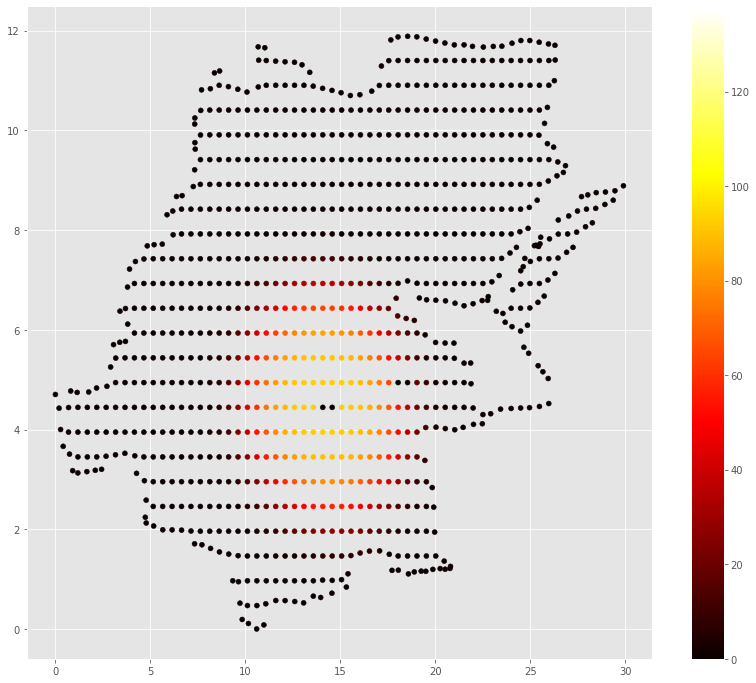

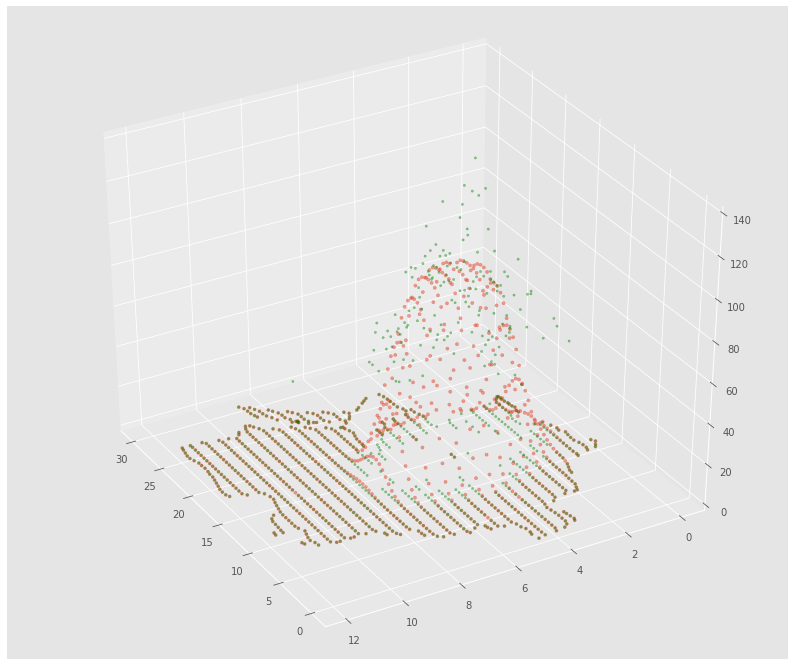

{'Dublin': 2.027933811822267}
time: 1.27 s


In [7]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr




guess_prms = [(126.5,14.074331,4.942266, 1.8, 1.6,1.58, 1.1),
              #(92,10.108359,4.942266, 1.2, 1.7,2.4, 1.8),
              (138,15.561570,3.451382, 1, 1.5,1.87, 0.7),
              #(65,15.598986,8.387698, 1, 1,0.87, 1.5),
              #(115.16,18.041651,9.867014, 0.5, 1,1.87, 1.1)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Dublin_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=10, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=5, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Dublin'] = np.mean(popt[6::7])
print(alphas)

In [8]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Dublin'] = alphas['Dublin']
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[105.37007313  14.52523939   5.21123395   1.15237558   2.41949997
   1.73006069  71.16293747  10.87307403   4.0134428    0.51418538
   1.92990678   1.7238393   82.45825399  14.91707605   3.01714399
   0.55227745   2.18132463   1.29467595]
RMS residual = 14.844806984201085


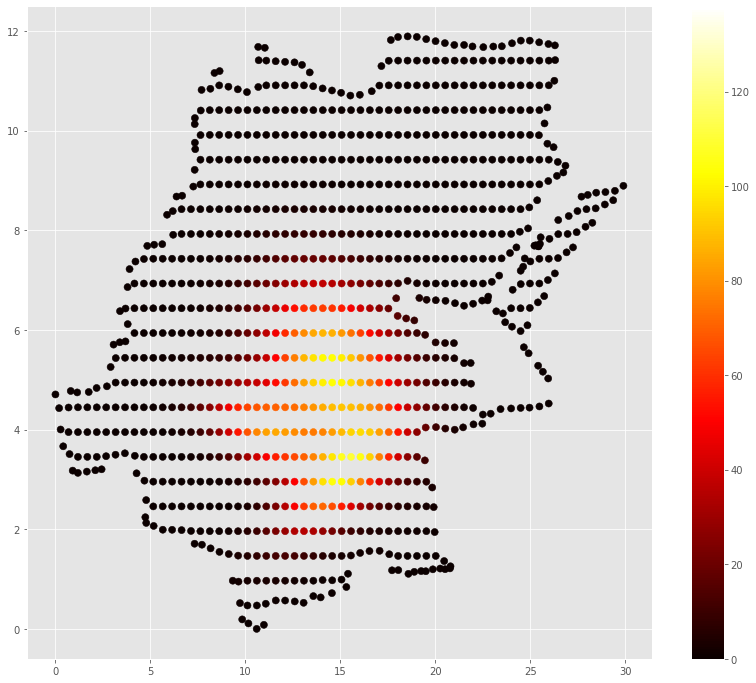

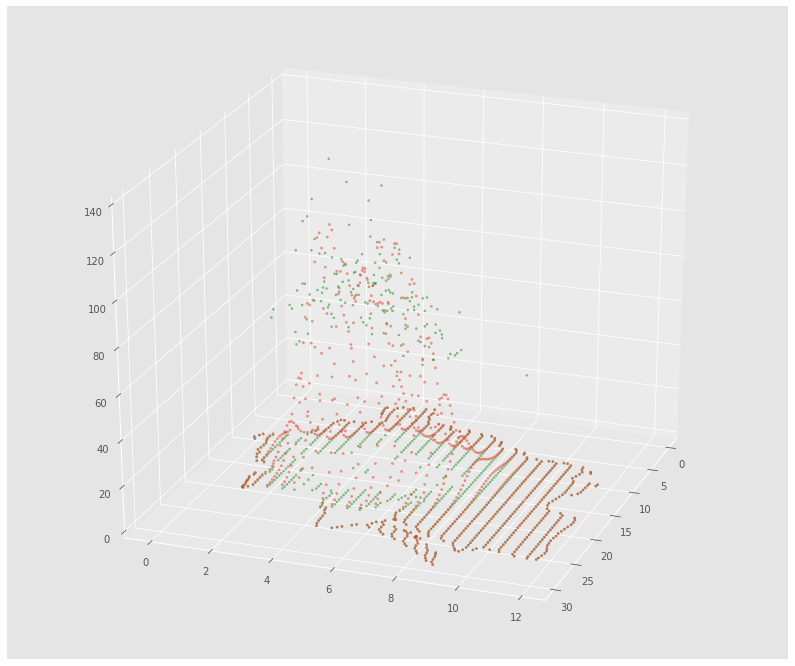

time: 1.2 s


In [9]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr



guess_prms = [(126.5,14.074331,4.942266, 1.8, 1.6,1.58),
              (92,10.108359,4.942266, 1.2, 1.7,2.4),
              (138,15.561570,3.451382, 1, 1.5,1.87),
              #(65,15.598986,8.387698, 1, 1,0.87, 1.5),
              #(115.16,18.041651,9.867014, 0.5, 1,1.87, 1.1)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=50, cmap='hot')
fig.colorbar(scat)
plt.savefig('Dublin_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=4, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 20)
plt.show()

In [10]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
Is cov_3 positive definite?:  True
long stds:  [0.00582336 0.01932464 0.01552721] mean:  0.013558405073941545
short stds:  [0.00277359 0.00514867 0.00393125] mean:  0.003951168359617085
time: 7.01 ms


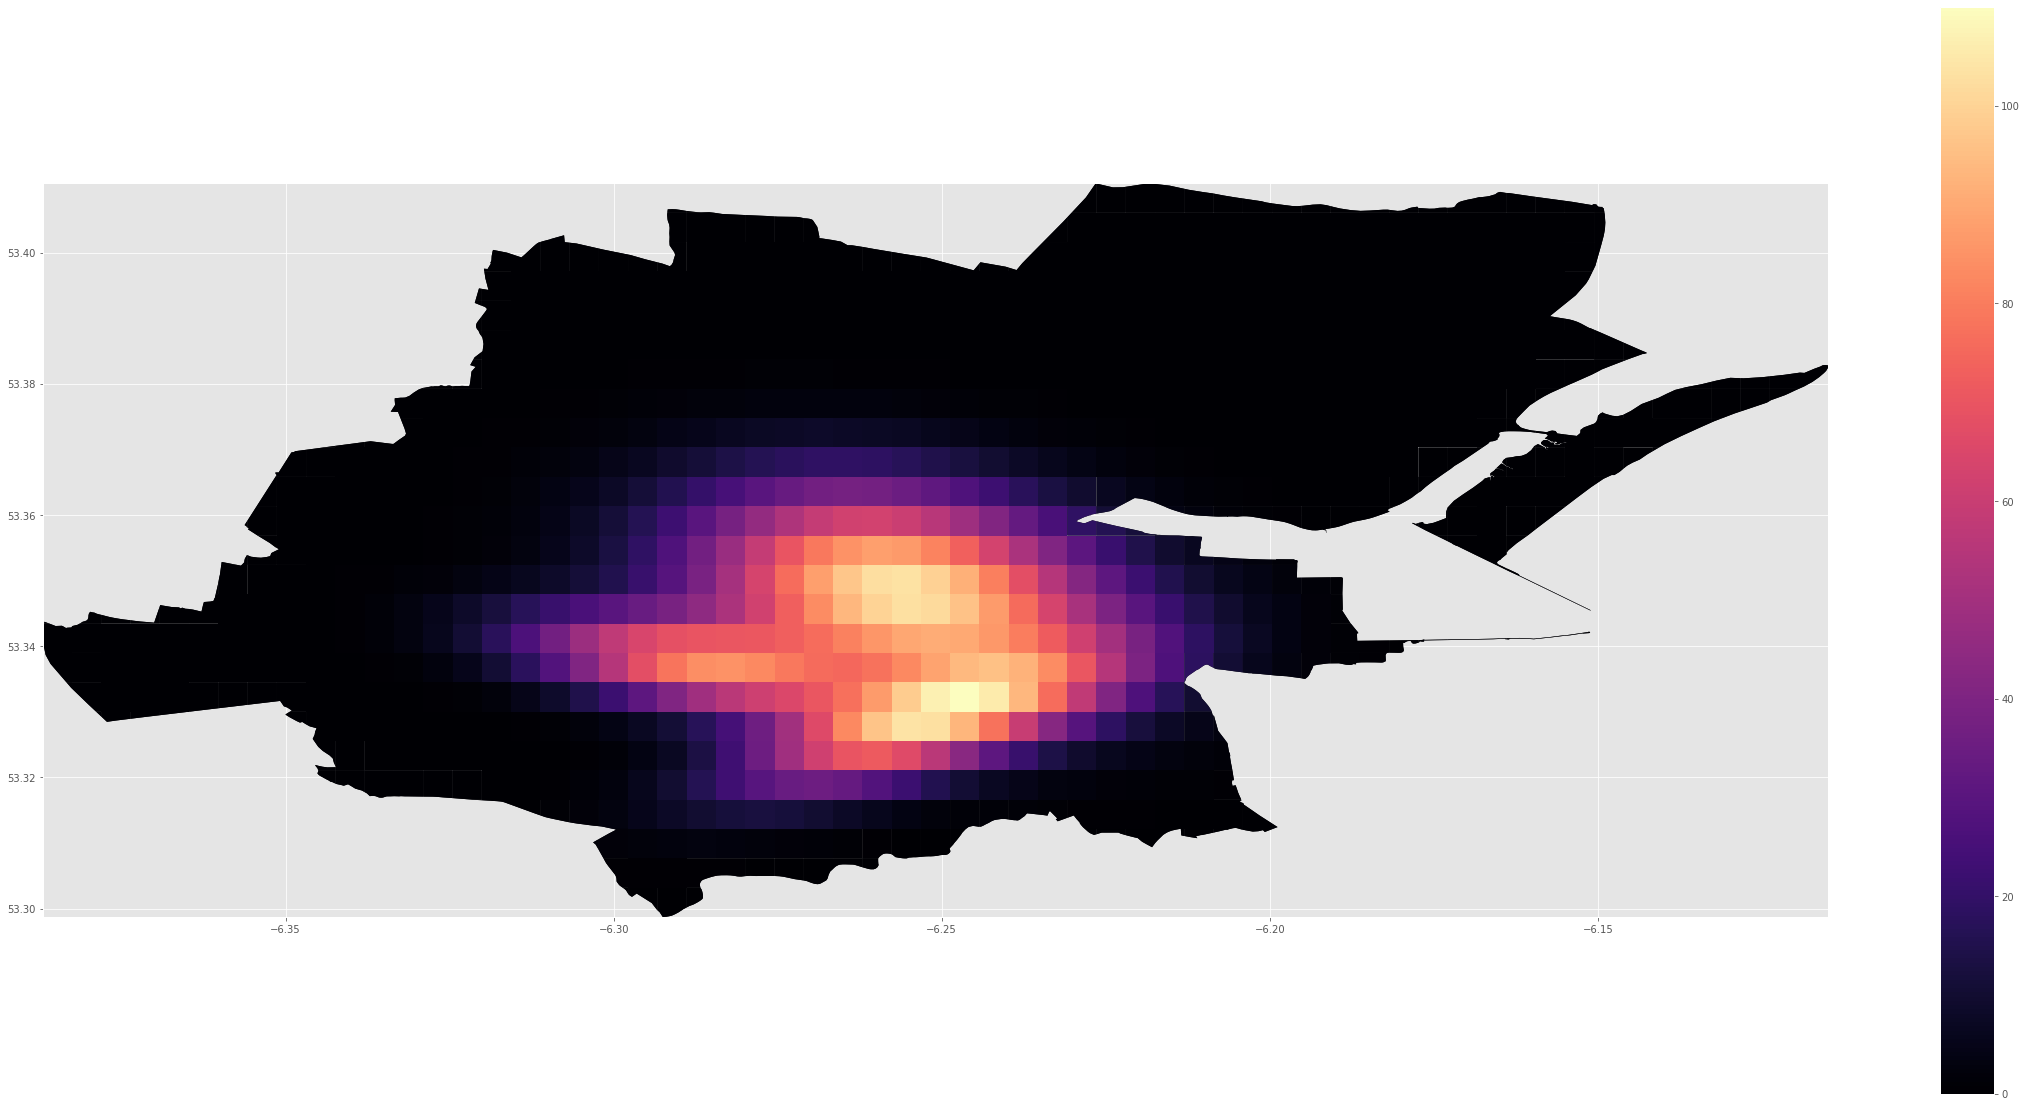

time: 1.27 s


In [11]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [12]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Dublin'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Dublin'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Dublin'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, '\n', '\n', ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

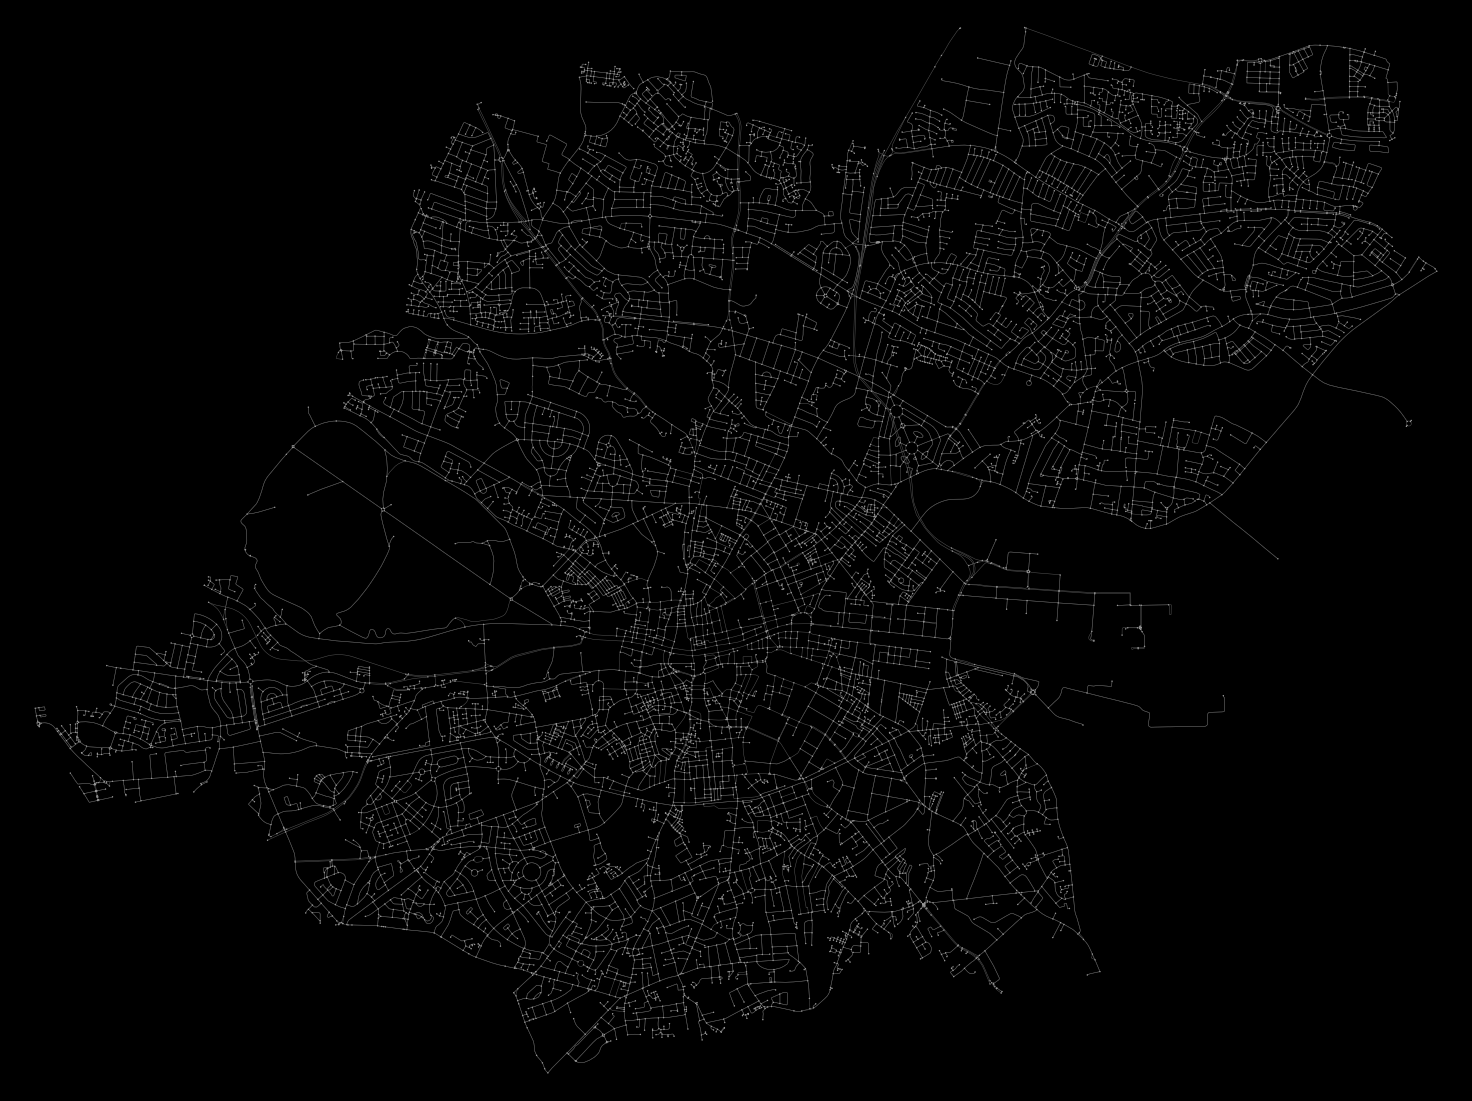

time: 30.5 s


In [13]:
# download and project a street network
G = ox.graph_from_place('Dublin, Ireland', network_type="drive")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [14]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 336173798,
 'center_node_2': 1426048815,
 'center_node_3': 450711419}

time: 101 ms


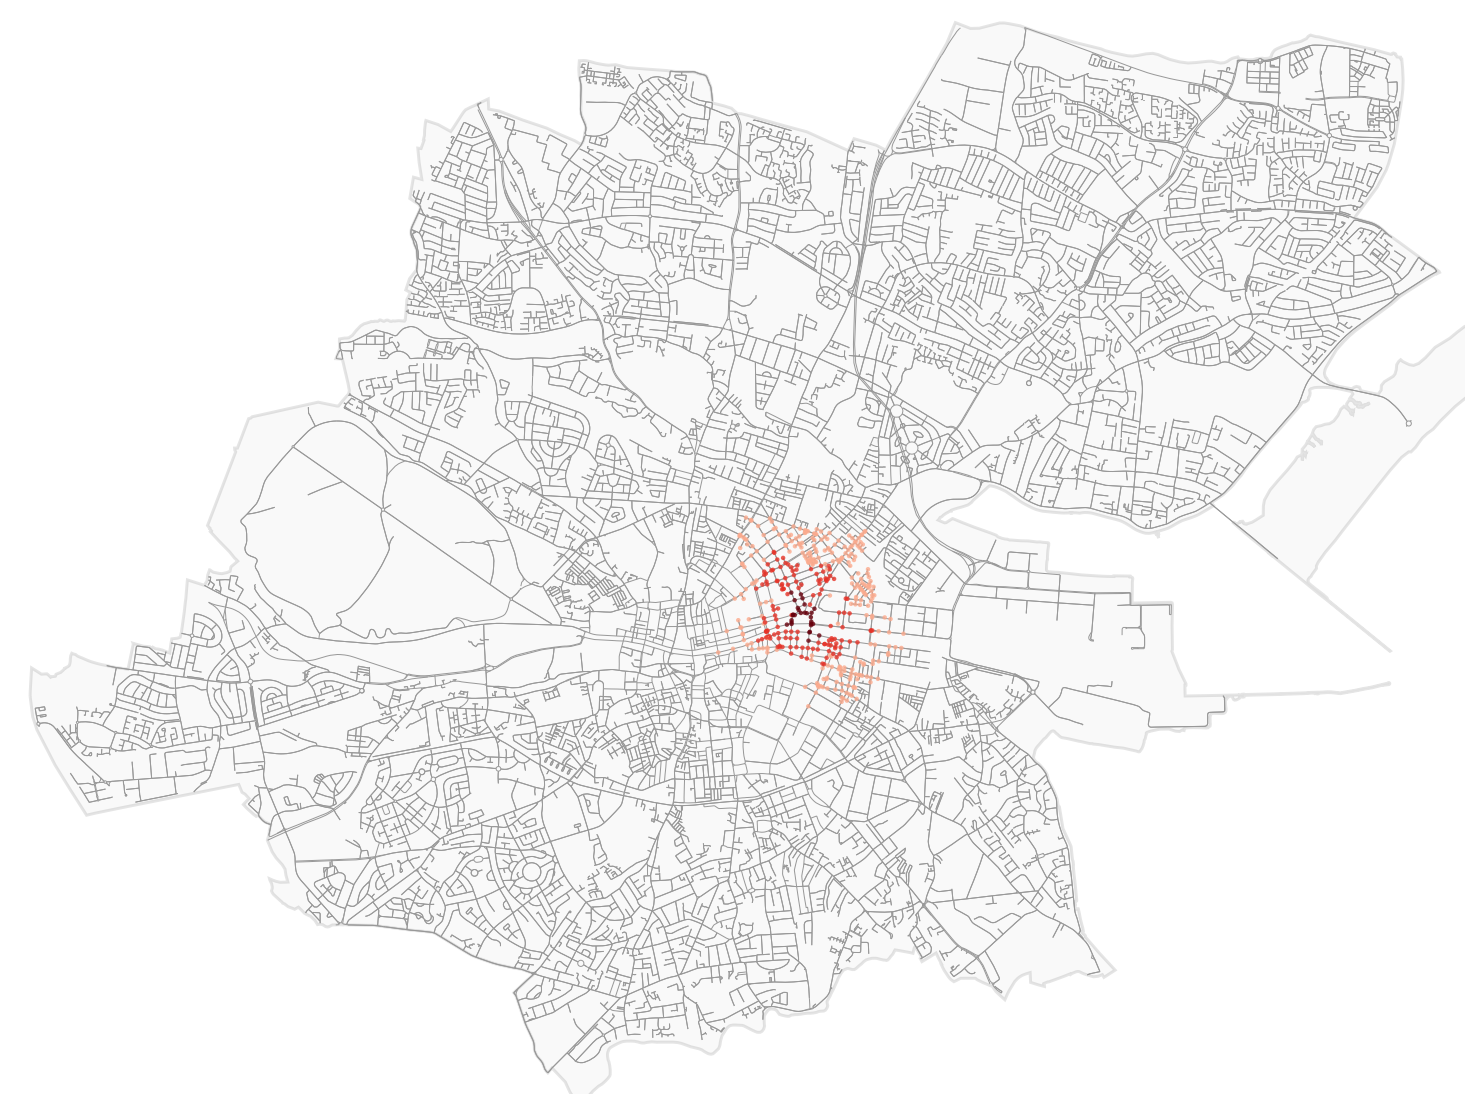

time: 6.11 s


In [15]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

957
957 233
Number of cells with price above 5th percentile:  233



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


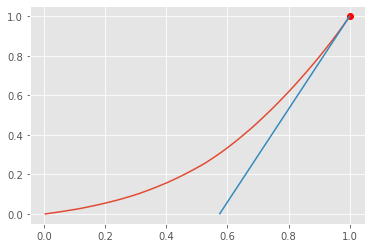

Loubar price:  51.841606589945464
Average price:  47.896357126868494
average city distance:  4260.485994007804
eta =  0.6562284272558169
time: 2.58 s


In [16]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.09*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.09*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [17]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Dublin'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 11 ms


In [18]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Dublin'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3495.925661234734,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4260.485994007804,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194,
 'Beijing': 6586.560663166117,
 'Berlin': 8495.253652229821,
 'Bordeaux': 3886.5511701192345,
 'Buenos_Aires': 4620.5517793826875,
 'Denver': 3896.3436245957214}

time: 9.98 ms


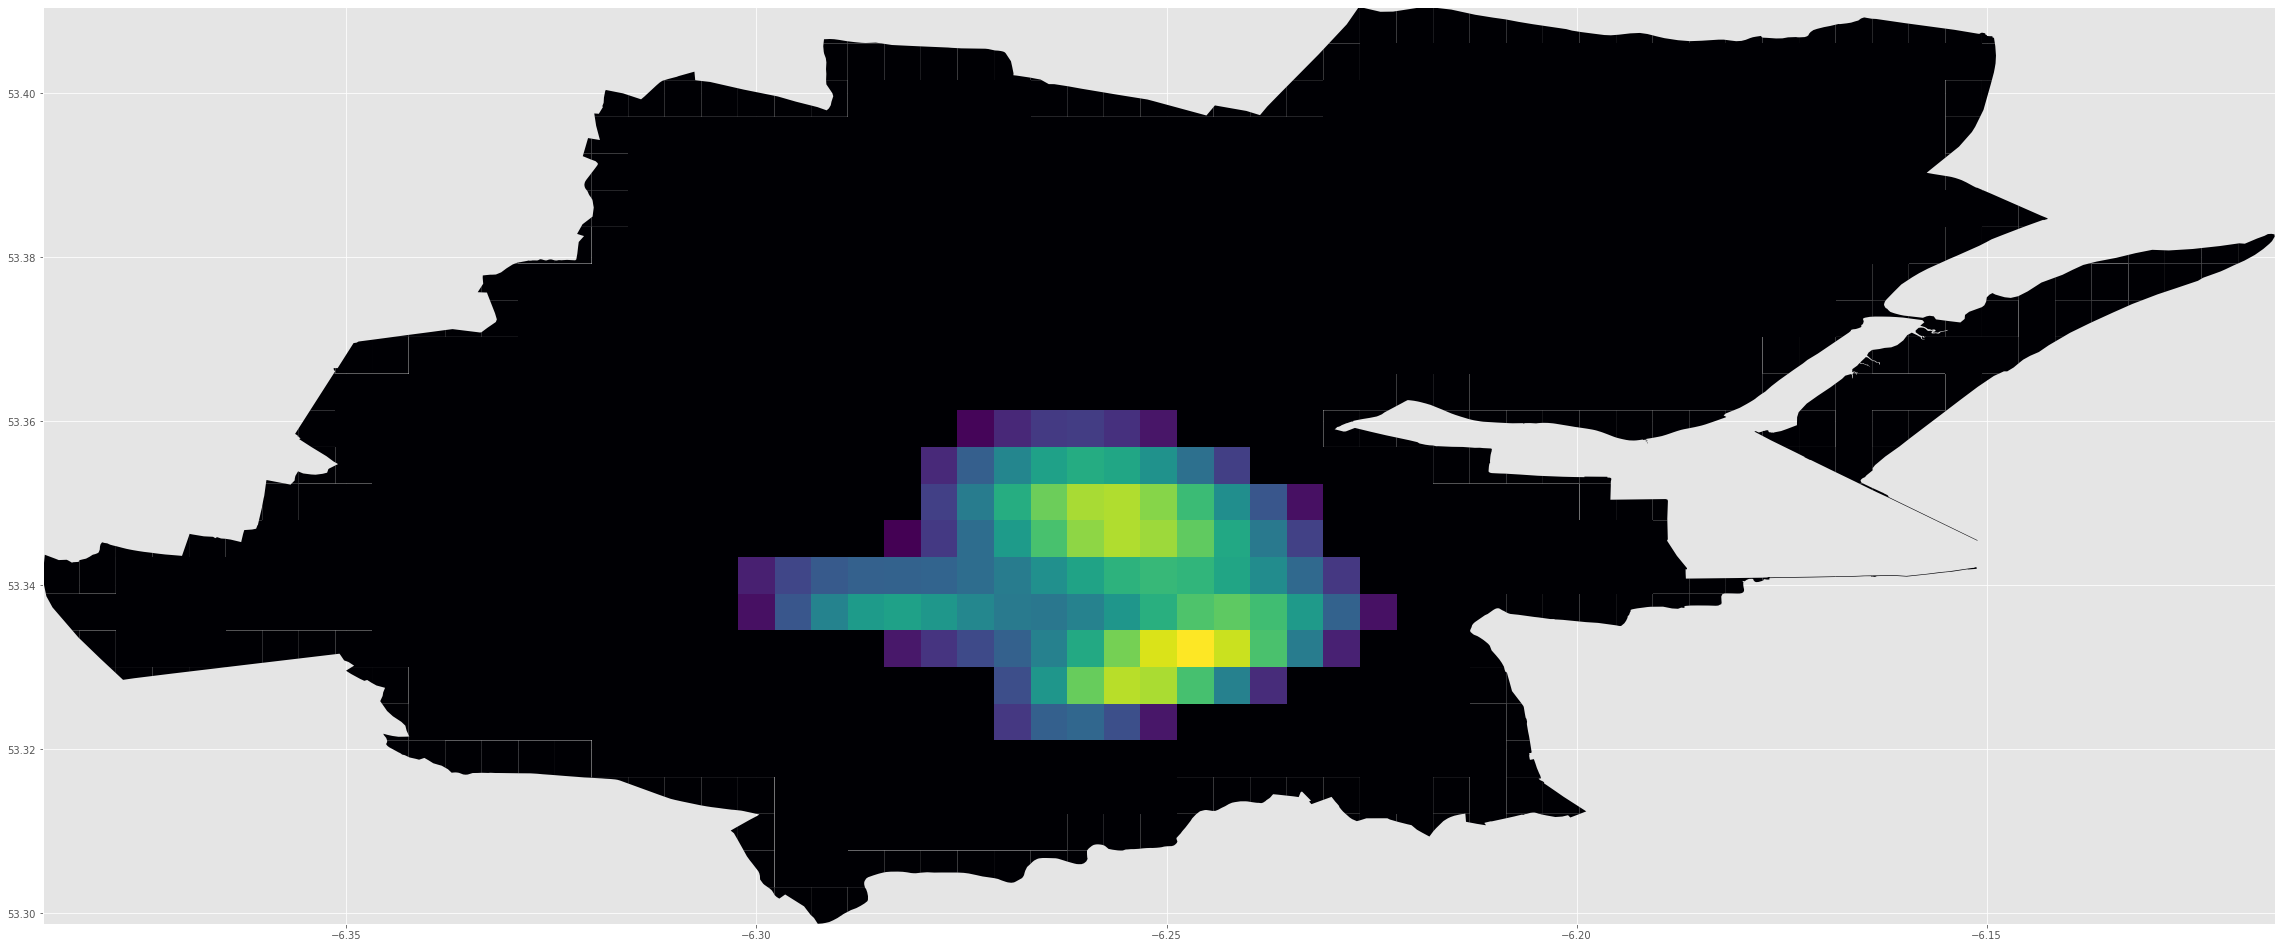

time: 1.07 s


In [19]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(loubar_keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [20]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

957
385



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes
time: 5.64 s


957


957 385
Number of cells with price above 1.0th percentile:  385
Loubar price:  23.077602942189703
Average price:  30.552271827005047
eta =  0.6559217891469493
957 339
Number of cells with price above 2.0th percentile:  339
Loubar price:  29.99533633316239
Average price:  34.48066570892558
eta =  0.6513618962080248
957 305
Number of cells with price above 3.0th percentile:  305
Loubar price:  36.5899218210793
Average price:  38.01995164228031
eta =  0.6637963008577326
957 289
Number of cells with price above 4.0th percentile:  289
Loubar price:  38.6471520221874
Average price:  39.922303769612256
eta =  0.6605964571849411
957 274
Number of cells with price above 5.0th percentile:  274
Loubar price:  40.70500886006807
Average price:  41.836718671162394
eta =  0.657560120147369
957 261
Number of cells with price above 6.000000000000001th percentile:  261
Loubar price:  43.26789043647929
Average price:  43.62074539544465
eta =  0.6595196161680839
957 251
Number of cells with price above 6.

eta =  0.7249098860324346
957 91
Number of cells with price above 52.0th percentile:  91
Loubar price:  82.75529797539987
Average price:  80.18407036802243
eta =  0.7249098860324346
957 89
Number of cells with price above 53.0th percentile:  89
Loubar price:  83.54154189227782
Average price:  80.69397782060014
eta =  0.7305989396368482
957 86
Number of cells with price above 54.0th percentile:  86
Loubar price:  83.72933203434722
Average price:  81.45006002935806
eta =  0.7342586295327853
957 85
Number of cells with price above 55.00000000000001th percentile:  85
Loubar price:  83.72933203434722
Average price:  81.69765572210255
eta =  0.7351680879437097
957 83
Number of cells with price above 56.00000000000001th percentile:  83
Loubar price:  83.8543269370186
Average price:  82.18847460972978
eta =  0.6980200526851656
957 79
Number of cells with price above 57.00000000000001th percentile:  79
Loubar price:  85.05723912621607
Average price:  83.20624610893455
eta =  0.6490314479123529


C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
957 3
Number of cells with price above 95.0th percentile:  3
Loubar price:  106.84343991835519
Average price:  107.46634741439418
eta =  nan
957 2
Number of cells with price above 96.00000000000001th percentile:  2
Loubar price:  110.0442077718049
Average price:  108.44382384508005
eta =  nan
957 2
Number of cells with price above 97.0th percentile:  2
Loubar price:  110.0442077718049
Average price:  108.44382384508005
eta =  nan
957 1
Number of cells with price above 98.0th percentile:  1


C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  110.0442077718049
Average price:  110.0442077718049
eta =  nan
957 1
Number of cells with price above 99.0th percentile:  1
Loubar price:  110.0442077718049
Average price:  110.0442077718049
eta =  nan
957 1
Number of cells with price above 100.0th percentile:  1
Loubar price:  110.0442077718049
Average price:  110.0442077718049
eta =  nan



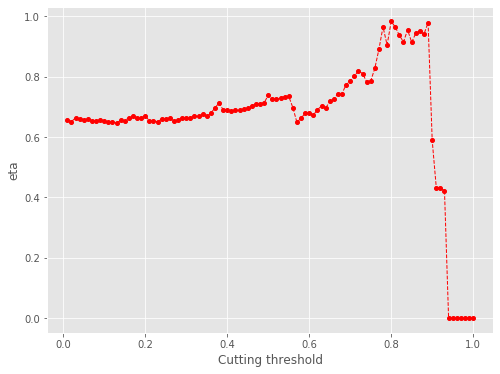

time: 2.4 s


In [21]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [22]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Dublin'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.69697859, 0.70601119, 0.71142664, 0.72735905, 0.71723297,
        0.69152614, 0.68969459, 0.69338651, 0.68627389, 0.68571239,
        0.68565242, 0.66080855, 0.68568495, 0.66662135, 0.65169235,
        0.66853925, 0.64080339, 0.6392735 , 0.64870117, 0.66369008,
        0.64936606, 0.65513408, 0.65817401, 0.54708479, 0.54484174,
        0.5177247 , 0.54225619, 0.54660686, 0.55128317, 0.55836993,
        0.56571414, 0.52792612, 0.52759205, 0.55096732, 0.46941853,
        0.48021089, 0.47484233, 0.46129546, 0.46439344, 0.4699713 ,
        0.50255475, 0.51573036, 0.52765377, 0.52765377, 0.53943229,
        0.54404083, 0.54813213, 0.6100999 , 0.50092562, 0.52536404,
        0.56707558, 0.56150998, 0.61316219, 0.66467806, 0.74541769,
        0.74541769, 0.77652679, 0.74895419, 0.92876367, 0.92876367,
        0.90963119, 0.90963119, 1.05344906, 1.15130075, 1.15130075,
        1.22651104, 1.26738008, 0.62257449, 0.62257449, 0.64231201,
        0.64231201, 0.62403947, 0.6307

time: 34 ms


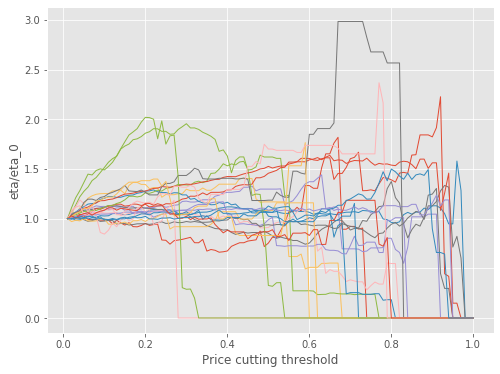

time: 260 ms


In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    #print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

957 233
Number of cells with price above 5th percentile:  233


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.9964661894375764
eta =  0.9706386806175923
eta =  0.9503082229366719
eta =  0.9398387806119909
eta =  0.9367802068306244
eta =  0.9206281446906257
eta =  0.911866173471057
eta =  0.8880711099825966
eta =  0.8740353328378297
eta =  0.8687668790169129
eta =  0.8670183605152162
eta =  0.8475144560117279
eta =  0.8384121401219168
eta =  0.8384121401219168
eta =  0.8350065325087791
eta =  0.8226772332599215
eta =  0.8103748927827368
eta =  0.7949879307537921
eta =  0.779097597143187
eta =  0.7715884856006688
eta =  0.7674347637304424
eta =  0.7651685013763377
eta =  0.7593185650105998
eta =  0.7567661050712919
eta =  0.7558860918232043
eta =  0.7436934633110066
eta =  0.7308805612352187
eta =  0.7207735634294432
eta =  0.7005857058221623
eta =  0.6953633983263909
eta =  0.6914374080075187
eta =  0.6914374080075187
eta =  0.689455197853558
eta =  0.6875803454927465
eta =  0.67547486258

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan



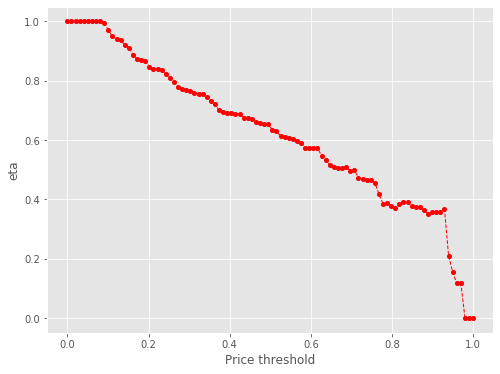

time: 866 ms


In [24]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.09*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.09*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [25]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Dublin'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 39 ms


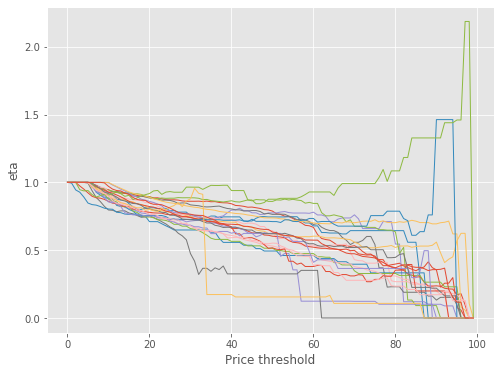

time: 242 ms


In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_threshold_dict:
    plt.plot(np.arange(100), etas_cut_threshold_dict[key], linestyle='-', linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

957 385
Number of cells with price above 1.0th percentile:  385


eta =  1.0
eta =  0.9343197394796579
eta =  0.8876557787286483
eta =  0.867260200143549
eta =  0.8407529384568745
eta =  0.8201997912301728
eta =  0.8094717835836692
eta =  0.7909569774847003
eta =  0.7795734991448179
eta =  0.7593676540911559
eta =  0.7434623617676139
eta =  0.7352717177962884
eta =  0.732878878891761
eta =  0.7202425047384239
eta =  0.7133876805251702
eta =  0.6993804166234783
eta =  0.6900976386813716
eta =  0.6796694589292583
eta =  0.6783015262275413
eta =  0.6660173328778818
eta =  0.6559217891469493
eta =  0.6559217891469493
eta =  0.654600434050444
eta =  0.6436117714753543
eta =  0.6339871813837599
eta =  0.6241438860587343
eta =  0.6192184265489218
eta =  0.6073467344259283
eta =  0.6003934809513136
eta =  0.6003934809513136
eta =  0.5940438691904233
eta =  0.593782546705112
eta =  0.5918429808381881
eta =  0.582309514457014
eta =  0.5800640337001391
eta =  0.567248541753746
eta =  0.5550522281692486
eta =  0.5469561025380988
eta =  0.541630608443344
eta =  0

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan


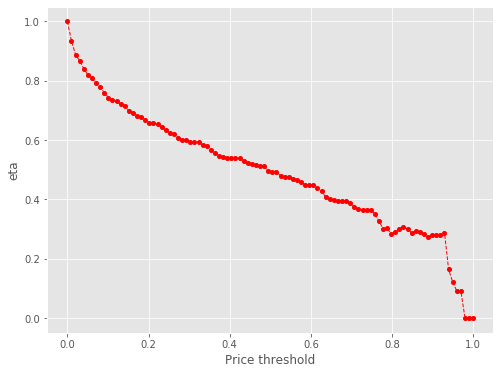

957 339
Number of cells with price above 2.0th percentile:  339


eta =  1.0
eta =  0.9502126171727056
eta =  0.9267986681999519
eta =  0.9020578056188371
eta =  0.8765075049497039
eta =  0.8650430065240032
eta =  0.847747610039604
eta =  0.838389590538662
eta =  0.8120395937095232
eta =  0.7968744988697211
eta =  0.7867656832081791
eta =  0.7831919057237166
eta =  0.7713980524141785
eta =  0.7623626128715975
eta =  0.7482189940316423
eta =  0.7374736813149771
eta =  0.7263295943334592
eta =  0.7248677513872146
eta =  0.7142681251747549
eta =  0.7031347902865503
eta =  0.7009516181234899
eta =  0.7007354079046834
eta =  0.6941596476814966
eta =  0.6775111728464582
eta =  0.6669921233196582
eta =  0.6631422010990229
eta =  0.649041826787821
eta =  0.642043517109188
eta =  0.6416112240011799
eta =  0.639716523068091
eta =  0.6348257036664455
eta =  0.6324737216507011
eta =  0.6226120974928591
eta =  0.6198861354585359
eta =  0.6110502073339893
eta =  0.6026002861946095
eta =  0.58450530453518
eta =  0.5788142087905483
eta =  0.5780738932328735
eta =  0

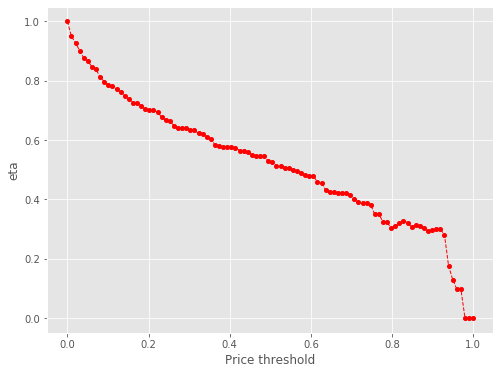

957 305
Number of cells with price above 3.0th percentile:  305


eta =  1.0
eta =  0.9744301567899666
eta =  0.9501126472671443
eta =  0.920669228585748
eta =  0.9087294503877571
eta =  0.8904603026934269
eta =  0.8806307911988083
eta =  0.8546313662326097
eta =  0.837024014068356
eta =  0.8282820276497939
eta =  0.8236838077505271
eta =  0.810263969034085
eta =  0.8026194691652645
eta =  0.7918842515611347
eta =  0.774853154734156
eta =  0.7629247936129849
eta =  0.7613892975561545
eta =  0.7502556225639677
eta =  0.7385613486584656
eta =  0.7362681801232457
eta =  0.7360410764256311
eta =  0.7291340048285733
eta =  0.7140265791011914
eta =  0.7008650788606178
eta =  0.6965537833740811
eta =  0.684179942699297
eta =  0.6743920688383791
eta =  0.6739379951880963
eta =  0.6719478321414402
eta =  0.6668105949811908
eta =  0.6645691018724692
eta =  0.6619652454704216
eta =  0.6530891033160924
eta =  0.6418372002937126
eta =  0.6329615405497042
eta =  0.6152331746663828
eta =  0.6106471021944402
eta =  0.6079770316766918
eta =  0.6071994162546384
eta = 

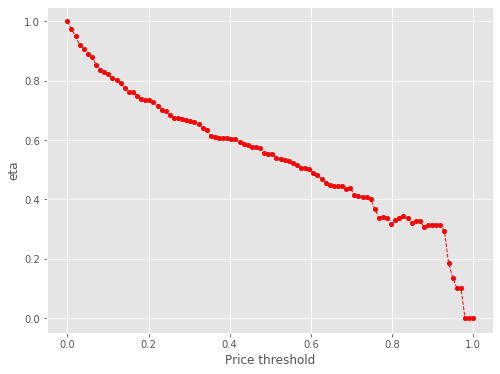

957 289
Number of cells with price above 4.0th percentile:  289


eta =  1.0
eta =  0.974222065307414
eta =  0.9448283411288075
eta =  0.9325752533987195
eta =  0.9138267083470006
eta =  0.9037392624422068
eta =  0.8770575913290635
eta =  0.8603681549373916
eta =  0.8500168245802001
eta =  0.8462262609907701
eta =  0.8348077854840015
eta =  0.8243663438544171
eta =  0.812663941117969
eta =  0.7997313902587592
eta =  0.78294456333973
eta =  0.7813687746122044
eta =  0.7740160768131665
eta =  0.7599042577748568
eta =  0.7555884585394093
eta =  0.7555884585394093
eta =  0.7525192784981629
eta =  0.7327632197400231
eta =  0.7253203243035795
eta =  0.714831923581589
eta =  0.7021333832207828
eta =  0.6996324721285034
eta =  0.6916226786414618
eta =  0.6901222451438419
eta =  0.6843082496316032
eta =  0.684007219452205
eta =  0.6817729384634142
eta =  0.6707908712616875
eta =  0.6682041919169236
eta =  0.6586795326697358
eta =  0.6417532623249453
eta =  0.6300655432455795
eta =  0.6239308455718681
eta =  0.6231328248859985
eta =  0.6213464300533634
eta =  

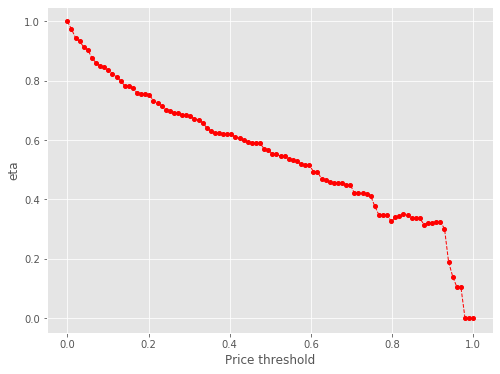

957 274
Number of cells with price above 5.0th percentile:  274


eta =  1.0
eta =  0.9716755395164448
eta =  0.9590742815814307
eta =  0.9397929985850798
eta =  0.9294189189610783
eta =  0.9019790909568827
eta =  0.8855332652034559
eta =  0.8741699636520762
eta =  0.8702716915951327
eta =  0.8611477972882553
eta =  0.8493589735929739
eta =  0.8357557019171923
eta =  0.8224556739793836
eta =  0.8051918511310666
eta =  0.8051918511310666
eta =  0.8008880008025708
eta =  0.7814968576959367
eta =  0.7770584254770871
eta =  0.7770584254770871
eta =  0.7739020350063185
eta =  0.7624749749685668
eta =  0.75107290090092
eta =  0.739411730783797
eta =  0.7335766299001631
eta =  0.7195124555710263
eta =  0.7112750646406928
eta =  0.7112750646406928
eta =  0.7082977958203852
eta =  0.7037527968963554
eta =  0.7011454451267748
eta =  0.6902130812622697
eta =  0.6871911440678422
eta =  0.6773958426253976
eta =  0.6680284594191929
eta =  0.6479687896876996
eta =  0.6444777712299458
eta =  0.6408390788618015
eta =  0.6390019238070365
eta =  0.6390019238070365
eta 

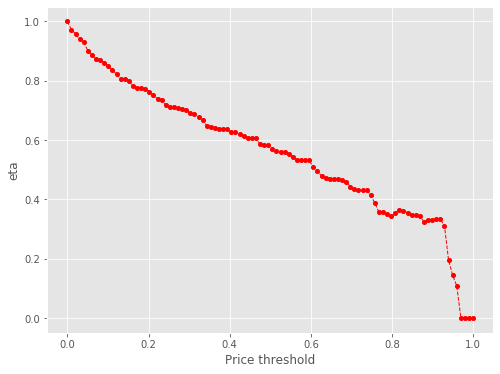

957 261
Number of cells with price above 6.000000000000001th percentile:  261


eta =  1.0
eta =  0.9817718113332433
eta =  0.9643467188627141
eta =  0.950467809770566
eta =  0.9264491052545181
eta =  0.90914737679907
eta =  0.8976143144984544
eta =  0.8935370219889424
eta =  0.8800815144856554
eta =  0.8717783154305905
eta =  0.8601180825577918
eta =  0.8416194770888759
eta =  0.8286632917936485
eta =  0.8269954875387054
eta =  0.8242339837031747
eta =  0.8042775864100163
eta =  0.7997097733506712
eta =  0.7997097733506712
eta =  0.7964613737127226
eta =  0.7847012134812131
eta =  0.7729667675638847
eta =  0.7609656729156379
eta =  0.7549604781295908
eta =  0.7404863314034769
eta =  0.7320088195228825
eta =  0.7320088195228825
eta =  0.728944762953352
eta =  0.7242672767563734
eta =  0.721583920364714
eta =  0.7103328767602349
eta =  0.7072228497280312
eta =  0.6971420140538933
eta =  0.6875015704847709
eta =  0.6668571589341046
eta =  0.6632643768625386
eta =  0.6595196161680839
eta =  0.6595196161680839
eta =  0.6576289078194109
eta =  0.6558406014665085
eta = 

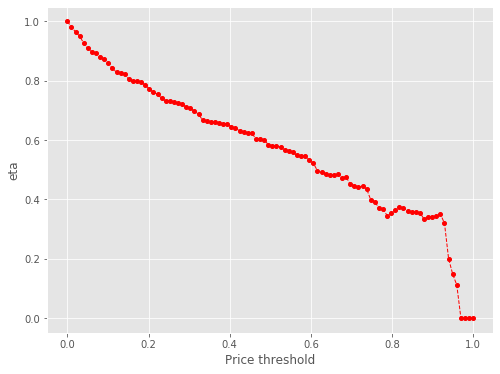

957 251
Number of cells with price above 6.999999999999999th percentile:  251


eta =  1.0
eta =  0.9800063160398265
eta =  0.9691883342396554
eta =  0.9387274246312177
eta =  0.921196394699261
eta =  0.9115753011154015
eta =  0.9075102237598583
eta =  0.8979959221412235
eta =  0.8857026600106801
eta =  0.8715173104910064
eta =  0.8576481803717328
eta =  0.842157320802914
eta =  0.8396456463500755
eta =  0.8370133871663976
eta =  0.819105608646421
eta =  0.8103084041337082
eta =  0.8103084041337082
eta =  0.8086760370477852
eta =  0.8024568055533261
eta =  0.7832109707110367
eta =  0.7710508243975388
eta =  0.7666002685389285
eta =  0.7529820960294079
eta =  0.7422099390053534
eta =  0.7417102030329823
eta =  0.7395199062283155
eta =  0.7338660608532767
eta =  0.7313991598614386
eta =  0.7305486448264694
eta =  0.7193697498373949
eta =  0.7063813044271273
eta =  0.7007638230976257
eta =  0.6771019383868818
eta =  0.675695081200522
eta =  0.6691161068585408
eta =  0.6682602932722896
eta =  0.6663445271834543
eta =  0.6645325202339191
eta =  0.6645325202339191
eta =

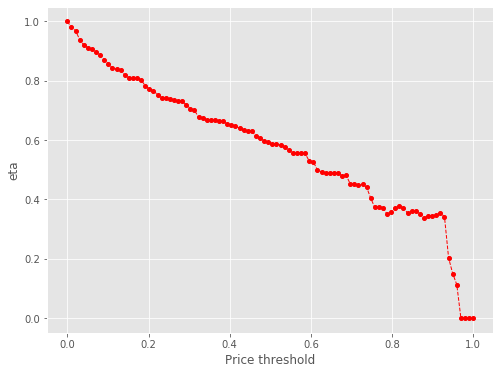

957 239
Number of cells with price above 8.0th percentile:  239


eta =  1.0
eta =  0.9861975296390312
eta =  0.9578789537036706
eta =  0.9399902629421671
eta =  0.9301728837820633
eta =  0.9260248723978408
eta =  0.9164999511740772
eta =  0.9037723997430707
eta =  0.8892976465833194
eta =  0.875145564201526
eta =  0.8593386665159917
eta =  0.8567757499186905
eta =  0.8550513652917892
eta =  0.8358166628521334
eta =  0.8268399814076076
eta =  0.8268399814076076
eta =  0.8265849406192337
eta =  0.8188281977569573
eta =  0.7991897173438297
eta =  0.7870817786493912
eta =  0.7822401304888883
eta =  0.7683441256503162
eta =  0.7573521995292842
eta =  0.7568422681500758
eta =  0.7546072858149439
eta =  0.7488380930225077
eta =  0.7485086758839533
eta =  0.7460637035840822
eta =  0.7340460342585796
eta =  0.7312154326563974
eta =  0.7207926039513614
eta =  0.7059631022929842
eta =  0.6894803330768151
eta =  0.6827671372184796
eta =  0.6818938636770299
eta =  0.6799390129199684
eta =  0.6799390129199684
eta =  0.6780900381532982
eta =  0.6759802937203307
et

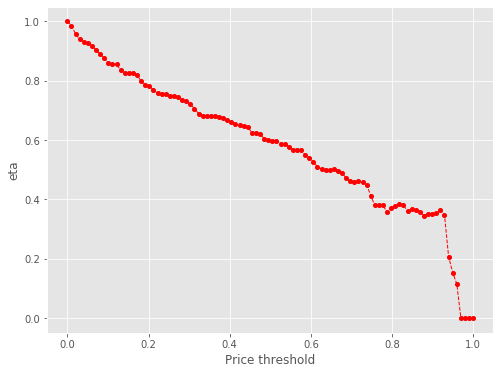

957 233
Number of cells with price above 9.0th percentile:  233


eta =  1.0
eta =  0.9712850873336443
eta =  0.953146032809698
eta =  0.9431912530976689
eta =  0.9389851876193456
eta =  0.9291409037131789
eta =  0.9164212772606216
eta =  0.901743940596587
eta =  0.8873937906961169
eta =  0.8713656652846489
eta =  0.8687668790169129
eta =  0.8670183605152162
eta =  0.8513164628097688
eta =  0.8384121401219168
eta =  0.8384121401219168
eta =  0.8381535298732506
eta =  0.8302882263928053
eta =  0.8110100746319371
eta =  0.7980974956786594
eta =  0.7931880855300909
eta =  0.779097597143187
eta =  0.7715884856006688
eta =  0.7674347637304424
eta =  0.7657698605074871
eta =  0.7593185650105998
eta =  0.7589845374667721
eta =  0.7565053462029631
eta =  0.744709802542776
eta =  0.7414492641489758
eta =  0.7308805612352187
eta =  0.7207735634294432
eta =  0.6991300549385672
eta =  0.6953633983263909
eta =  0.6914374080075187
eta =  0.6914374080075187
eta =  0.689455197853558
eta =  0.6875803454927465
eta =  0.6875803454927465
eta =  0.6754748625895751
eta = 

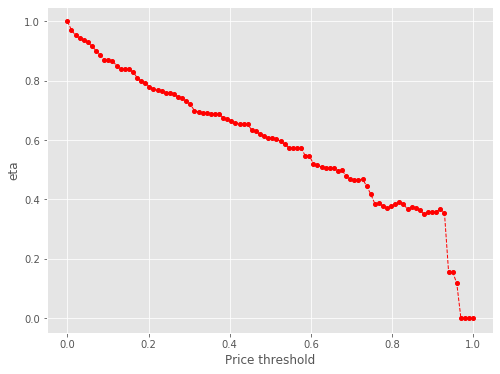

957 222
Number of cells with price above 10.0th percentile:  222


eta =  1.0
eta =  0.9813246854497258
eta =  0.96887601208472
eta =  0.9656846637195861
eta =  0.9537005048526109
eta =  0.9435142052642506
eta =  0.9284029502316766
eta =  0.9136285548583636
eta =  0.8971265765818638
eta =  0.8944509602240854
eta =  0.8926507488088185
eta =  0.8764846427806162
eta =  0.8641451488127747
eta =  0.8631988188179764
eta =  0.8629325630584279
eta =  0.8548347310387506
eta =  0.8371228260626679
eta =  0.8286199188560873
eta =  0.8166377677099292
eta =  0.8021307104404876
eta =  0.7992736214042186
eta =  0.7901230789378137
eta =  0.7901230789378137
eta =  0.7832632233463322
eta =  0.7817669342531229
eta =  0.7788705459070817
eta =  0.7667262807330245
eta =  0.7633693483181031
eta =  0.7524881940086405
eta =  0.742082394581079
eta =  0.7212977064698879
eta =  0.7197990209628435
eta =  0.7127906240955998
eta =  0.7118789498824091
eta =  0.7098381379932838
eta =  0.7079078578054572
eta =  0.7079078578054572
eta =  0.6954444903955825
eta =  0.6944977937111456
eta 

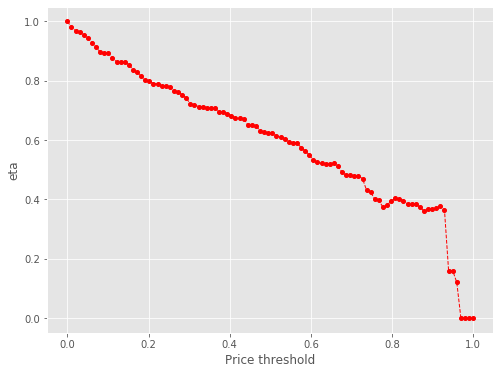

957 213
Number of cells with price above 11.0th percentile:  213


eta =  1.0
eta =  0.9873144194275507
eta =  0.9828296762345743
eta =  0.9680295372838783
eta =  0.9614699591826253
eta =  0.9460711260984982
eta =  0.9310155633552231
eta =  0.9141995405636052
eta =  0.9114730053021876
eta =  0.909638534568944
eta =  0.893164775916074
eta =  0.8823657819190723
eta =  0.8796261131680243
eta =  0.8793547903698757
eta =  0.8711028507827593
eta =  0.8530538755162645
eta =  0.8443891518701007
eta =  0.832178971769855
eta =  0.8243397412523824
eta =  0.8144843732713439
eta =  0.8051596894005705
eta =  0.8051596894005705
eta =  0.8017894365155888
eta =  0.7966445212726421
eta =  0.7936930125732418
eta =  0.7908557393149795
eta =  0.7802513337003942
eta =  0.7668085855435165
eta =  0.7607105576291373
eta =  0.735024520594148
eta =  0.7334973140240234
eta =  0.7263555423238324
eta =  0.7254265182946723
eta =  0.7233468682875087
eta =  0.7233468682875087
eta =  0.7213798534794159
eta =  0.7086792992238559
eta =  0.7086792992238559
eta =  0.7027139017602981
eta =

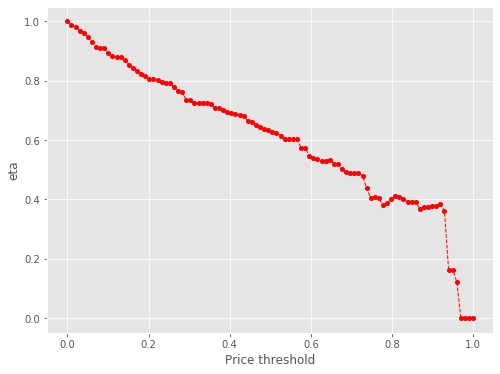

957 208
Number of cells with price above 12.0th percentile:  208


eta =  1.0
eta =  0.9954576342604449
eta =  0.9804673346563155
eta =  0.9738234753424242
eta =  0.9582267892400826
eta =  0.9429777840123412
eta =  0.9259456993382738
eta =  0.9231841319917758
eta =  0.9213260909289225
eta =  0.9046406679990908
eta =  0.8937029223483557
eta =  0.8909280527656381
eta =  0.8906532438569361
eta =  0.8822952786284926
eta =  0.8640143998006926
eta =  0.8552383468274283
eta =  0.8447838661015412
eta =  0.8410744636480401
eta =  0.824949334522619
eta =  0.81550484177817
eta =  0.81550484177817
eta =  0.8130966267612632
eta =  0.8068802658980105
eta =  0.8038908345260757
eta =  0.803232791694486
eta =  0.7909416799475513
eta =  0.7821068472290319
eta =  0.7766609809954113
eta =  0.7606820499651403
eta =  0.742921707199727
eta =  0.7356881739304248
eta =  0.7347472132689785
eta =  0.7347472132689785
eta =  0.7326408427286096
eta =  0.7306485545887957
eta =  0.7306485545887957
eta =  0.7177848163452847
eta =  0.7119779251986096
eta =  0.7058529770443307
eta =  0

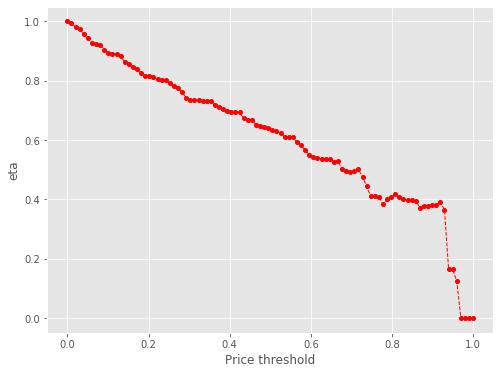

957 204
Number of cells with price above 13.0th percentile:  204


eta =  1.0
eta =  0.9827578955850858
eta =  0.9734046116923647
eta =  0.9553456675988535
eta =  0.9416257700384518
eta =  0.927396707020723
eta =  0.9255301875437452
eta =  0.9224396565779617
eta =  0.9011475238853983
eta =  0.8949934403060107
eta =  0.8949934403060107
eta =  0.8947173774187075
eta =  0.88632127401783
eta =  0.8657421118832122
eta =  0.8519581112615889
eta =  0.846717383380309
eta =  0.8316759806220508
eta =  0.8287136550371613
eta =  0.819226066194201
eta =  0.819226066194201
eta =  0.8157969339991966
eta =  0.8105621355724154
eta =  0.8075590631471827
eta =  0.8046722218898732
eta =  0.794550820372346
eta =  0.7824755515890083
eta =  0.774000395005957
eta =  0.764153112884883
eta =  0.746311728024132
eta =  0.7390451874699715
eta =  0.7380999331175395
eta =  0.7380999331175395
eta =  0.7359839510125514
eta =  0.7339825718767191
eta =  0.7339825718767191
eta =  0.7210601351995742
eta =  0.7152267466686909
eta =  0.7090738498065062
eta =  0.7028688103067329
eta =  0.70

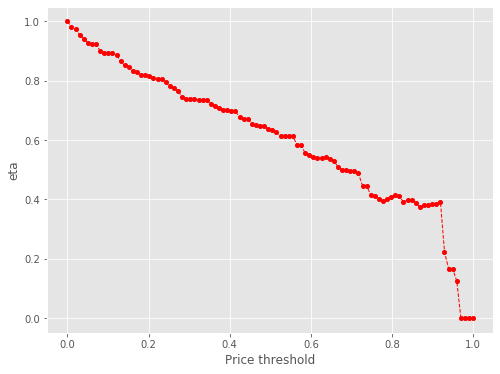

957 199
Number of cells with price above 14.000000000000002th percentile:  199


eta =  1.0
eta =  0.9882869297967456
eta =  0.9773163830857976
eta =  0.961763590362635
eta =  0.9415756133429787
eta =  0.9415756133429787
eta =  0.9396805567743632
eta =  0.9185420888044105
eta =  0.9086769352473495
eta =  0.9086769352473495
eta =  0.9083966516529978
eta =  0.8998721807879144
eta =  0.8812271141124316
eta =  0.872276226445847
eta =  0.8616134737397084
eta =  0.8578301733457168
eta =  0.8413838027676767
eta =  0.8317511588124757
eta =  0.8317511588124757
eta =  0.8292949678392691
eta =  0.8229547659339894
eta =  0.820188392018346
eta =  0.819905779734992
eta =  0.806698654805059
eta =  0.8035878928116701
eta =  0.7921334587527643
eta =  0.7811794239157112
eta =  0.757722038195331
eta =  0.7536397094423339
eta =  0.7503443999878961
eta =  0.7493846937047938
eta =  0.7472363604907074
eta =  0.745204382402919
eta =  0.745204382402919
eta =  0.7320843754543752
eta =  0.7320843754543752
eta =  0.7259219628070342
eta =  0.7179065760814743
eta =  0.7136149246100607
eta =  0.

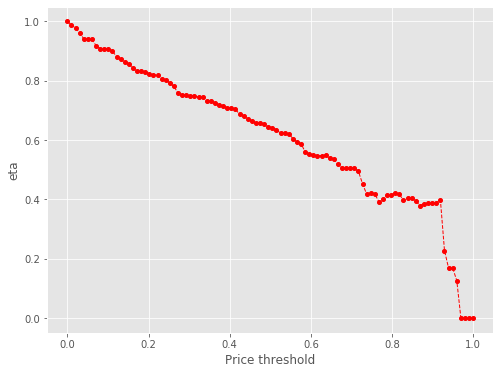

957 192
Number of cells with price above 15.000000000000002th percentile:  192


eta =  1.0
eta =  0.980365144669473
eta =  0.9673528959363957
eta =  0.9527350660568042
eta =  0.9508175494819314
eta =  0.9418703348881154
eta =  0.9246982061408445
eta =  0.9194464763732442
eta =  0.9194464763732442
eta =  0.9175942505322645
eta =  0.9105373689126751
eta =  0.8893959423286786
eta =  0.8752353348525559
eta =  0.8698514196560084
eta =  0.8593133647051606
eta =  0.8513557929383104
eta =  0.8416089839248775
eta =  0.8416089839248775
eta =  0.839123682440913
eta =  0.8327083371458136
eta =  0.829909176464601
eta =  0.8296232146909164
eta =  0.8162595603393918
eta =  0.8131119299300444
eta =  0.8015217391528968
eta =  0.7904378782752608
eta =  0.7667024781468745
eta =  0.7625717660733711
eta =  0.7592374009663514
eta =  0.7582663203477908
eta =  0.7560925253199358
eta =  0.7540364644467981
eta =  0.7540364644467981
eta =  0.7407609605895913
eta =  0.7407609605895913
eta =  0.7345255116915589
eta =  0.7264151274661919
eta =  0.7220726118039679
eta =  0.7181671091258472
eta 

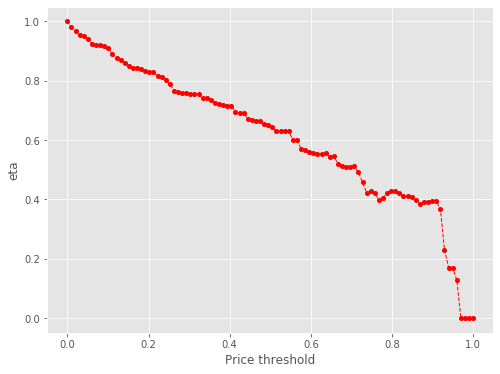

957 186
Number of cells with price above 16.0th percentile:  186


eta =  1.0
eta =  0.9867271405926368
eta =  0.9718165432921586
eta =  0.9698606224954035
eta =  0.960734212154864
eta =  0.9432181582226727
eta =  0.9378612462637405
eta =  0.9378612462637405
eta =  0.9375719606982007
eta =  0.9287737062700856
eta =  0.9095298091371856
eta =  0.9002914425224716
eta =  0.8892862302697153
eta =  0.8853814202268222
eta =  0.8684068355218222
eta =  0.8584648164012637
eta =  0.8584648164012637
eta =  0.8559297390400603
eta =  0.8493859065405253
eta =  0.8478085643436445
eta =  0.8462389949314458
eta =  0.8326076919172715
eta =  0.829397020437913
eta =  0.8175747001114848
eta =  0.8062688505125857
eta =  0.7836863897049378
eta =  0.78205807531577
eta =  0.7744434867911648
eta =  0.7734529572687306
eta =  0.7712356252474173
eta =  0.7712356252474173
eta =  0.7691383853727471
eta =  0.7667453618280554
eta =  0.7555969983401812
eta =  0.7494842060099445
eta =  0.7430366017489257
eta =  0.7365343573566279
eta =  0.7340676275636224
eta =  0.7325506348636813
eta =

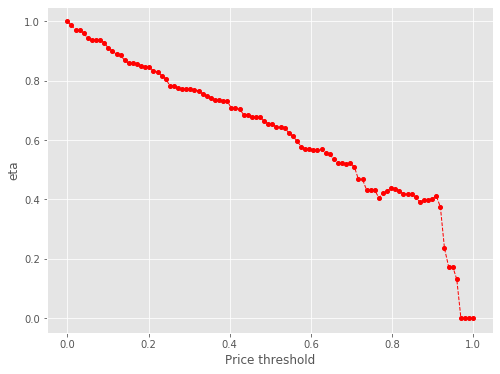

957 182
Number of cells with price above 17.0th percentile:  182


eta =  1.0
eta =  0.9848888343219964
eta =  0.9829066036563024
eta =  0.9736574303386839
eta =  0.9559057609950486
eta =  0.95047679108173
eta =  0.95047679108173
eta =  0.9501836142209354
eta =  0.9412670109714993
eta =  0.9217642565207178
eta =  0.912401620960531
eta =  0.9012483732185601
eta =  0.897291038021975
eta =  0.8800881214235676
eta =  0.8700123682476824
eta =  0.8700123682476824
eta =  0.8674431905521334
eta =  0.8608113343577201
eta =  0.8604326597026224
eta =  0.8576220923883653
eta =  0.8442499214110117
eta =  0.840553569794148
eta =  0.8285722227326618
eta =  0.8171142936519753
eta =  0.7942280671779729
eta =  0.7925778496840162
eta =  0.7848608342991634
eta =  0.7838569807699707
eta =  0.7816098225333161
eta =  0.7816098225333161
eta =  0.7794843718505564
eta =  0.7794843718505564
eta =  0.7657608342326159
eta =  0.7647184171125561
eta =  0.7593149457422563
eta =  0.7509308449043546
eta =  0.7439418633227572
eta =  0.7424044649503663
eta =  0.7404468688850941
eta =  0

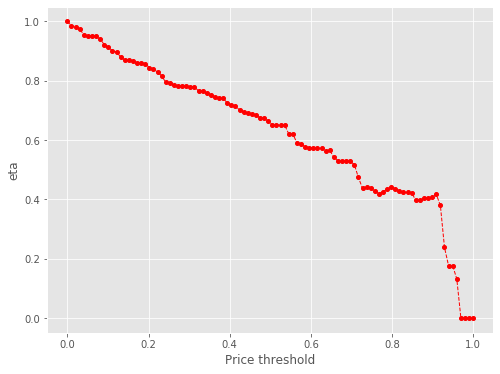

957 176
Number of cells with price above 18.000000000000004th percentile:  176


eta =  1.0
eta =  0.9946548759498123
eta =  0.9755372545633485
eta =  0.9650599722110204
eta =  0.9650599722110204
eta =  0.9647622971328005
eta =  0.9611399245027198
eta =  0.940930001512791
eta =  0.9327875087730648
eta =  0.9183050346884817
eta =  0.9130045178836168
eta =  0.896785565795056
eta =  0.888142152096993
eta =  0.8833609824063081
eta =  0.8833609824063081
eta =  0.8796633930477903
eta =  0.8740187769011596
eta =  0.8707806023395094
eta =  0.8700678053916568
eta =  0.856753980639907
eta =  0.8534501971207648
eta =  0.841285020053107
eta =  0.8296512917769872
eta =  0.8047383847433216
eta =  0.8004027491393969
eta =  0.7969029670637565
eta =  0.7958837113932586
eta =  0.7936020749706044
eta =  0.7936020749706044
eta =  0.7914440134628578
eta =  0.7889815903221845
eta =  0.777509915380217
eta =  0.77121984718532
eta =  0.7645852572459714
eta =  0.7578944425678525
eta =  0.7553561756387374
eta =  0.7537951889376857
eta =  0.7518075574435996
eta =  0.7369388389161382
eta =  0.

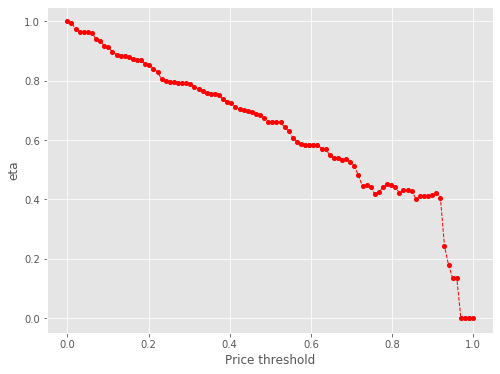

957 175
Number of cells with price above 19.0th percentile:  175


eta =  1.0
eta =  0.9775046234408482
eta =  0.9700180328631356
eta =  0.9670062115220946
eta =  0.9670062115220946
eta =  0.9630782582419427
eta =  0.9488579143480359
eta =  0.9346686641113117
eta =  0.920156983178246
eta =  0.9148457768054042
eta =  0.8985941159080147
eta =  0.8953934363140286
eta =  0.8851424591220913
eta =  0.8851424591220913
eta =  0.8825286017260865
eta =  0.875781413163365
eta =  0.8728374617367871
eta =  0.8725367081654627
eta =  0.8584817989362358
eta =  0.855171352667062
eta =  0.8429816420506954
eta =  0.8313244520002222
eta =  0.808040218901301
eta =  0.8063613030329794
eta =  0.7985100836433178
eta =  0.7974887724368831
eta =  0.7974887724368831
eta =  0.7952025346312814
eta =  0.7930401209544853
eta =  0.7930401209544853
eta =  0.7790779219348729
eta =  0.778017376491204
eta =  0.7725199351776555
eta =  0.7639900292774267
eta =  0.7594228905402525
eta =  0.7553153699331195
eta =  0.7533237299766984
eta =  0.7533237299766984
eta =  0.7306048867014039
eta = 

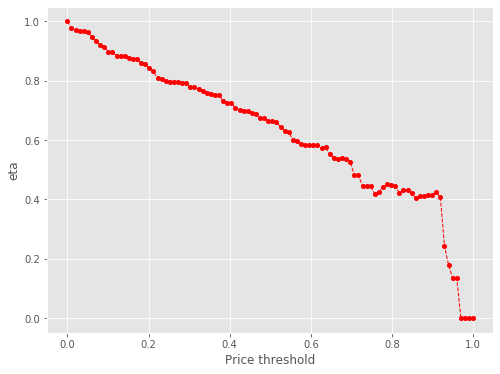

957 169
Number of cells with price above 20.0th percentile:  169


eta =  1.0
eta =  0.9879092925648285
eta =  0.9848419204237384
eta =  0.9848419204237384
eta =  0.9808415189726758
eta =  0.9663588914334822
eta =  0.9519079310508052
eta =  0.9371285929778868
eta =  0.9317194253617213
eta =  0.9151680146907726
eta =  0.9119083009470099
eta =  0.9014682521203983
eta =  0.9014682521203983
eta =  0.8988061840727244
eta =  0.891934548645365
eta =  0.8915421827527505
eta =  0.8886299974819214
eta =  0.8747743466452678
eta =  0.8709443509430366
eta =  0.85852981019884
eta =  0.8517023713221503
eta =  0.8333900647462889
eta =  0.8212340363195718
eta =  0.8132380070394583
eta =  0.8121978585089621
eta =  0.8121978585089621
eta =  0.809869452750875
eta =  0.807667154965368
eta =  0.807667154965368
eta =  0.7934474335902906
eta =  0.7934474335902906
eta =  0.7870284306070188
eta =  0.7780812559971624
eta =  0.7734298797896813
eta =  0.7708395830734154
eta =  0.7672182247549855
eta =  0.7672182247549855
eta =  0.7440803493468958
eta =  0.7430948192797395
eta =  

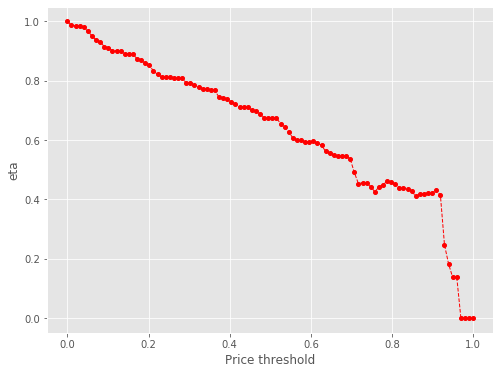

957 163
Number of cells with price above 21.000000000000004th percentile:  163


eta =  1.0
eta =  0.9959380268364882
eta =  0.9812324916243373
eta =  0.9665591109700499
eta =  0.9519154810456405
eta =  0.9460598762498242
eta =  0.9292537164715857
eta =  0.9259438312238496
eta =  0.9153430956031322
eta =  0.9153430956031322
eta =  0.912640054645525
eta =  0.9056626552427836
eta =  0.9052642502962864
eta =  0.9023072424654498
eta =  0.8990816978666843
eta =  0.8877727864694495
eta =  0.8843493893601765
eta =  0.8717437716597692
eta =  0.8596888438717415
eta =  0.8338739642258804
eta =  0.8338739642258804
eta =  0.8257548649935151
eta =  0.824698707138203
eta =  0.8223344639944046
eta =  0.8223344639944046
eta =  0.8200982697993409
eta =  0.8200982697993409
eta =  0.8056596872408738
eta =  0.8056596872408738
eta =  0.798877945118561
eta =  0.7900570029171635
eta =  0.7853340355951796
eta =  0.7810863683535519
eta =  0.7790267745963555
eta =  0.7790267745963555
eta =  0.7555327752770187
eta =  0.754532076538756
eta =  0.7510216317086764
eta =  0.7381435095893203
eta =

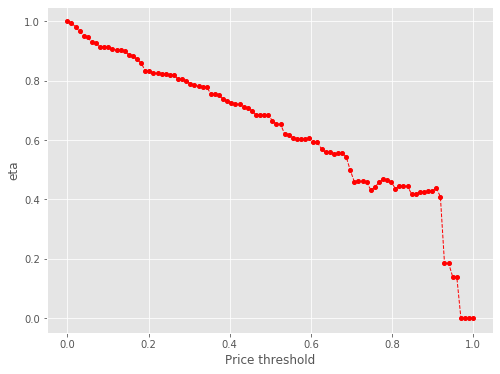

957 163
Number of cells with price above 22.0th percentile:  163


eta =  1.0
eta =  0.9959380268364882
eta =  0.9812324916243373
eta =  0.9665591109700499
eta =  0.9519154810456405
eta =  0.9460598762498242
eta =  0.9292537164715857
eta =  0.9259438312238496
eta =  0.9153430956031322
eta =  0.9153430956031322
eta =  0.912640054645525
eta =  0.9056626552427836
eta =  0.9052642502962864
eta =  0.9023072424654498
eta =  0.8990816978666843
eta =  0.8877727864694495
eta =  0.8843493893601765
eta =  0.8717437716597692
eta =  0.8596888438717415
eta =  0.8338739642258804
eta =  0.8338739642258804
eta =  0.8257548649935151
eta =  0.824698707138203
eta =  0.8223344639944046
eta =  0.8223344639944046
eta =  0.8200982697993409
eta =  0.8200982697993409
eta =  0.8056596872408738
eta =  0.8056596872408738
eta =  0.798877945118561
eta =  0.7900570029171635
eta =  0.7853340355951796
eta =  0.7810863683535519
eta =  0.7790267745963555
eta =  0.7790267745963555
eta =  0.7555327752770187
eta =  0.754532076538756
eta =  0.7510216317086764
eta =  0.7381435095893203
eta =

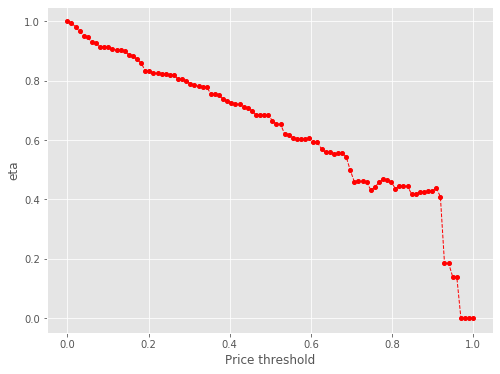

957 161
Number of cells with price above 23.0th percentile:  161


eta =  1.0
eta =  0.9923093659147321
eta =  0.9717490300301551
eta =  0.9618786841583385
eta =  0.950120626066722
eta =  0.9459486953245808
eta =  0.9311294777304174
eta =  0.9178087454092518
eta =  0.9171907773361586
eta =  0.915200987515029
eta =  0.9133515825725743
eta =  0.9074907963544764
eta =  0.9044402533943512
eta =  0.9041286104502952
eta =  0.8895648156752378
eta =  0.8861345082081612
eta =  0.8735034452188012
eta =  0.8614241837465256
eta =  0.8479252369797173
eta =  0.8355571950261644
eta =  0.8310555189627984
eta =  0.8263634170636389
eta =  0.8263634170636389
eta =  0.8239944015357036
eta =  0.8239944015357036
eta =  0.8217536934319366
eta =  0.819196967654472
eta =  0.8072859656214081
eta =  0.8007550086829891
eta =  0.793866335960314
eta =  0.7916517862277622
eta =  0.7842838111465292
eta =  0.782663043833659
eta =  0.780599292647646
eta =  0.780599292647646
eta =  0.7570578691071768
eta =  0.7525376194914886
eta =  0.7525376194914886
eta =  0.7328748619899058
eta =  0

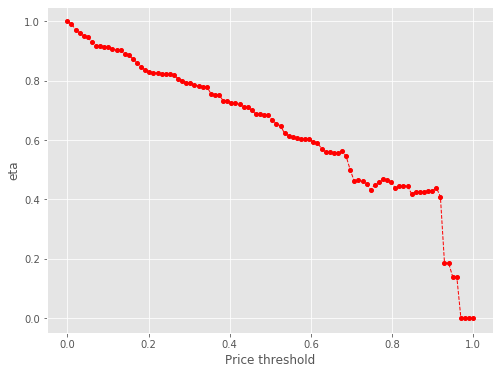

957 158
Number of cells with price above 24.000000000000004th percentile:  158


eta =  1.0
eta =  0.985045969452156
eta =  0.9697521296541954
eta =  0.9641546568476466
eta =  0.9470270546517414
eta =  0.9436538630014558
eta =  0.9328503727876647
eta =  0.9328503727876647
eta =  0.9300956322132545
eta =  0.9229847798288302
eta =  0.9229847798288302
eta =  0.9195651898682704
eta =  0.9162779520053803
eta =  0.9047527411162525
eta =  0.9012638665238448
eta =  0.8884171479245251
eta =  0.8761316519886211
eta =  0.8515924319991667
eta =  0.8498230249647372
eta =  0.8415486360694765
eta =  0.8404722776484832
eta =  0.8404722776484832
eta =  0.8380628148922258
eta =  0.83578385020837
eta =  0.83578385020837
eta =  0.8210691086137807
eta =  0.8210691086137807
eta =  0.8144266458184627
eta =  0.807420359802348
eta =  0.8051680001029103
eta =  0.7976742283914453
eta =  0.7960257890161562
eta =  0.7939268025121656
eta =  0.7939268025121656
eta =  0.7699834460498814
eta =  0.7653860202544163
eta =  0.7653860202544163
eta =  0.7453875519764669
eta =  0.7453875519764669
eta =  

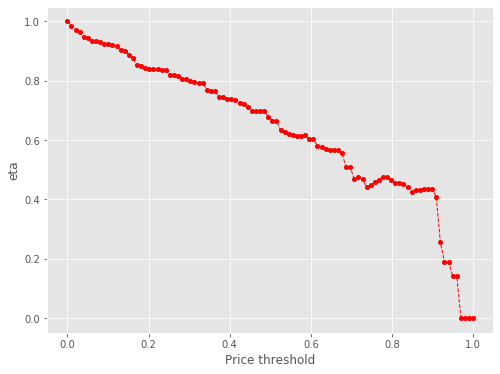

957 154
Number of cells with price above 25.0th percentile:  154


eta =  1.0
eta =  0.9844739836796994
eta =  0.9787915353675035
eta =  0.9614039182135234
eta =  0.9521376988261819
eta =  0.947012019455782
eta =  0.947012019455782
eta =  0.9442154590313561
eta =  0.936996656452651
eta =  0.9365844675425519
eta =  0.9335251535313592
eta =  0.9189694907569579
eta =  0.9177153314279597
eta =  0.9045290217968031
eta =  0.9019042516550044
eta =  0.8894322490105627
eta =  0.8645204979345169
eta =  0.8627242294462415
eta =  0.8543242266526028
eta =  0.8532315279823144
eta =  0.8532315279823144
eta =  0.8507854870553134
eta =  0.8484719252982684
eta =  0.8484719252982684
eta =  0.8335337984991983
eta =  0.8335337984991983
eta =  0.8267904961546261
eta =  0.81967784737133
eta =  0.8173912944902596
eta =  0.8097837594676729
eta =  0.8081102950544273
eta =  0.8059794437347089
eta =  0.8059794437347089
eta =  0.7816726020188847
eta =  0.7770053824798594
eta =  0.7770053824798594
eta =  0.7567033164868665
eta =  0.7567033164868665
eta =  0.7482876007928594
eta = 

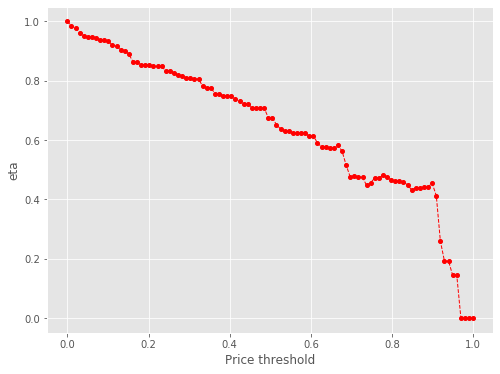

957 151
Number of cells with price above 26.0th percentile:  151


eta =  1.0
eta =  0.9921084550857093
eta =  0.9765660994108283
eta =  0.9671537436340846
eta =  0.9619472278140915
eta =  0.9619472278140915
eta =  0.9591065631842622
eta =  0.9517739137710973
eta =  0.9513552242811442
eta =  0.9482476622105267
eta =  0.9334624438952633
eta =  0.9321885053760245
eta =  0.9187942361015132
eta =  0.9161280710374169
eta =  0.9034593739959524
eta =  0.8781547428030261
eta =  0.8763301455886218
eta =  0.867797667399364
eta =  0.8666877359147309
eta =  0.8666877359147309
eta =  0.8642031187815707
eta =  0.8618530701308207
eta =  0.8618530701308207
eta =  0.8591715829913011
eta =  0.8466793559984924
eta =  0.8398297058743038
eta =  0.8395523256361667
eta =  0.8302822705736421
eta =  0.8253188362676835
eta =  0.8208549016541078
eta =  0.8186904449441864
eta =  0.8186904449441864
eta =  0.7940002630615004
eta =  0.7929486143608406
eta =  0.7892594373856604
eta =  0.7757256335784626
eta =  0.7686371900438776
eta =  0.7637033763046904
eta =  0.7600887511480611
et

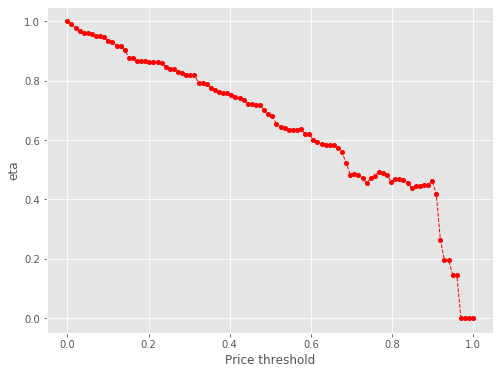

957 148
Number of cells with price above 27.0th percentile:  148


eta =  1.0
eta =  0.9808279411367685
eta =  0.9702521394083922
eta =  0.9695988607727245
eta =  0.9674953747898543
eta =  0.9655402952473849
eta =  0.9593446249673102
eta =  0.9561197746395887
eta =  0.9557903244848432
eta =  0.9408874998597009
eta =  0.9367680431168672
eta =  0.9234152439092675
eta =  0.9234152439092675
eta =  0.9106457760385699
eta =  0.883300753154971
eta =  0.883300753154971
eta =  0.8747004049314286
eta =  0.8735816447001823
eta =  0.8735816447001823
eta =  0.871077264135312
eta =  0.8687085224531871
eta =  0.8687085224531871
eta =  0.8660057059155658
eta =  0.85341411179219
eta =  0.8465099773812027
eta =  0.8462303907727878
eta =  0.8368865987558922
eta =  0.8318836837212352
eta =  0.8273842415577369
eta =  0.8252025680735267
eta =  0.8252025680735267
eta =  0.8003159926632274
eta =  0.79925597881568
eta =  0.795537456958247
eta =  0.781896000988568
eta =  0.7747511737287576
eta =  0.7697781148722428
eta =  0.7661347378421406
eta =  0.7651869713481123
eta =  0.7

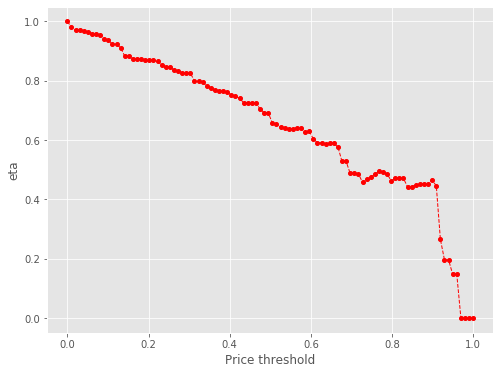

957 143
Number of cells with price above 28.000000000000004th percentile:  143


eta =  1.0
eta =  0.988551426918946
eta =  0.988551426918946
eta =  0.9856321991359448
eta =  0.9780967534993351
eta =  0.9780967534993351
eta =  0.9744729777753813
eta =  0.9736753011132497
eta =  0.9587760688421584
eta =  0.9550788714595179
eta =  0.9414650676030291
eta =  0.9284459973511172
eta =  0.9220954768153503
eta =  0.9005664664601983
eta =  0.8957145442582632
eta =  0.8917980088512373
eta =  0.8906573804246554
eta =  0.8881040472050004
eta =  0.8881040472050004
eta =  0.8856890041757617
eta =  0.8856890041757617
eta =  0.8700956365528215
eta =  0.8700956365528215
eta =  0.8630565483280453
eta =  0.8556319127801868
eta =  0.8532450633349108
eta =  0.848144357263203
eta =  0.8435569653519536
eta =  0.8413326471074286
eta =  0.8413326471074286
eta =  0.8159596184991122
eta =  0.8148788847607168
eta =  0.811087677657539
eta =  0.7971795747196592
eta =  0.7898950888683184
eta =  0.7848248225678386
eta =  0.7811102291337654
eta =  0.7801439368267478
eta =  0.7785719360050399
eta =

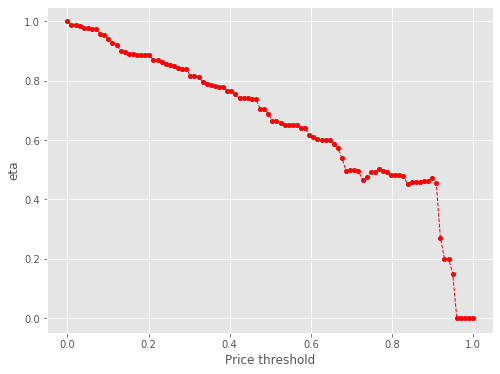

957 139
Number of cells with price above 29.000000000000004th percentile:  139


eta =  1.0
eta =  0.9958141808024558
eta =  0.9894242493259098
eta =  0.9889889972893665
eta =  0.9857585060724221
eta =  0.9703884131112303
eta =  0.9698798087120368
eta =  0.9661397934918234
eta =  0.9523683259831279
eta =  0.9391984797845454
eta =  0.9128928463139566
eta =  0.9109960715620293
eta =  0.9060879584686548
eta =  0.9021260650351154
eta =  0.9009722268072582
eta =  0.8983893230248894
eta =  0.8983893230248894
eta =  0.8959463109938758
eta =  0.8959463109938758
eta =  0.8801723540723421
eta =  0.8801723540723421
eta =  0.8730517450346159
eta =  0.8727633921706367
eta =  0.8631266316556242
eta =  0.8579668534864647
eta =  0.8533263342516211
eta =  0.8510762558197306
eta =  0.8510762558197306
eta =  0.8254093780859162
eta =  0.8254093780859162
eta =  0.8204810145138178
eta =  0.8204810145138178
eta =  0.7990429909450569
eta =  0.7990429909450569
eta =  0.7901563923368964
eta =  0.7901563923368964
eta =  0.7891789092432456
eta =  0.7782594653121642
eta =  0.7756886863160467
e

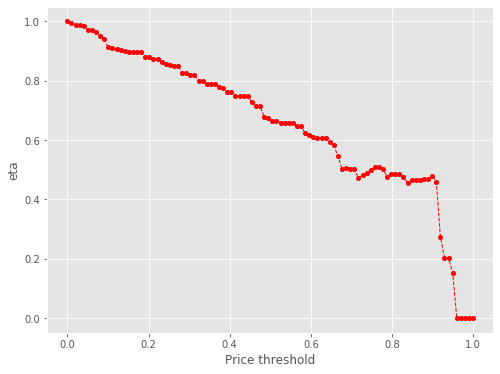

957 139
Number of cells with price above 30.0th percentile:  139


eta =  1.0
eta =  0.9958141808024558
eta =  0.9894242493259098
eta =  0.9889889972893665
eta =  0.9857585060724221
eta =  0.9703884131112303
eta =  0.9698798087120368
eta =  0.9661397934918234
eta =  0.9523683259831279
eta =  0.9391984797845454
eta =  0.9128928463139566
eta =  0.9109960715620293
eta =  0.9060879584686548
eta =  0.9021260650351154
eta =  0.9009722268072582
eta =  0.8983893230248894
eta =  0.8983893230248894
eta =  0.8959463109938758
eta =  0.8959463109938758
eta =  0.8801723540723421
eta =  0.8801723540723421
eta =  0.8730517450346159
eta =  0.8727633921706367
eta =  0.8631266316556242
eta =  0.8579668534864647
eta =  0.8533263342516211
eta =  0.8510762558197306
eta =  0.8510762558197306
eta =  0.8254093780859162
eta =  0.8254093780859162
eta =  0.8204810145138178
eta =  0.8204810145138178
eta =  0.7990429909450569
eta =  0.7990429909450569
eta =  0.7901563923368964
eta =  0.7901563923368964
eta =  0.7891789092432456
eta =  0.7782594653121642
eta =  0.7756886863160467
e

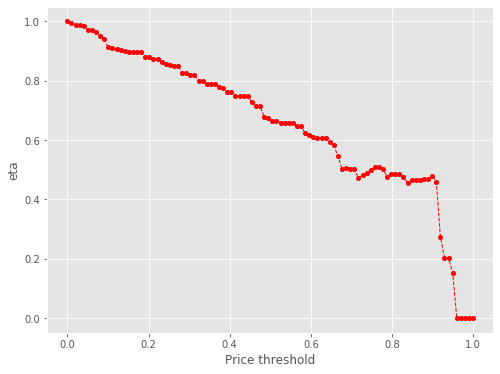

957 135
Number of cells with price above 31.0th percentile:  135


eta =  1.0
eta =  0.9980896727324734
eta =  0.9947345803866791
eta =  0.9943918247297713
eta =  0.9788871197824698
eta =  0.9775511881485478
eta =  0.9635051193886693
eta =  0.9607092118965938
eta =  0.9474240235749656
eta =  0.9208880041479423
eta =  0.9189746173548774
eta =  0.9100269268999346
eta =  0.908862983303431
eta =  0.908862983303431
eta =  0.906257458330094
eta =  0.906257458330094
eta =  0.9037930502865503
eta =  0.9037930502865503
eta =  0.8878809443196348
eta =  0.8878809443196348
eta =  0.8806979726581237
eta =  0.8731215728412265
eta =  0.8706859346764191
eta =  0.8654809669310488
eta =  0.8607998058137937
eta =  0.8585300210907711
eta =  0.8585300210907711
eta =  0.8326383516528526
eta =  0.8326383516528526
eta =  0.8276668252443037
eta =  0.8276668252443037
eta =  0.8060410464721002
eta =  0.8060410464721002
eta =  0.7970766186216947
eta =  0.7970766186216947
eta =  0.7960905746858319
eta =  0.7850754977590042
eta =  0.7824822037613581
eta =  0.7783176956120264
eta =

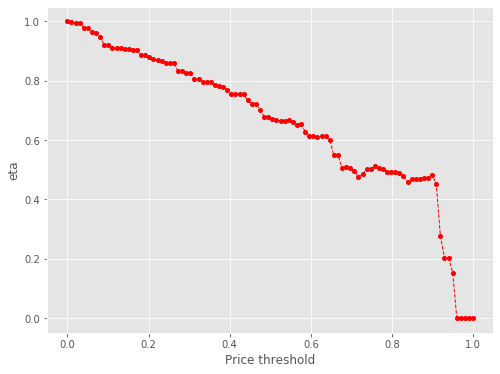

957 133
Number of cells with price above 32.0th percentile:  133


eta =  1.0
eta =  0.9967335418029942
eta =  0.9811923244554622
eta =  0.9806780574609987
eta =  0.9768964024269547
eta =  0.9629716089798683
eta =  0.9496551350507563
eta =  0.9347735652541874
eta =  0.9211387326440423
eta =  0.916175974608486
eta =  0.9121699710590047
eta =  0.9110032864639083
eta =  0.9110032864639083
eta =  0.9083916256775416
eta =  0.9059214141405989
eta =  0.9059214141405989
eta =  0.9059214141405989
eta =  0.8899718363750553
eta =  0.8887603329432584
eta =  0.8824803860939986
eta =  0.8727363337926838
eta =  0.8675191087443754
eta =  0.864613697462244
eta =  0.8628269238489292
eta =  0.8605517939556164
eta =  0.8605517939556164
eta =  0.8345991516065484
eta =  0.8334937299156606
eta =  0.8296159176316446
eta =  0.8296159176316446
eta =  0.8079392117961717
eta =  0.8060830583833637
eta =  0.7989536734003785
eta =  0.7989536734003785
eta =  0.7979653074060855
eta =  0.7869242908113513
eta =  0.7843248898036925
eta =  0.777439750141535
eta =  0.7721018306114513
eta 

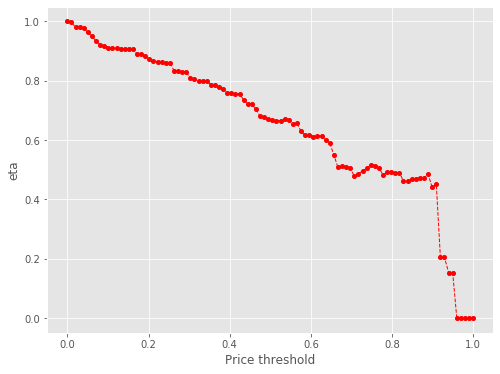

957 130
Number of cells with price above 33.0th percentile:  130


eta =  1.0
eta =  0.9838918992201741
eta =  0.980097851086504
eta =  0.9661274238227663
eta =  0.9661274238227663
eta =  0.9527673096391663
eta =  0.9260816322561743
eta =  0.9241574543360825
eta =  0.9151593006582057
eta =  0.9151593006582057
eta =  0.9139887926476236
eta =  0.9113685730233874
eta =  0.9113685730233874
eta =  0.9088902662008093
eta =  0.9088902662008093
eta =  0.9060624320321823
eta =  0.8928884190705398
eta =  0.8916729453446276
eta =  0.88537241808646
eta =  0.8755964329383242
eta =  0.8703621101935806
eta =  0.8674471774053493
eta =  0.8656545482438156
eta =  0.8633719623791949
eta =  0.8633719623791949
eta =  0.8373342689931349
eta =  0.8362252246552788
eta =  0.8323347041486633
eta =  0.818062268426915
eta =  0.8105869602167577
eta =  0.808724723886825
eta =  0.8015719747477835
eta =  0.8015719747477835
eta =  0.8005803697171099
eta =  0.7895031699122733
eta =  0.7868952502440371
eta =  0.7799875468575302
eta =  0.7746321340955318
eta =  0.759924064492064
eta =  

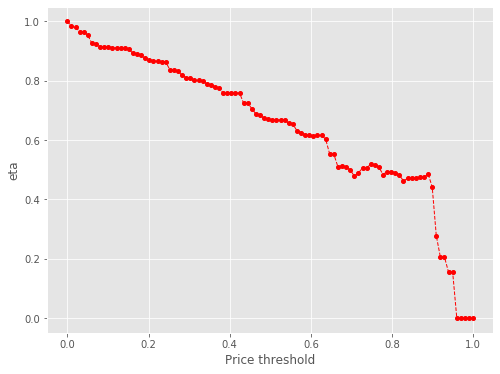

957 126
Number of cells with price above 34.0th percentile:  126


eta =  1.0
eta =  0.9961438363943466
eta =  0.9819446878142938
eta =  0.968365844250088
eta =  0.9567113832629752
eta =  0.9392875935542954
eta =  0.9342270561049257
eta =  0.9301421237267576
eta =  0.9289524523700671
eta =  0.9289524523700671
eta =  0.9262893349825645
eta =  0.9262893349825645
eta =  0.9237704537675221
eta =  0.9237704537675221
eta =  0.9075066272811445
eta =  0.9075066272811445
eta =  0.9001648835168505
eta =  0.8924210152778104
eta =  0.8899315398696909
eta =  0.8846115217367106
eta =  0.8798268884314705
eta =  0.8798268884314705
eta =  0.8775069324826209
eta =  0.8775069324826209
eta =  0.8510429546750006
eta =  0.8491944270669854
eta =  0.8459615378563093
eta =  0.8314554363902229
eta =  0.8238577437818355
eta =  0.8185694742210372
eta =  0.8146951665961515
eta =  0.8136873271867004
eta =  0.812047735969529
eta =  0.8024287734638614
eta =  0.7997781574050207
eta =  0.7927573623441183
eta =  0.7873142717299532
eta =  0.7723654042627799
eta =  0.7722470887657643
eta

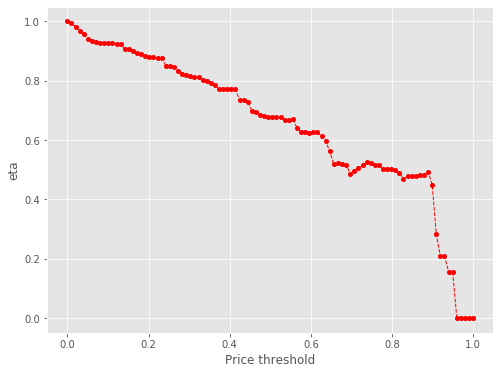

957 124
Number of cells with price above 35.0th percentile:  124


eta =  1.0
eta =  0.9857458852213067
eta =  0.9721144767157279
eta =  0.9568809578291829
eta =  0.9429236614605289
eta =  0.9378435342093412
eta =  0.9337427886855281
eta =  0.9325485120025576
eta =  0.9325485120025576
eta =  0.9298750854448607
eta =  0.9298750854448607
eta =  0.9273464534109974
eta =  0.9273464534109974
eta =  0.9110196681695744
eta =  0.9110196681695744
eta =  0.9036495038458476
eta =  0.9033510451073486
eta =  0.8933765459924915
eta =  0.8880359335843109
eta =  0.8832327785273477
eta =  0.8832327785273477
eta =  0.8809038418175179
eta =  0.8809038418175179
eta =  0.8543374195391754
eta =  0.8524817361122659
eta =  0.8492363320927239
eta =  0.8346740761853914
eta =  0.8270469722162617
eta =  0.8251469207796953
eta =  0.8178489258589715
eta =  0.8178489258589715
eta =  0.8168371850112854
eta =  0.805535048400582
eta =  0.80287417156533
eta =  0.7986011337706054
eta =  0.7903620370525252
eta =  0.7753553011565502
eta =  0.7752365276494593
eta =  0.7750333642735757
eta 

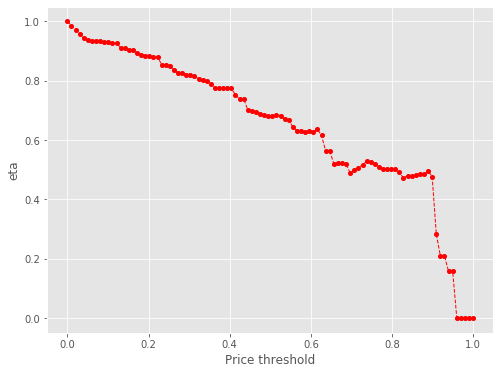

957 121
Number of cells with price above 36.00000000000001th percentile:  121


eta =  1.0
eta =  0.9861714781568492
eta =  0.9585501968175801
eta =  0.956558556923457
eta =  0.951404969850611
eta =  0.9472449265927155
eta =  0.9460333803911279
eta =  0.9433212954635843
eta =  0.9433212954635843
eta =  0.9407560988223671
eta =  0.9407560988223671
eta =  0.9407560988223671
eta =  0.9241932244688439
eta =  0.9241932244688439
eta =  0.9167164858547415
eta =  0.9088302287822814
eta =  0.9062949786413994
eta =  0.9008771397356031
eta =  0.8960045299393321
eta =  0.8960045299393321
eta =  0.8936419162629818
eta =  0.8936419162629818
eta =  0.8666913373393091
eta =  0.8648088202984259
eta =  0.8615164869819005
eta =  0.8467436574670574
eta =  0.8390062638005169
eta =  0.8370787371782374
eta =  0.8296752115534917
eta =  0.8296752115534917
eta =  0.8286488406978233
eta =  0.8193136081190078
eta =  0.8144839188297289
eta =  0.8101490919146104
eta =  0.8017908559416238
eta =  0.7865671191541191
eta =  0.7864466281544897
eta =  0.7864466281544897
eta =  0.7853448365416853
eta

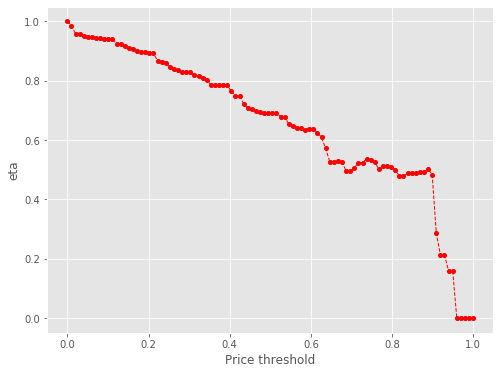

957 116
Number of cells with price above 37.0th percentile:  116


eta =  1.0
eta =  0.9854137588856213
eta =  0.9801047105556048
eta =  0.9758191769265145
eta =  0.9745710836572327
eta =  0.9745710836572327
eta =  0.9717771869495776
eta =  0.9717771869495776
eta =  0.9691346095075518
eta =  0.9691346095075518
eta =  0.9520721054334165
eta =  0.9520721054334165
eta =  0.9507760659680006
eta =  0.9440579182981399
eta =  0.9336339475489616
eta =  0.9280526760600853
eta =  0.9249445315958789
eta =  0.9230330808662801
eta =  0.9205991974340991
eta =  0.9205991974340991
eta =  0.9023922371452204
eta =  0.8928356370236046
eta =  0.8875046839884181
eta =  0.8875046839884181
eta =  0.8722862226028253
eta =  0.8643154254971616
eta =  0.85876746167685
eta =  0.8547028960784998
eta =  0.8547028960784998
eta =  0.851925456471002
eta =  0.8418341297417495
eta =  0.8390533482730823
eta =  0.8345877585257236
eta =  0.8259773910075199
eta =  0.8102944204423831
eta =  0.8101702947545228
eta =  0.8099579764152129
eta =  0.8090352668915406
eta =  0.8090352668915406
eta 

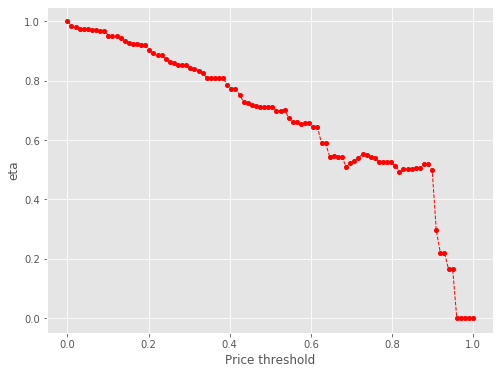

957 114
Number of cells with price above 38.0th percentile:  114


eta =  1.0
eta =  0.9902633976108096
eta =  0.988996829879207
eta =  0.988996829879207
eta =  0.9861615774966802
eta =  0.9861615774966802
eta =  0.9834798842300729
eta =  0.9834798842300729
eta =  0.980419979064174
eta =  0.9661648184312851
eta =  0.9661648184312851
eta =  0.9583485289213678
eta =  0.9501041229564843
eta =  0.9474537361897442
eta =  0.9417898498896503
eta =  0.9366959539007392
eta =  0.9366959539007392
eta =  0.9342260437637696
eta =  0.9342260437637696
eta =  0.9060515230001346
eta =  0.90485146306159
eta =  0.900641660404736
eta =  0.900641660404736
eta =  0.8771091510581233
eta =  0.8771091510581233
eta =  0.8714790654516613
eta =  0.8673543355484107
eta =  0.8662813527725632
eta =  0.864535783866487
eta =  0.8532439369015643
eta =  0.8499443958672727
eta =  0.8439985450508275
eta =  0.8382036312762633
eta =  0.8222885190467849
eta =  0.8221625560320198
eta =  0.8219470949250528
eta =  0.8210107273176878
eta =  0.8210107273176878
eta =  0.7984976101481873
eta =  0.

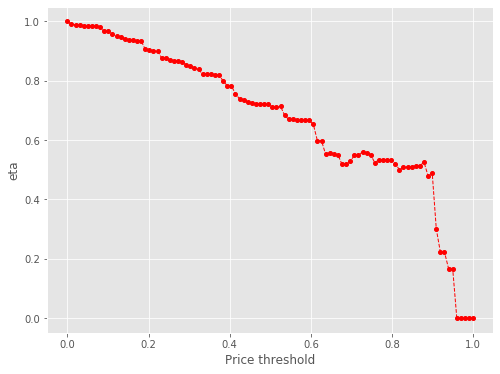

957 112
Number of cells with price above 39.0th percentile:  112


eta =  1.0
eta =  0.9987209789489762
eta =  0.9958578494125646
eta =  0.9958578494125646
eta =  0.9958578494125646
eta =  0.9931497888368861
eta =  0.9931497888368861
eta =  0.9756644754944324
eta =  0.9756644754944324
eta =  0.9677713336002903
eta =  0.9674516966059108
eta =  0.9567694196065899
eta =  0.9510498440736974
eta =  0.9478646797136404
eta =  0.9459058631882067
eta =  0.9434116680650417
eta =  0.9434116680650417
eta =  0.9247535388548492
eta =  0.9149601259484582
eta =  0.909497071766661
eta =  0.909497071766661
eta =  0.8939014965356785
eta =  0.8857331828827648
eta =  0.8857331828827648
eta =  0.8758824547499793
eta =  0.8758824547499793
eta =  0.8747989220470275
eta =  0.8730361901210695
eta =  0.8598451107671442
eta =  0.8583013346932926
eta =  0.8464451309606937
eta =  0.8464451309606937
eta =  0.8303735360013359
eta =  0.8302463344758944
eta =  0.8300287548829428
eta =  0.8290831805947038
eta =  0.8290831805947038
eta =  0.8063487068942545
eta =  0.7913940535427917
eta

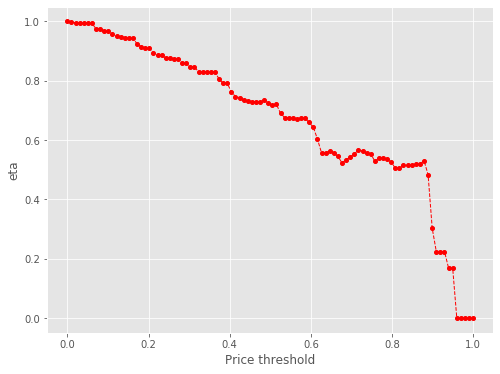

957 111
Number of cells with price above 40.0th percentile:  111


eta =  1.0
eta =  0.9971332037708623
eta =  0.9971332037708623
eta =  0.9944216750929243
eta =  0.9944216750929243
eta =  0.9769139690258557
eta =  0.9769139690258557
eta =  0.9755841127566216
eta =  0.9686906723677997
eta =  0.9579947150138622
eta =  0.9522678146548534
eta =  0.9522678146548534
eta =  0.9471172460837355
eta =  0.9471172460837355
eta =  0.9446198567470364
eta =  0.9446198567470364
eta =  0.9161318779058139
eta =  0.9149184665962031
eta =  0.9106618274142877
eta =  0.9106618274142877
eta =  0.8868675050912456
eta =  0.8868675050912456
eta =  0.881174781478421
eta =  0.8770041615344174
eta =  0.8759192411955135
eta =  0.8741542518109777
eta =  0.8637996179638671
eta =  0.8609462791820187
eta =  0.859400526057381
eta =  0.8475291385702812
eta =  0.8314369613775372
eta =  0.8314369613775372
eta =  0.8313095969503119
eta =  0.8301449534655875
eta =  0.8301449534655875
eta =  0.8301449534655875
eta =  0.8073813646558538
eta =  0.7924075594923728
eta =  0.787805634065384
eta 

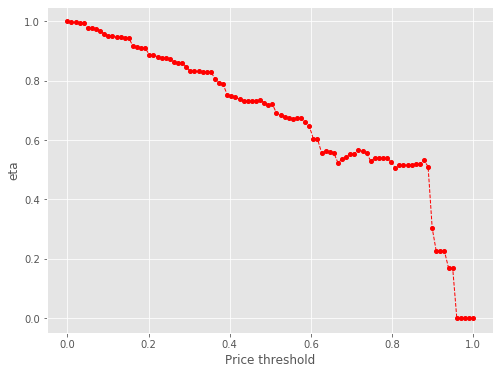

957 110
Number of cells with price above 41.0th percentile:  110


eta =  1.0
eta =  0.997280675573049
eta =  0.997280675573049
eta =  0.9797226341791212
eta =  0.9797226341791212
eta =  0.9783889545220754
eta =  0.9714756952275769
eta =  0.9607489865857541
eta =  0.9607489865857541
eta =  0.9550056211684244
eta =  0.9498402445149943
eta =  0.9498402445149943
eta =  0.9473356750881066
eta =  0.9473356750881066
eta =  0.9187657922143947
eta =  0.9175488923007002
eta =  0.913280015117774
eta =  0.913280015117774
eta =  0.8976195719730201
eta =  0.8894172832048671
eta =  0.8837081927931786
eta =  0.8795255821567745
eta =  0.8795255821567745
eta =  0.8784375426302587
eta =  0.8766674788335053
eta =  0.863421532776338
eta =  0.8618713355521437
eta =  0.8499658173704147
eta =  0.8499658173704147
eta =  0.8338273745506507
eta =  0.8336996439458092
eta =  0.8334811593567889
eta =  0.832531652066369
eta =  0.832531652066369
eta =  0.809702617065179
eta =  0.7946857616371837
eta =  0.7946857616371837
eta =  0.7871829553913721
eta =  0.755052565551765
eta =  0.7

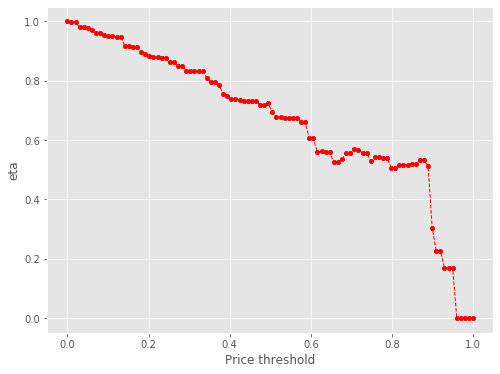

957 109
Number of cells with price above 42.00000000000001th percentile:  109


eta =  1.0
eta =  0.9823940824042954
eta =  0.9823940824042954
eta =  0.9744464978779109
eta =  0.9741246562000772
eta =  0.9633686986200717
eta =  0.9576096725424537
eta =  0.9544025386379222
eta =  0.9524302112534219
eta =  0.9499188125186087
eta =  0.9499188125186087
eta =  0.9499188125186087
eta =  0.9212710270220179
eta =  0.9200508089394854
eta =  0.9157702916413103
eta =  0.9157702916413103
eta =  0.9000671465505311
eta =  0.8918424922791146
eta =  0.8861178346661431
eta =  0.8819238191408741
eta =  0.8819238191408741
eta =  0.8808328128142044
eta =  0.8790579225149049
eta =  0.8675763994598983
eta =  0.8642214340079362
eta =  0.858175707082774
eta =  0.8522834525817062
eta =  0.8361010044354101
eta =  0.8359729255425067
eta =  0.8359729255425067
eta =  0.8348017488536883
eta =  0.8348017488536883
eta =  0.8348017488536883
eta =  0.8119104650252192
eta =  0.796852662547129
eta =  0.7922249220802301
eta =  0.7571113970677343
eta =  0.7517498318288631
eta =  0.7484208391244099
eta

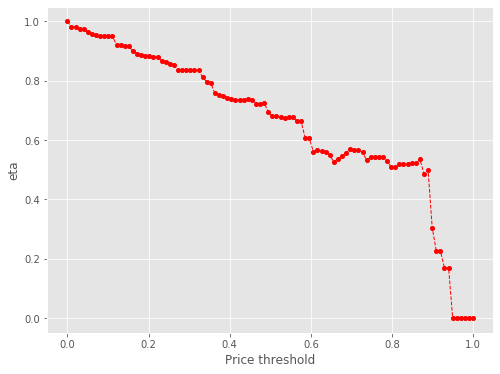

957 109
Number of cells with price above 43.0th percentile:  109


eta =  1.0
eta =  0.9823940824042954
eta =  0.9823940824042954
eta =  0.9744464978779109
eta =  0.9741246562000772
eta =  0.9633686986200717
eta =  0.9576096725424537
eta =  0.9544025386379222
eta =  0.9524302112534219
eta =  0.9499188125186087
eta =  0.9499188125186087
eta =  0.9499188125186087
eta =  0.9212710270220179
eta =  0.9200508089394854
eta =  0.9157702916413103
eta =  0.9157702916413103
eta =  0.9000671465505311
eta =  0.8918424922791146
eta =  0.8861178346661431
eta =  0.8819238191408741
eta =  0.8819238191408741
eta =  0.8808328128142044
eta =  0.8790579225149049
eta =  0.8675763994598983
eta =  0.8642214340079362
eta =  0.858175707082774
eta =  0.8522834525817062
eta =  0.8361010044354101
eta =  0.8359729255425067
eta =  0.8359729255425067
eta =  0.8348017488536883
eta =  0.8348017488536883
eta =  0.8348017488536883
eta =  0.8119104650252192
eta =  0.796852662547129
eta =  0.7922249220802301
eta =  0.7571113970677343
eta =  0.7517498318288631
eta =  0.7484208391244099
eta

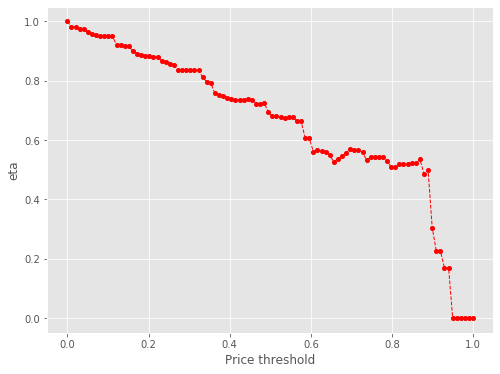

957 107
Number of cells with price above 44.0th percentile:  107


eta =  1.0
eta =  0.9919099833063595
eta =  0.9833768574797851
eta =  0.9806336539226079
eta =  0.9747714177988687
eta =  0.9715068074332582
eta =  0.9694991330998856
eta =  0.9669427264807956
eta =  0.9669427264807956
eta =  0.9669427264807956
eta =  0.9377815313863802
eta =  0.9365394452374631
eta =  0.9321822149010395
eta =  0.9321822149010395
eta =  0.9161976468218551
eta =  0.9078255948940915
eta =  0.9057399632629062
eta =  0.8977291648403135
eta =  0.8977291648403135
eta =  0.8966186061081195
eta =  0.8948119072170231
eta =  0.8831246187238891
eta =  0.8812918091861498
eta =  0.8766014189080671
eta =  0.867557600200361
eta =  0.8510851392642249
eta =  0.8510851392642249
eta =  0.8509547650129977
eta =  0.8507317584380772
eta =  0.8497625991502392
eta =  0.8497625991502392
eta =  0.8264610705290109
eta =  0.8111334105320798
eta =  0.8111334105320798
eta =  0.79085769097692
eta =  0.7706799243077607
eta =  0.7652222720937435
eta =  0.7618336190429169
eta =  0.7548286298792637
eta 

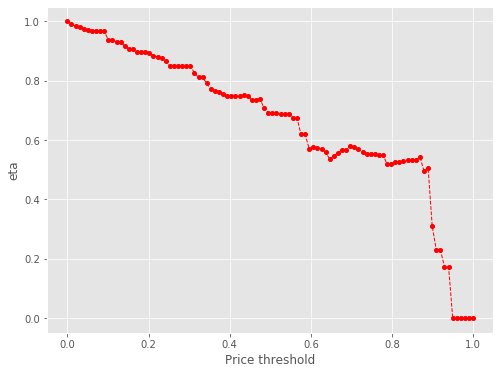

957 104
Number of cells with price above 45.0th percentile:  104


eta =  1.0
eta =  0.991397278008907
eta =  0.9886317008866431
eta =  0.9827216523717582
eta =  0.9794304158477257
eta =  0.9774063669247776
eta =  0.9748291102562151
eta =  0.9748291102562151
eta =  0.9748291102562151
eta =  0.9454300764878367
eta =  0.9441778598857044
eta =  0.9397850919836215
eta =  0.9397850919836215
eta =  0.9236701537853965
eta =  0.9152298194116494
eta =  0.9152298194116494
eta =  0.9093550406265255
eta =  0.9050510428858569
eta =  0.9039314264379086
eta =  0.9021099921127149
eta =  0.8914242136716727
eta =  0.8884796241777069
eta =  0.8868844373600643
eta =  0.8746333989990792
eta =  0.8746333989990792
eta =  0.8580265886903171
eta =  0.8578951511068453
eta =  0.857670325690554
eta =  0.8566932619406686
eta =  0.8566932619406686
eta =  0.8332016860785558
eta =  0.8177490137041544
eta =  0.8177490137041544
eta =  0.8129999171893875
eta =  0.7769655888922835
eta =  0.7714634240730274
eta =  0.7680471331717794
eta =  0.7609850113244891
eta =  0.7563637954662623
eta

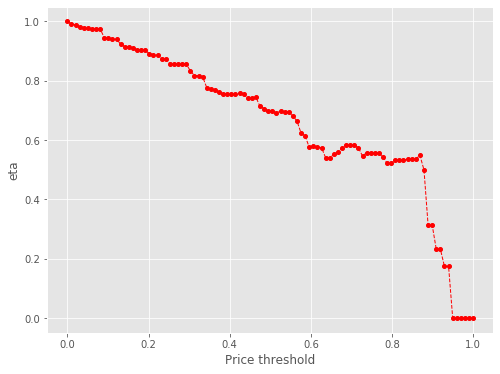

957 101
Number of cells with price above 46.0th percentile:  101


eta =  1.0
eta =  0.9940219916986432
eta =  0.9886455856596564
eta =  0.9886455856596564
eta =  0.9860386930562217
eta =  0.9860386930562217
eta =  0.9665375166726115
eta =  0.9563015991090904
eta =  0.9542244420186856
eta =  0.9505917027956781
eta =  0.9505917027956781
eta =  0.9257540685685437
eta =  0.9257540685685437
eta =  0.9198117355643974
eta =  0.9154582460527739
eta =  0.9154582460527739
eta =  0.9143257551090339
eta =  0.9124833760678196
eta =  0.9016747216098867
eta =  0.8986962722122749
eta =  0.8970827423040068
eta =  0.8846908289656038
eta =  0.8846908289656038
eta =  0.8678930565556472
eta =  0.8677601075683208
eta =  0.867532696879295
eta =  0.8665443978504361
eta =  0.8665443978504361
eta =  0.8665443978504361
eta =  0.8427826918065731
eta =  0.8271523287901507
eta =  0.8271523287901507
eta =  0.7974352291972735
eta =  0.7803345000783903
eta =  0.7803345000783903
eta =  0.7697355958159225
eta =  0.7697355958159225
eta =  0.7650612404881677
eta =  0.7629294795905874
et

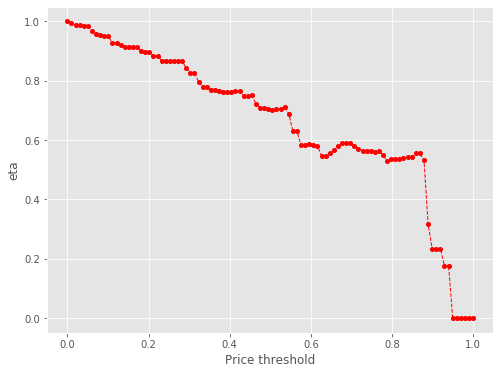

957 100
Number of cells with price above 47.0th percentile:  100


eta =  1.0
eta =  0.9945912604712103
eta =  0.9945912604712103
eta =  0.9919686901204479
eta =  0.9919686901204479
eta =  0.9723502344459556
eta =  0.9620527584856609
eta =  0.9599631094560099
eta =  0.9563085230853404
eta =  0.9563085230853404
eta =  0.931321516324363
eta =  0.931321516324363
eta =  0.9253434463683938
eta =  0.9209637751458446
eta =  0.9209637751458446
eta =  0.9198244734470918
eta =  0.9179710144123817
eta =  0.9070973571410146
eta =  0.9041009954684502
eta =  0.9024777618561729
eta =  0.8900113240490707
eta =  0.8900113240490707
eta =  0.873112530511061
eta =  0.8729787819738689
eta =  0.8729787819738689
eta =  0.8717557610266088
eta =  0.8717557610266088
eta =  0.8717557610266088
eta =  0.8478511530377477
eta =  0.8321267896464384
eta =  0.8321267896464384
eta =  0.811326303311966
eta =  0.7906263050347054
eta =  0.7850274003947426
eta =  0.7743647547480846
eta =  0.7743647547480846
eta =  0.7696622880352838
eta =  0.767517706813356
eta =  0.767517706813356
eta =  

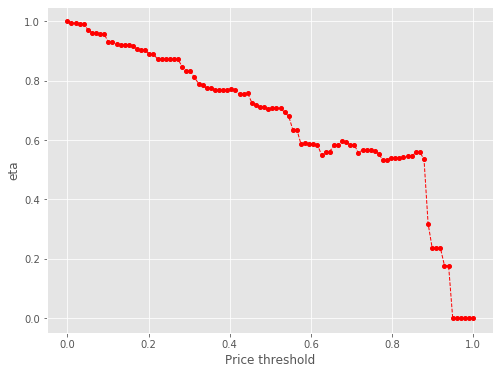

957 98
Number of cells with price above 48.00000000000001th percentile:  98


eta =  1.0
eta =  0.997363167710201
eta =  0.997363167710201
eta =  0.9672845486595835
eta =  0.9672845486595835
eta =  0.9651835357986209
eta =  0.9615090752278153
eta =  0.9615090752278153
eta =  0.9363861852990023
eta =  0.9363861852990023
eta =  0.9303756056834758
eta =  0.9259721171383681
eta =  0.9259721171383681
eta =  0.9248266197425705
eta =  0.9229630813138978
eta =  0.9120302914297241
eta =  0.9090176350836944
eta =  0.907385574078545
eta =  0.8948513418742566
eta =  0.8948513418742566
eta =  0.8778606501100805
eta =  0.8777261742278686
eta =  0.8777261742278686
eta =  0.8764965023054744
eta =  0.8764965023054744
eta =  0.8764965023054744
eta =  0.8524618973989968
eta =  0.8366520225124434
eta =  0.8366520225124434
eta =  0.8287530033993474
eta =  0.794925851912401
eta =  0.7892964995719126
eta =  0.7858012380135122
eta =  0.7785758688259655
eta =  0.7785758688259655
eta =  0.773847829379316
eta =  0.7716915855964057
eta =  0.7716915855964057
eta =  0.7716915855964057
eta = 

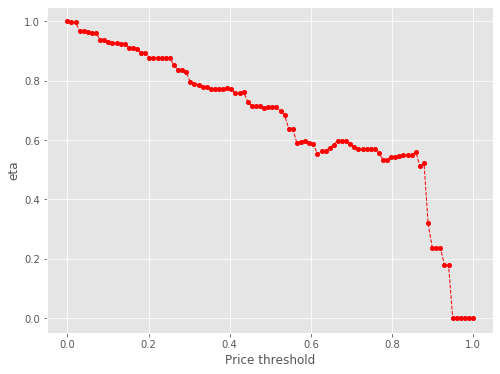

957 97
Number of cells with price above 49.0th percentile:  97


eta =  1.0
eta =  0.9698418589893654
eta =  0.9685573091242067
eta =  0.9640511163403984
eta =  0.9640511163403984
eta =  0.9475200771780683
eta =  0.938861806425845
eta =  0.938861806425845
eta =  0.9328353360185551
eta =  0.9284202055147713
eta =  0.9284202055147713
eta =  0.9272716796488848
eta =  0.925403214390687
eta =  0.9144415203577363
eta =  0.9114208991401448
eta =  0.9097845232863059
eta =  0.8972171530343391
eta =  0.8972171530343391
eta =  0.8801815412188514
eta =  0.8800467098088239
eta =  0.8800467098088239
eta =  0.8788137868754281
eta =  0.8788137868754281
eta =  0.8788137868754281
eta =  0.8547156391950225
eta =  0.838863966105018
eta =  0.838863966105018
eta =  0.8339922440105487
eta =  0.7970274797067488
eta =  0.7913832444645227
eta =  0.7913832444645227
eta =  0.7806342704768827
eta =  0.7806342704768827
eta =  0.7758937310227293
eta =  0.7737317865548374
eta =  0.7737317865548374
eta =  0.7737317865548374
eta =  0.7779421978385913
eta =  0.7742100118641545
eta = 

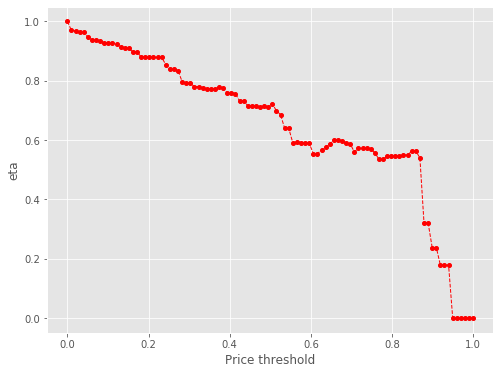

957 94
Number of cells with price above 50.0th percentile:  94


eta =  1.0
eta =  0.9940291887844465
eta =  0.9940291887844465
eta =  0.9940291887844465
eta =  0.9680565936844555
eta =  0.9680565936844555
eta =  0.9618427245351387
eta =  0.9572903014128943
eta =  0.9572903014128943
eta =  0.9561060610594377
eta =  0.9541794941239325
eta =  0.9453349454654201
eta =  0.9397623856840961
eta =  0.9380751251903656
eta =  0.9315127491383315
eta =  0.925116960789148
eta =  0.9075516106677994
eta =  0.9075516106677994
eta =  0.9074125865487869
eta =  0.9071747842809275
eta =  0.9061413247219561
eta =  0.9061413247219561
eta =  0.9061413247219561
eta =  0.8812938225678241
eta =  0.8649492268555675
eta =  0.8649492268555675
eta =  0.843328285435251
eta =  0.8218117957264706
eta =  0.8159920477026971
eta =  0.812378569576489
eta =  0.8049088243008519
eta =  0.8049088243008519
eta =  0.8000208733321308
eta =  0.7977917011760178
eta =  0.7977917011760178
eta =  0.7977917011760178
eta =  0.8021330391423348
eta =  0.7992382381187285
eta =  0.7835220935823377
eta 

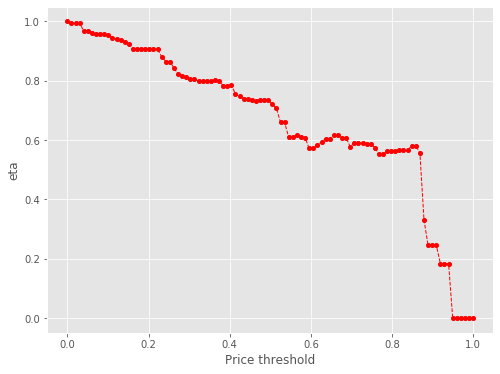

957 91
Number of cells with price above 51.0th percentile:  91


eta =  1.0
eta =  0.9738713959378278
eta =  0.9738713959378278
eta =  0.967620202090175
eta =  0.9630404340374767
eta =  0.9630404340374767
eta =  0.9618490803359777
eta =  0.9618490803359777
eta =  0.9510132661410351
eta =  0.9454072337989282
eta =  0.9454072337989282
eta =  0.9403756099349386
eta =  0.930673838582579
eta =  0.930673838582579
eta =  0.913002979095215
eta =  0.9128631199033711
eta =  0.9128631199033711
eta =  0.911584222018707
eta =  0.911584222018707
eta =  0.911584222018707
eta =  0.8865874689711261
eta =  0.8701446965689962
eta =  0.8701446965689962
eta =  0.8701446965689962
eta =  0.8483938851599712
eta =  0.8267481528700653
eta =  0.8208934475058394
eta =  0.8172582643874977
eta =  0.8097436507726082
eta =  0.807894160736846
eta =  0.8048263394663896
eta =  0.8025837773955122
eta =  0.8025837773955122
eta =  0.8025837773955122
eta =  0.8069511923721547
eta =  0.8040390032168784
eta =  0.7882284568931739
eta =  0.7882284568931739
eta =  0.7851092063351458
eta =  0.

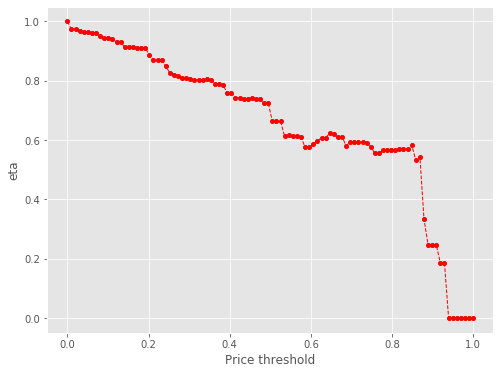

957 91
Number of cells with price above 52.0th percentile:  91


eta =  1.0
eta =  0.9738713959378278
eta =  0.9738713959378278
eta =  0.967620202090175
eta =  0.9630404340374767
eta =  0.9630404340374767
eta =  0.9618490803359777
eta =  0.9618490803359777
eta =  0.9510132661410351
eta =  0.9454072337989282
eta =  0.9454072337989282
eta =  0.9403756099349386
eta =  0.930673838582579
eta =  0.930673838582579
eta =  0.913002979095215
eta =  0.9128631199033711
eta =  0.9128631199033711
eta =  0.911584222018707
eta =  0.911584222018707
eta =  0.911584222018707
eta =  0.8865874689711261
eta =  0.8701446965689962
eta =  0.8701446965689962
eta =  0.8701446965689962
eta =  0.8483938851599712
eta =  0.8267481528700653
eta =  0.8208934475058394
eta =  0.8172582643874977
eta =  0.8097436507726082
eta =  0.807894160736846
eta =  0.8048263394663896
eta =  0.8025837773955122
eta =  0.8025837773955122
eta =  0.8025837773955122
eta =  0.8069511923721547
eta =  0.8040390032168784
eta =  0.7882284568931739
eta =  0.7882284568931739
eta =  0.7851092063351458
eta =  0.

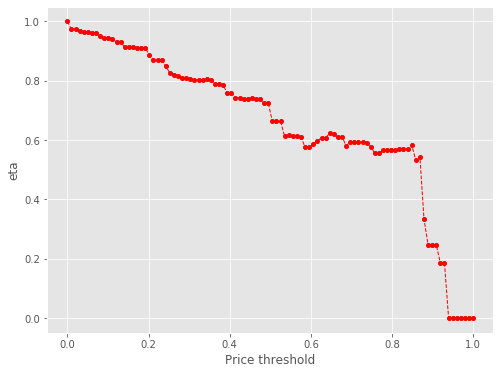

957 89
Number of cells with price above 53.0th percentile:  89


eta =  1.0
eta =  0.9935810889674678
eta =  0.9888784474566881
eta =  0.9888784474566881
eta =  0.9876551301824891
eta =  0.985664991436393
eta =  0.9739894775770309
eta =  0.9707721550734233
eta =  0.9690292192732458
eta =  0.9556434683928159
eta =  0.9556434683928159
eta =  0.9374985063772232
eta =  0.9374985063772232
eta =  0.937354894815751
eta =  0.9371092456776625
eta =  0.9360416845808076
eta =  0.9360416845808076
eta =  0.9360416845808076
eta =  0.910374278030162
eta =  0.8934903522154032
eta =  0.8934903522154032
eta =  0.8883013861065192
eta =  0.871588593158194
eta =  0.8489294955356149
eta =  0.8429177106237191
eta =  0.8391849969065851
eta =  0.8314687690286187
eta =  0.8264195281055055
eta =  0.8264195281055055
eta =  0.824116798935893
eta =  0.824116798935893
eta =  0.824116798935893
eta =  0.8286013900172818
eta =  0.8246261660291584
eta =  0.8082473953116736
eta =  0.809376330571983
eta =  0.8061733916921279
eta =  0.813274631189944
eta =  0.7795797278981599
eta =  0.7

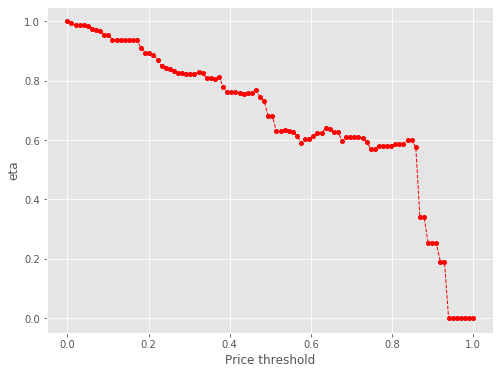

957 86
Number of cells with price above 54.0th percentile:  86


eta =  1.0
eta =  0.9987629245259159
eta =  0.9967504034206025
eta =  0.9837316791205929
eta =  0.9816900727993085
eta =  0.9799275348406138
eta =  0.9663912393385155
eta =  0.9663912393385155
eta =  0.9480422076023501
eta =  0.9480422076023501
eta =  0.9478969808944149
eta =  0.9478969808944149
eta =  0.9465690014664875
eta =  0.9465690014664875
eta =  0.9465690014664875
eta =  0.9206129230256437
eta =  0.9035391099011055
eta =  0.9035391099011055
eta =  0.9035391099011055
eta =  0.880953545847646
eta =  0.8584770936397592
eta =  0.8523976963919401
eta =  0.8523976963919401
eta =  0.8408199927575388
eta =  0.8408199927575388
eta =  0.8357139648770653
eta =  0.833385337758601
eta =  0.833385337758601
eta =  0.833385337758601
eta =  0.833385337758601
eta =  0.8379203653880561
eta =  0.8348964122368191
eta =  0.8184790887632657
eta =  0.8184790887632657
eta =  0.8152401276067224
eta =  0.8224212321358786
eta =  0.7883473746476861
eta =  0.7803440134734531
eta =  0.7718195202449788
eta = 

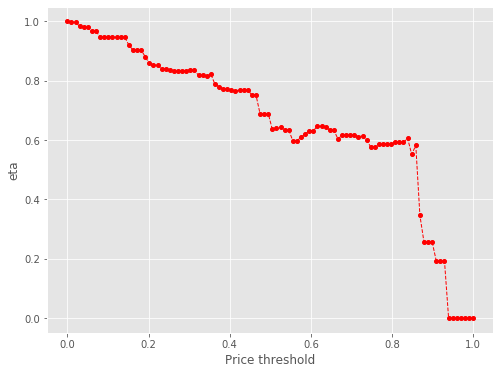

957 85
Number of cells with price above 55.00000000000001th percentile:  85


eta =  1.0
eta =  0.9979849861704982
eta =  0.9849501367779968
eta =  0.9829060017073508
eta =  0.9811412806555242
eta =  0.9675882189932448
eta =  0.9675882189932448
eta =  0.9492164600046188
eta =  0.9492164600046188
eta =  0.9490710534177612
eta =  0.948822333869225
eta =  0.9477414291442552
eta =  0.9477414291442552
eta =  0.9477414291442552
eta =  0.9217532013041355
eta =  0.9046582404227607
eta =  0.9046582404227607
eta =  0.9046582404227607
eta =  0.8820447017151837
eta =  0.8595404099999544
eta =  0.8534534827637388
eta =  0.8534534827637388
eta =  0.8418614388961744
eta =  0.8418614388961744
eta =  0.8367490866501224
eta =  0.8344175752761198
eta =  0.8344175752761198
eta =  0.8344175752761198
eta =  0.8344175752761198
eta =  0.8389582200258313
eta =  0.8359305213828602
eta =  0.8194928632856233
eta =  0.8194928632856233
eta =  0.8162498903267694
eta =  0.8234398894274718
eta =  0.789323827796163
eta =  0.7813105535969509
eta =  0.7727755018653094
eta =  0.7727755018653094
eta

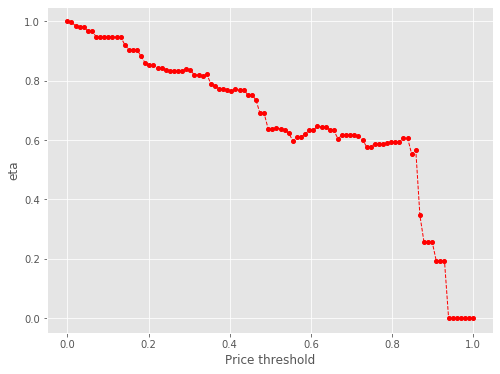

957 83
Number of cells with price above 56.00000000000001th percentile:  83


eta =  1.0
eta =  0.9941052006930937
eta =  0.9923203724670517
eta =  0.9888143976694865
eta =  0.9786128876614012
eta =  0.9786128876614012
eta =  0.9600318014489366
eta =  0.9600318014489366
eta =  0.959884738104162
eta =  0.9596331846531866
eta =  0.9585399641349684
eta =  0.9585399641349684
eta =  0.9585399641349684
eta =  0.9322556272728643
eta =  0.9149658869637196
eta =  0.9149658869637196
eta =  0.9149658869637196
eta =  0.892094690332274
eta =  0.8693339854498504
eta =  0.8631777039628603
eta =  0.8631777039628603
eta =  0.8514535807248386
eta =  0.8514535807248386
eta =  0.8462829785037236
eta =  0.843924901965026
eta =  0.843924901965026
eta =  0.843924901965026
eta =  0.843924901965026
eta =  0.8485172826731988
eta =  0.8444465119780767
eta =  0.8276740684483384
eta =  0.8288301382919718
eta =  0.8288301382919718
eta =  0.8328221367211882
eta =  0.798317357794273
eta =  0.7902127806097009
eta =  0.7815804807764808
eta =  0.7815804807764808
eta =  0.7781647350786329
eta =  0

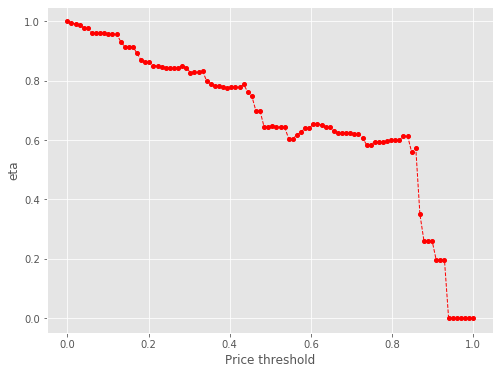

957 79
Number of cells with price above 57.00000000000001th percentile:  79


eta =  1.0
eta =  0.9861864321382704
eta =  0.9861864321382704
eta =  0.9674615457729231
eta =  0.9674615457729231
eta =  0.9673133442960059
eta =  0.9673133442960059
eta =  0.965958163039523
eta =  0.965958163039523
eta =  0.965958163039523
eta =  0.9610765289557739
eta =  0.9394704101006636
eta =  0.9220468634428842
eta =  0.9220468634428842
eta =  0.9166920547274405
eta =  0.8889204881471632
eta =  0.8760618138762591
eta =  0.8698578885535485
eta =  0.8660058749683095
eta =  0.8580430316148827
eta =  0.8580430316148827
eta =  0.8528324137896534
eta =  0.8504560879536384
eta =  0.8504560879536384
eta =  0.8504560879536384
eta =  0.8504560879536384
eta =  0.8550840093745756
eta =  0.8509817347382084
eta =  0.834079488250978
eta =  0.8352445049892309
eta =  0.8352445049892309
eta =  0.8392673977363502
eta =  0.8044955842330848
eta =  0.7963282852342514
eta =  0.7876291795091931
eta =  0.7876291795091931
eta =  0.7876291795091931
eta =  0.7812251536403653
eta =  0.7812251536403653
eta =

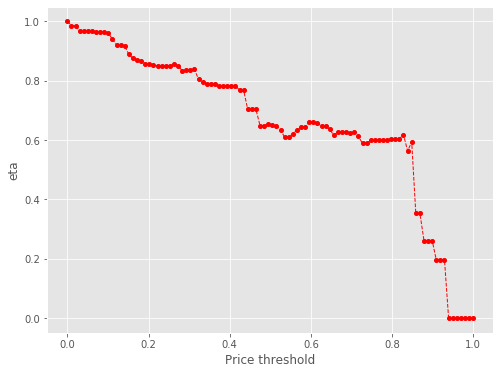

957 76
Number of cells with price above 58.00000000000001th percentile:  76


eta =  1.0
eta =  0.9810128331164042
eta =  0.9808625557732087
eta =  0.9808625557732087
eta =  0.9806055047429728
eta =  0.979488392417965
eta =  0.979488392417965
eta =  0.979488392417965
eta =  0.9526296240597063
eta =  0.9349620248208877
eta =  0.9349620248208877
eta =  0.9349620248208877
eta =  0.9115909892256984
eta =  0.8883328601233778
eta =  0.8820420360757795
eta =  0.8820420360757795
eta =  0.8781360671233502
eta =  0.8700616877829637
eta =  0.8700616877829637
eta =  0.8647780845458642
eta =  0.862368473382524
eta =  0.862368473382524
eta =  0.862368473382524
eta =  0.862368473382524
eta =  0.8670612183545907
eta =  0.8639320993930955
eta =  0.8457624857426898
eta =  0.8469438209347862
eta =  0.8469438209347862
eta =  0.8510230625629607
eta =  0.8157641983461082
eta =  0.8157641983461082
eta =  0.7986615449590386
eta =  0.7986615449590386
eta =  0.7986615449590386
eta =  0.7951711497875521
eta =  0.792167817545914
eta =  0.7964559406928539
eta =  0.794881870481003
eta =  0.7

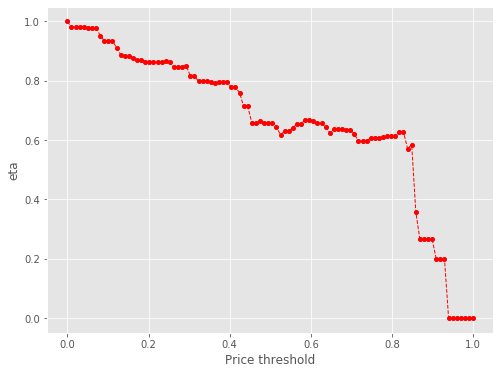

957 75
Number of cells with price above 59.0th percentile:  75


eta =  1.0
eta =  0.9998468140903741
eta =  0.9995847879256203
eta =  0.9984460542747474
eta =  0.9984460542747474
eta =  0.9984460542747474
eta =  0.9710674436678546
eta =  0.9710674436678546
eta =  0.9530578941060068
eta =  0.9530578941060068
eta =  0.9475229881049981
eta =  0.9296959805581718
eta =  0.9055262379202441
eta =  0.8991136571310467
eta =  0.8951320894893463
eta =  0.8869014333064535
eta =  0.8869014333064535
eta =  0.8815155677410512
eta =  0.8815155677410512
eta =  0.8790593193801755
eta =  0.8790593193801755
eta =  0.8790593193801755
eta =  0.8790593193801755
eta =  0.8838428908214983
eta =  0.8806532088358355
eta =  0.8633361280751871
eta =  0.8633361280751871
eta =  0.8599196544935573
eta =  0.867494322025837
eta =  0.8315530345863599
eta =  0.8231110463393662
eta =  0.8141193652094373
eta =  0.8141193652094373
eta =  0.8141193652094373
eta =  0.8105614146366619
eta =  0.8074999539296727
eta =  0.8102665364283614
eta =  0.8102665364283614
eta =  0.8102665364283614
et

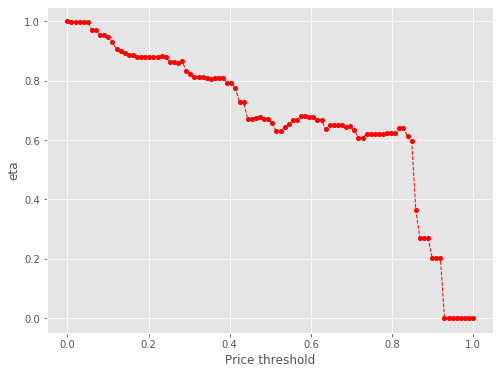

957 73
Number of cells with price above 60.0th percentile:  73


eta =  1.0
eta =  0.9988607933367653
eta =  0.9988607933367653
eta =  0.9988607933367653
eta =  0.9714708100781064
eta =  0.9534537796276712
eta =  0.9534537796276712
eta =  0.9534537796276712
eta =  0.9479165745122403
eta =  0.919199048134811
eta =  0.9059023795264328
eta =  0.8994871350502688
eta =  0.895503913526897
eta =  0.8872698384566137
eta =  0.8872698384566137
eta =  0.8818817356858829
eta =  0.8818817356858829
eta =  0.8794244670373944
eta =  0.8794244670373944
eta =  0.8794244670373944
eta =  0.8794244670373944
eta =  0.8842100255003735
eta =  0.881019018570104
eta =  0.8636947445617075
eta =  0.8636947445617075
eta =  0.8636947445617075
eta =  0.8678546657618681
eta =  0.8318984488669873
eta =  0.8318984488669873
eta =  0.8144575378132068
eta =  0.8144575378132068
eta =  0.8144575378132068
eta =  0.8108981093227443
eta =  0.807835376932286
eta =  0.8122083109268425
eta =  0.8106031086265929
eta =  0.8106031086265929
eta =  0.8208780394006132
eta =  0.7943139496826026
eta =

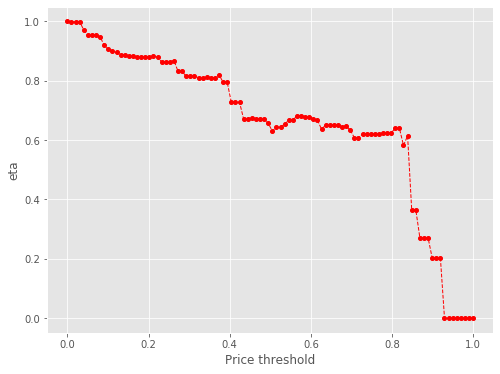

957 72
Number of cells with price above 61.0th percentile:  72


eta =  1.0
eta =  0.9725787783028698
eta =  0.9545411993222712
eta =  0.9545411993222712
eta =  0.9545411993222712
eta =  0.9306807475026272
eta =  0.9069355665669905
eta =  0.9005130054664257
eta =  0.9005130054664257
eta =  0.8965252410552652
eta =  0.8882817749734935
eta =  0.8882817749734935
eta =  0.8828875270395732
eta =  0.8804274558616066
eta =  0.8804274558616066
eta =  0.8804274558616066
eta =  0.8804274558616066
eta =  0.8804274558616066
eta =  0.8852184722824161
eta =  0.8820238259898034
eta =  0.8634737198414781
eta =  0.8646797935440773
eta =  0.8646797935440773
eta =  0.8688444591590566
eta =  0.8328472339854
eta =  0.8328472339854
eta =  0.8243921069298619
eta =  0.8153864314690475
eta =  0.8153864314690475
eta =  0.8153864314690475
eta =  0.8087567179743382
eta =  0.8087567179743382
eta =  0.8131346393260698
eta =  0.8115276062830695
eta =  0.8115276062830695
eta =  0.8159037042176753
eta =  0.7952198694566242
eta =  0.780519662395202
eta =  0.728211737436625
eta =  0.

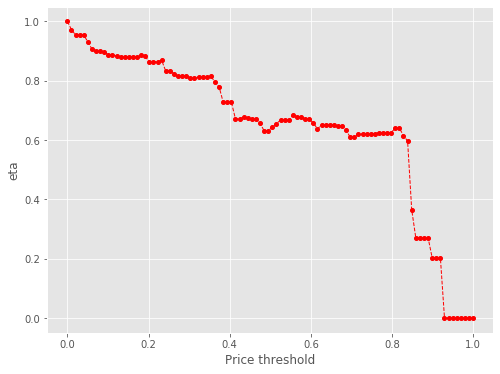

957 70
Number of cells with price above 62.0th percentile:  70


eta =  1.0
eta =  0.9814538632931373
eta =  0.9814538632931373
eta =  0.9757540470372215
eta =  0.9569206816610232
eta =  0.9325060208999981
eta =  0.925902379895439
eta =  0.925902379895439
eta =  0.9218021830783555
eta =  0.9133262978691836
eta =  0.9133262978691836
eta =  0.9077799626475441
eta =  0.9052505313738541
eta =  0.9052505313738541
eta =  0.9052505313738541
eta =  0.9052505313738541
eta =  0.9052505313738541
eta =  0.9101766273649364
eta =  0.9068919101123275
eta =  0.8890588740306734
eta =  0.8890588740306734
eta =  0.8890588740306734
eta =  0.8933409596651621
eta =  0.8563288163028825
eta =  0.8563288163028825
eta =  0.8476353024774089
eta =  0.8383757178949354
eta =  0.8383757178949354
eta =  0.8383757178949354
eta =  0.8347117596436562
eta =  0.8315590839701461
eta =  0.8360604379472203
eta =  0.8344080956600438
eta =  0.8344080956600438
eta =  0.8389075748099406
eta =  0.8176405728739699
eta =  0.8025259031018475
eta =  0.7487431904563451
eta =  0.7487431904563451
eta

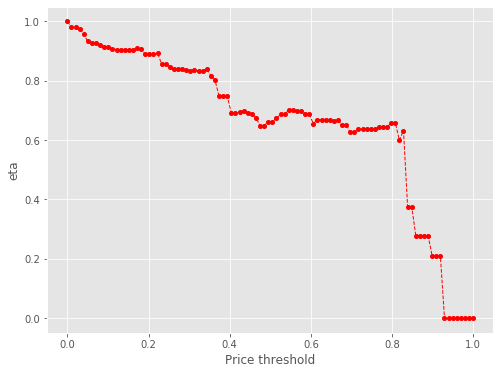

957 69
Number of cells with price above 63.0th percentile:  69


eta =  1.0
eta =  0.9750032247569984
eta =  0.9501272100260513
eta =  0.9433987826882634
eta =  0.9433987826882634
eta =  0.9392211061102469
eta =  0.9305850555263385
eta =  0.9305850555263385
eta =  0.9249339134512241
eta =  0.9249339134512241
eta =  0.9223566845377804
eta =  0.9223566845377804
eta =  0.9223566845377804
eta =  0.9223566845377804
eta =  0.9273758669724529
eta =  0.9229267713797955
eta =  0.9240290797464211
eta =  0.9058590599944812
eta =  0.9058590599944812
eta =  0.9076103862813913
eta =  0.9102220624693207
eta =  0.8725105156034392
eta =  0.8725105156034392
eta =  0.8542181647559852
eta =  0.8542181647559852
eta =  0.8542181647559852
eta =  0.850484970167515
eta =  0.8472727196568983
eta =  0.8472727196568983
eta =  0.8518591338995103
eta =  0.8501755679684209
eta =  0.8501755679684209
eta =  0.8609521058495048
eta =  0.8330911960858621
eta =  0.8330911960858621
eta =  0.7628918876981515
eta =  0.7628918876981515
eta =  0.7628918876981515
eta =  0.7039028856829432
et

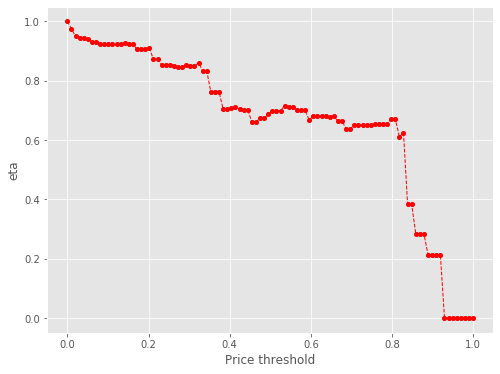

957 63
Number of cells with price above 64.0th percentile:  63


eta =  1.0
eta =  0.9929183931722118
eta =  0.9885214276565079
eta =  0.9794320652082188
eta =  0.9794320652082188
eta =  0.9771949993867328
eta =  0.9734842910412633
eta =  0.9707717817201452
eta =  0.9707717817201452
eta =  0.9707717817201452
eta =  0.9707717817201452
eta =  0.9707717817201452
eta =  0.9760544242775926
eta =  0.9725319620317846
eta =  0.965017438143451
eta =  0.9534081862255515
eta =  0.9534081862255515
eta =  0.9496352711640548
eta =  0.958000205513916
eta =  0.9183091552335565
eta =  0.9183091552335565
eta =  0.8990566270937169
eta =  0.8990566270937169
eta =  0.8990566270937169
eta =  0.8951274747138288
eta =  0.8917466111023883
eta =  0.8917466111023883
eta =  0.8965737691862897
eta =  0.8948018317937764
eta =  0.8948018317937764
eta =  0.9061440370978309
eta =  0.8768206902137028
eta =  0.8768206902137028
eta =  0.8029365748584697
eta =  0.8029365748584697
eta =  0.8029365748584697
eta =  0.7907291983463033
eta =  0.7408512020865533
eta =  0.7408512020865533
eta

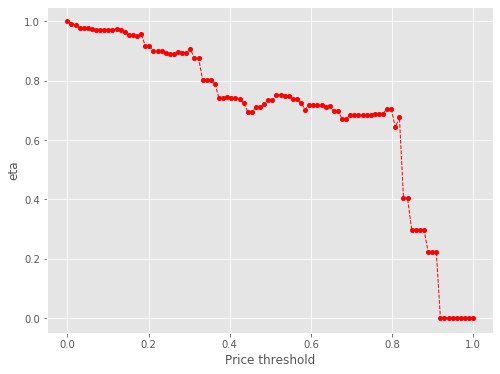

957 61
Number of cells with price above 65.0th percentile:  61


eta =  1.0
eta =  0.9908050931482212
eta =  0.9908050931482212
eta =  0.9847882542608175
eta =  0.9820442476614374
eta =  0.9820442476614374
eta =  0.9820442476614374
eta =  0.9820442476614374
eta =  0.9820442476614374
eta =  0.9873882315242566
eta =  0.982651225973899
eta =  0.9838248669402853
eta =  0.9644790285282946
eta =  0.9644790285282946
eta =  0.9644790285282946
eta =  0.9691243697013744
eta =  0.9691243697013744
eta =  0.9289724325051771
eta =  0.9195414352857503
eta =  0.909496346705518
eta =  0.909496346705518
eta =  0.909496346705518
eta =  0.9055215695585997
eta =  0.9021014478325027
eta =  0.9021014478325027
eta =  0.9069846581998745
eta =  0.9051921453185766
eta =  0.9051921453185766
eta =  0.9166660547217783
eta =  0.8870022092413167
eta =  0.8870022092413167
eta =  0.865235360832937
eta =  0.8122601618884429
eta =  0.8122601618884429
eta =  0.8122601618884429
eta =  0.749453862464967
eta =  0.749453862464967
eta =  0.7547255697782408
eta =  0.7580342088852394
eta =  0

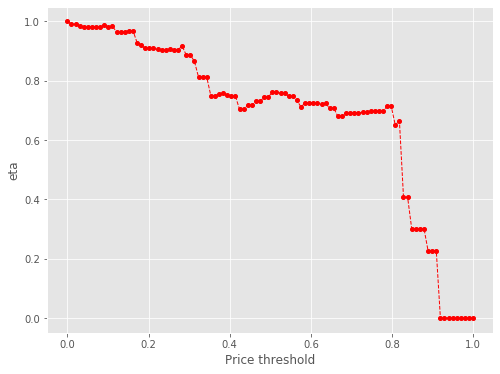

957 60
Number of cells with price above 66.0th percentile:  60


eta =  1.0
eta =  0.9939273234170753
eta =  0.9911578517840005
eta =  0.9911578517840005
eta =  0.9911578517840005
eta =  0.9911578517840005
eta =  0.9911578517840005
eta =  0.9965514290877253
eta =  0.9917704629995252
eta =  0.9929549956331404
eta =  0.9734296232407554
eta =  0.9734296232407554
eta =  0.9734296232407554
eta =  0.9781180742844613
eta =  0.9781180742844613
eta =  0.9375935175640099
eta =  0.9280749984479439
eta =  0.9179366890572295
eta =  0.9179366890572295
eta =  0.9179366890572295
eta =  0.9139250250332905
eta =  0.9104731637643604
eta =  0.9104731637643604
eta =  0.9154016914850402
eta =  0.9135925436579915
eta =  0.9135925436579915
eta =  0.9135925436579915
eta =  0.8952338006488467
eta =  0.8952338006488467
eta =  0.8786847646609578
eta =  0.8197981293248474
eta =  0.8197981293248474
eta =  0.8197981293248474
eta =  0.7564089725090374
eta =  0.7564089725090374
eta =  0.7617296025196515
eta =  0.7617296025196515
eta =  0.7576383882678526
eta =  0.7559802357364296
e

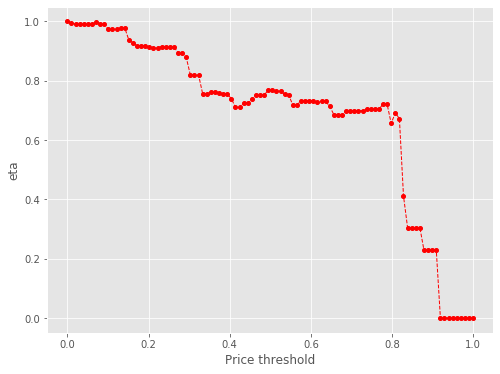

957 57
Number of cells with price above 67.0th percentile:  57


eta =  1.0
eta =  1.0054416935647705
eta =  1.0018131762220368
eta =  0.9940724033340793
eta =  0.9821136174108537
eta =  0.9821136174108537
eta =  0.9821136174108537
eta =  0.9868438942635942
eta =  0.9868438942635942
eta =  0.945957816786116
eta =  0.9363543826823217
eta =  0.9261256291366919
eta =  0.9261256291366919
eta =  0.9261256291366919
eta =  0.9261256291366919
eta =  0.9220781769405374
eta =  0.9185955215161596
eta =  0.9235680167769387
eta =  0.9217427294891546
eta =  0.9217427294891546
eta =  0.9217427294891546
eta =  0.9334264284981604
eta =  0.9032202075960973
eta =  0.9032202075960973
eta =  0.8865235371736191
eta =  0.8271115724395262
eta =  0.8271115724395262
eta =  0.8271115724395262
eta =  0.7631569190997832
eta =  0.7631569190997832
eta =  0.7631569190997832
eta =  0.7685250146065054
eta =  0.7718941490572978
eta =  0.7643973025125791
eta =  0.7627243575538739
eta =  0.7616081304614181
eta =  0.7467221601881572
eta =  0.7166458461524117
eta =  0.7166458461524117
et

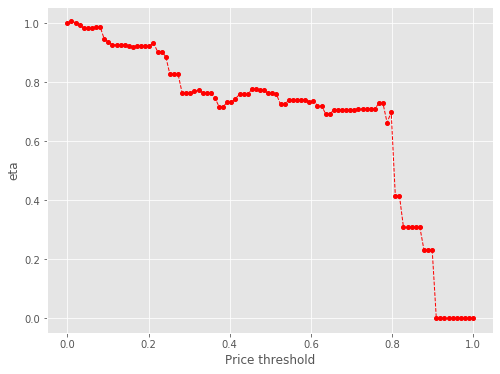

957 57
Number of cells with price above 68.0th percentile:  57


eta =  1.0
eta =  1.0054416935647705
eta =  1.0018131762220368
eta =  0.9940724033340793
eta =  0.9821136174108537
eta =  0.9821136174108537
eta =  0.9821136174108537
eta =  0.9868438942635942
eta =  0.9868438942635942
eta =  0.945957816786116
eta =  0.9363543826823217
eta =  0.9261256291366919
eta =  0.9261256291366919
eta =  0.9261256291366919
eta =  0.9261256291366919
eta =  0.9220781769405374
eta =  0.9185955215161596
eta =  0.9235680167769387
eta =  0.9217427294891546
eta =  0.9217427294891546
eta =  0.9217427294891546
eta =  0.9334264284981604
eta =  0.9032202075960973
eta =  0.9032202075960973
eta =  0.8865235371736191
eta =  0.8271115724395262
eta =  0.8271115724395262
eta =  0.8271115724395262
eta =  0.7631569190997832
eta =  0.7631569190997832
eta =  0.7631569190997832
eta =  0.7685250146065054
eta =  0.7718941490572978
eta =  0.7643973025125791
eta =  0.7627243575538739
eta =  0.7616081304614181
eta =  0.7467221601881572
eta =  0.7166458461524117
eta =  0.7166458461524117
et

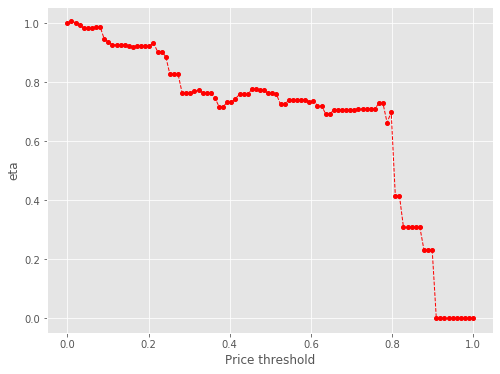

957 54
Number of cells with price above 69.0th percentile:  54


eta =  1.0
eta =  0.9803360953132272
eta =  0.9803360953132272
eta =  0.9803360953132272
eta =  0.9850578108636046
eta =  0.9850578108636046
eta =  0.9442457328755063
eta =  0.9442457328755063
eta =  0.9346596799748946
eta =  0.9244494393947061
eta =  0.9244494393947061
eta =  0.9244494393947061
eta =  0.9204093126602805
eta =  0.9169329604750244
eta =  0.9169329604750244
eta =  0.9218964560436602
eta =  0.9200744723334164
eta =  0.9200744723334164
eta =  0.9200744723334164
eta =  0.925035900591542
eta =  0.9015854742520496
eta =  0.9015854742520496
eta =  0.8794607555751625
eta =  0.8256145877005407
eta =  0.8256145877005407
eta =  0.8256145877005407
eta =  0.7617756855402358
eta =  0.7617756855402358
eta =  0.7617756855402358
eta =  0.76713406536008
eta =  0.7704971020327437
eta =  0.7630138239898352
eta =  0.7613439068851171
eta =  0.7602297000460083
eta =  0.7453706718094286
eta =  0.7153487927309691
eta =  0.7153487927309691
eta =  0.7301298921519841
eta =  0.7301298921519841
eta 

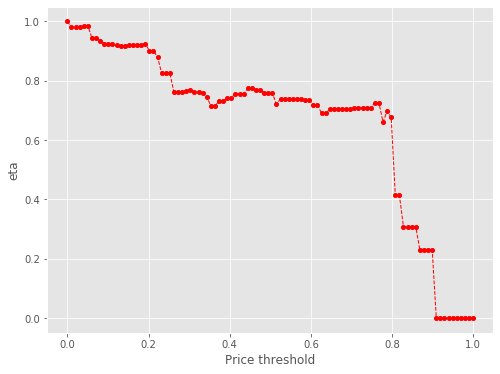

957 51
Number of cells with price above 70.0th percentile:  51


eta =  1.0
eta =  1.0048164252779743
eta =  1.0048164252779743
eta =  0.9631857251709276
eta =  0.9631857251709276
eta =  0.9429923511072346
eta =  0.9429923511072346
eta =  0.9429923511072346
eta =  0.9429923511072346
eta =  0.9388711861784508
eta =  0.9353251041746607
eta =  0.9353251041746607
eta =  0.940388159174232
eta =  0.9385296295138897
eta =  0.9385296295138897
eta =  0.9385296295138897
eta =  0.95042611358852
eta =  0.9196697730118608
eta =  0.9196697730118608
eta =  0.9026690206279405
eta =  0.8421750373648627
eta =  0.8421750373648627
eta =  0.8421750373648627
eta =  0.8421750373648627
eta =  0.777055633452771
eta =  0.777055633452771
eta =  0.7825214934220829
eta =  0.7825214934220829
eta =  0.7783186068916953
eta =  0.7783186068916953
eta =  0.7754786380716782
eta =  0.7754786380716782
eta =  0.760321562546644
eta =  0.7296974947172663
eta =  0.7296974947172663
eta =  0.7447750783048545
eta =  0.7447750783048545
eta =  0.7576381107627389
eta =  0.7576381107627389
eta =  

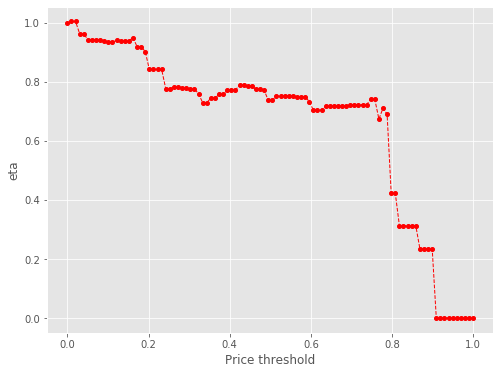

957 47
Number of cells with price above 71.00000000000001th percentile:  47


eta =  1.0
eta =  0.9790348075807399
eta =  0.9790348075807399
eta =  0.9790348075807399
eta =  0.9790348075807399
eta =  0.974756126095866
eta =  0.971074507991361
eta =  0.971074507991361
eta =  0.9763310798728356
eta =  0.9744015146687703
eta =  0.9744015146687703
eta =  0.9744015146687703
eta =  0.9744015146687703
eta =  0.9548208086749371
eta =  0.9548208086749371
eta =  0.9548208086749371
eta =  0.931389706042881
eta =  0.8743641183172745
eta =  0.8743641183172745
eta =  0.8743641183172745
eta =  0.8610707993488256
eta =  0.8067557617871404
eta =  0.8067557617871404
eta =  0.8124305343948242
eta =  0.8124305343948242
eta =  0.8080670077970418
eta =  0.8080670077970418
eta =  0.8051184914872583
eta =  0.8051184914872583
eta =  0.7893820918200556
eta =  0.7575875302634637
eta =  0.7575875302634637
eta =  0.7732413997027273
eta =  0.7732413997027273
eta =  0.7732413997027273
eta =  0.7865960748414206
eta =  0.8013969311018175
eta =  0.8013969311018175
eta =  0.8013969311018175
eta =

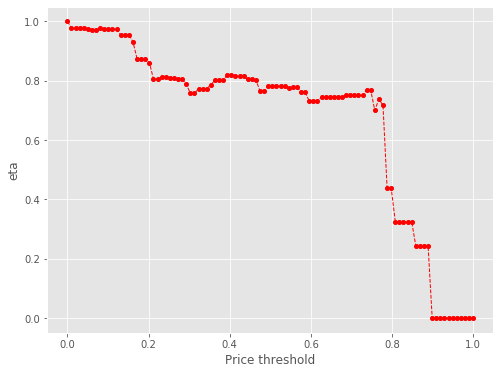

957 45
Number of cells with price above 72.0th percentile:  45


eta =  1.0
eta =  0.9956296942133785
eta =  0.9918692374083723
eta =  0.9918692374083723
eta =  0.9972383742774321
eta =  0.9952674890860941
eta =  0.9952674890860941
eta =  0.9952674890860941
eta =  1.0078831630739709
eta =  0.975267479033113
eta =  0.975267479033113
eta =  0.975267479033113
eta =  0.9513346193935707
eta =  0.893087877516721
eta =  0.893087877516721
eta =  0.893087877516721
eta =  0.8795098935007108
eta =  0.8240317458995022
eta =  0.8240317458995022
eta =  0.8298280389053725
eta =  0.8298280389053725
eta =  0.8253710711203711
eta =  0.8253710711203711
eta =  0.8235646801664089
eta =  0.8223594148575367
eta =  0.8062860336607144
eta =  0.7738106187823013
eta =  0.7738106187823013
eta =  0.7738106187823013
eta =  0.7897997024369933
eta =  0.7897997024369933
eta =  0.803440356513117
eta =  0.803440356513117
eta =  0.8185581604418362
eta =  0.8185581604418362
eta =  0.8185581604418362
eta =  0.8374720857493922
eta =  0.8374720857493922
eta =  0.8332223237785568
eta =  0.

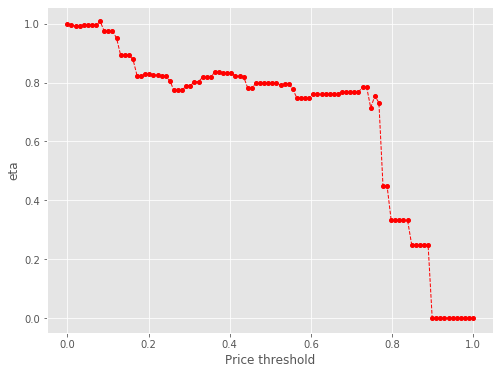

957 44
Number of cells with price above 73.0th percentile:  44


eta =  1.0
eta =  0.9962230367104736
eta =  1.0016157413478155
eta =  0.9996362049772224
eta =  0.9996362049772224
eta =  0.9996362049772224
eta =  0.9996362049772224
eta =  1.0123072553297774
eta =  0.9795484050961807
eta =  0.9795484050961807
eta =  0.9614407534457774
eta =  0.8970080771067468
eta =  0.8970080771067468
eta =  0.8970080771067468
eta =  0.8970080771067468
eta =  0.8276488243458313
eta =  0.8276488243458313
eta =  0.8276488243458313
eta =  0.8334705601172315
eta =  0.8334705601172315
eta =  0.828994028520288
eta =  0.828994028520288
eta =  0.8271797084327484
eta =  0.8259691526248238
eta =  0.8098252174948843
eta =  0.7772072521337055
eta =  0.7772072521337055
eta =  0.7772072521337055
eta =  0.793266519698364
eta =  0.793266519698364
eta =  0.8069670492781903
eta =  0.8069670492781903
eta =  0.8221512126439318
eta =  0.8221512126439318
eta =  0.8221512126439318
eta =  0.8411481604222918
eta =  0.8411481604222918
eta =  0.836879744167197
eta =  0.836879744167197
eta =  

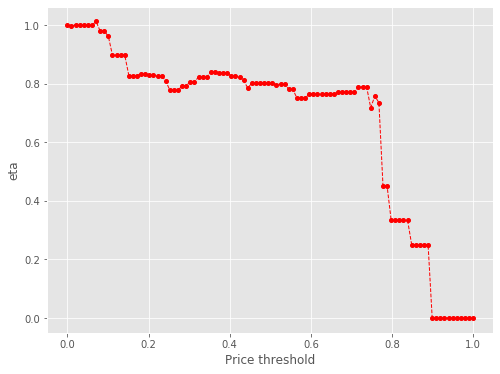

957 42
Number of cells with price above 74.0th percentile:  42


eta =  1.0
eta =  0.9980236568886892
eta =  0.9980236568886892
eta =  0.9980236568886892
eta =  1.0106742671272069
eta =  0.9779682613394831
eta =  0.9779682613394831
eta =  0.9779682613394831
eta =  0.9539691250678938
eta =  0.8955610820370051
eta =  0.8955610820370051
eta =  0.8955610820370051
eta =  0.8955610820370051
eta =  0.8263137151100609
eta =  0.8263137151100609
eta =  0.8263137151100609
eta =  0.8321260596360827
eta =  0.8357740145128116
eta =  0.8276567492886637
eta =  0.8258453559442478
eta =  0.8246367529261925
eta =  0.8246367529261925
eta =  0.8085188601420641
eta =  0.7759535119604483
eta =  0.7759535119604483
eta =  0.7759535119604483
eta =  0.7919868737595036
eta =  0.7919868737595036
eta =  0.8056653025363819
eta =  0.8056653025363819
eta =  0.8208249717976787
eta =  0.8208249717976787
eta =  0.8208249717976787
eta =  0.8397912749358432
eta =  0.8397912749358432
eta =  0.8397912749358432
eta =  0.8355297442121437
eta =  0.8355297442121437
eta =  0.8241913498162543
e

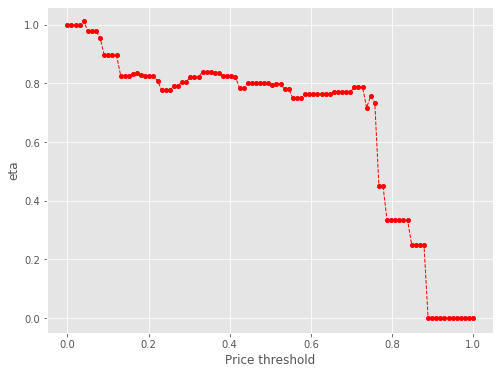

957 41
Number of cells with price above 75.0th percentile:  41


eta =  1.0
eta =  0.9799048896178191
eta =  0.9799048896178191
eta =  0.9799048896178191
eta =  0.9617906480965089
eta =  0.897334522939959
eta =  0.897334522939959
eta =  0.897334522939959
eta =  0.897334522939959
eta =  0.8279500284452883
eta =  0.8279500284452883
eta =  0.8279500284452883
eta =  0.8337738829059547
eta =  0.8337738829059547
eta =  0.8374290616700548
eta =  0.8292957221764266
eta =  0.8274807418080625
eta =  0.8262697454456887
eta =  0.8262697454456887
eta =  0.8101199350951248
eta =  0.7774900991620395
eta =  0.7774900991620395
eta =  0.7774900991620395
eta =  0.793555211134474
eta =  0.793555211134474
eta =  0.8072607267126521
eta =  0.8072607267126521
eta =  0.8224504160117583
eta =  0.8224504160117583
eta =  0.8224504160117583
eta =  0.8224504160117583
eta =  0.8414542773002686
eta =  0.8414542773002686
eta =  0.8371843076514681
eta =  0.8371843076514681
eta =  0.8371843076514681
eta =  0.825823460323223
eta =  0.825823460323223
eta =  0.8231974907563973
eta =  0.

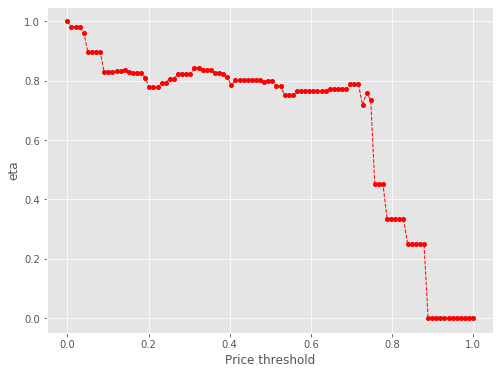

957 37
Number of cells with price above 76.0th percentile:  37


eta =  1.0
eta =  0.932983206601025
eta =  0.932983206601025
eta =  0.932983206601025
eta =  0.932983206601025
eta =  0.8608422530244954
eta =  0.8608422530244954
eta =  0.8608422530244954
eta =  0.8608422530244954
eta =  0.8668974735365603
eta =  0.8706978627078775
eta =  0.8622414075429984
eta =  0.8622414075429984
eta =  0.8590952169070979
eta =  0.8590952169070979
eta =  0.8590952169070979
eta =  0.8083776866626632
eta =  0.8083776866626632
eta =  0.8083776866626632
eta =  0.8250810222630136
eta =  0.8250810222630136
eta =  0.8250810222630136
eta =  0.8393310210598443
eta =  0.8393310210598443
eta =  0.8551241558019714
eta =  0.8551241558019714
eta =  0.8551241558019714
eta =  0.8551241558019714
eta =  0.8748829893133193
eta =  0.8748829893133193
eta =  0.8704433852713678
eta =  0.8704433852713678
eta =  0.8704433852713678
eta =  0.8586312020787681
eta =  0.8586312020787681
eta =  0.8586312020787681
eta =  0.8559009098139984
eta =  0.8169301648347556
eta =  0.8169301648347556
eta =

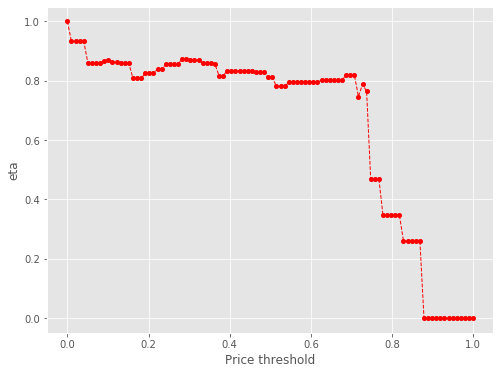

957 35
Number of cells with price above 77.0th percentile:  35


eta =  1.0
eta =  0.9226771145867156
eta =  0.9226771145867156
eta =  0.9226771145867156
eta =  0.9291672855450173
eta =  0.9291672855450173
eta =  0.9241767712885768
eta =  0.9241767712885768
eta =  0.9221541361152218
eta =  0.9208045877233844
eta =  0.9208045877233844
eta =  0.902807051756918
eta =  0.8664439841395266
eta =  0.8664439841395266
eta =  0.8664439841395266
eta =  0.8843471312510409
eta =  0.8843471312510409
eta =  0.8843471312510409
eta =  0.8996207167732767
eta =  0.8996207167732767
eta =  0.9165482827041402
eta =  0.9165482827041402
eta =  0.9165482827041402
eta =  0.9165482827041402
eta =  0.9377264061382499
eta =  0.9377264061382499
eta =  0.9377264061382499
eta =  0.9329679024368536
eta =  0.9329679024368536
eta =  0.9329679024368536
eta =  0.9203072424067197
eta =  0.9203072424067197
eta =  0.9173808314644301
eta =  0.9039285703628709
eta =  0.8756107924074377
eta =  0.8756107924074377
eta =  0.8938340903909702
eta =  0.8938340903909702
eta =  0.8938340903909702
et

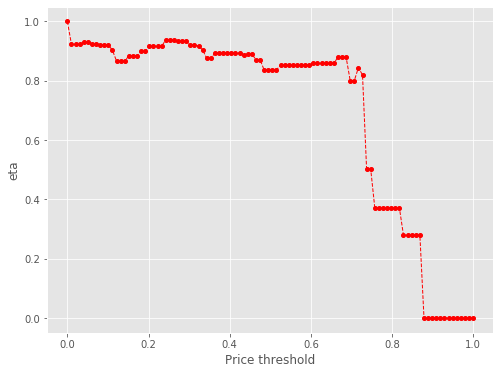

957 33
Number of cells with price above 78.0th percentile:  33


eta =  1.0
eta =  1.0070340651737186
eta =  1.011448798718645
eta =  1.0016253320670394
eta =  1.0016253320670394
eta =  0.999433194491089
eta =  0.9979705502242028
eta =  0.9979705502242028
eta =  0.9784647711364362
eta =  0.9390543782237658
eta =  0.9390543782237658
eta =  0.9390543782237658
eta =  0.9584578584103677
eta =  0.9584578584103677
eta =  0.9584578584103677
eta =  0.9750114124985464
eta =  0.9750114124985464
eta =  0.9933575551125263
eta =  0.9933575551125263
eta =  0.9933575551125263
eta =  0.9933575551125263
eta =  1.016310463664502
eta =  1.016310463664502
eta =  1.016310463664502
eta =  1.0111531842368793
eta =  1.0111531842368793
eta =  1.0111531842368793
eta =  0.9974315259991492
eta =  0.9974315259991492
eta =  0.9974315259991492
eta =  0.9942598737537152
eta =  0.948989390291359
eta =  0.948989390291359
eta =  0.9687398508754985
eta =  0.9687398508754985
eta =  0.9687398508754985
eta =  0.9687398508754985
eta =  0.9687398508754985
eta =  0.9687398508754985
eta =  0

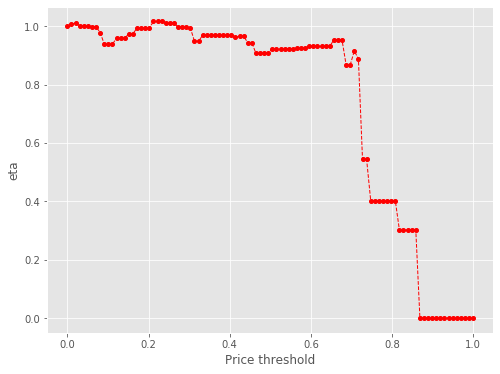

957 30
Number of cells with price above 79.0th percentile:  30


eta =  1.0
eta =  0.9963511487521045
eta =  0.9963511487521045
eta =  0.9963511487521045
eta =  0.9768770215876958
eta =  0.9375305797087352
eta =  0.9375305797087352
eta =  0.9375305797087352
eta =  0.9569025739718587
eta =  0.9569025739718587
eta =  0.9569025739718587
eta =  0.9734292666963901
eta =  0.9734292666963901
eta =  0.9917456391229135
eta =  0.9917456391229135
eta =  0.9917456391229135
eta =  0.9917456391229135
eta =  0.9917456391229135
eta =  1.0146613021129938
eta =  1.0146613021129938
eta =  1.0095123913751038
eta =  1.0095123913751038
eta =  1.0095123913751038
eta =  1.0095123913751038
eta =  0.9958129991987769
eta =  0.9958129991987769
eta =  0.9958129991987769
eta =  0.9926464935764712
eta =  0.9474494702854047
eta =  0.9474494702854047
eta =  0.9671678819028313
eta =  0.9671678819028313
eta =  0.9671678819028313
eta =  0.9671678819028313
eta =  0.9671678819028313
eta =  0.9671678819028313
eta =  0.9671678819028313
eta =  0.9671678819028313
eta =  0.960214383155803
et

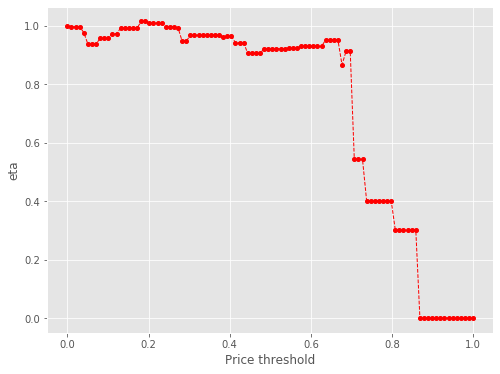

957 26
Number of cells with price above 80.0th percentile:  26


eta =  1.0
eta =  1.0206627865612041
eta =  1.0206627865612041
eta =  1.0206627865612041
eta =  1.0382906838076766
eta =  1.0382906838076766
eta =  1.0578275104701345
eta =  1.0578275104701345
eta =  1.0578275104701345
eta =  1.0578275104701345
eta =  1.0578275104701345
eta =  1.0822700870495563
eta =  1.0822700870495563
eta =  1.0822700870495563
eta =  1.0767780947355674
eta =  1.0767780947355674
eta =  1.0767780947355674
eta =  1.0621658863736991
eta =  1.0621658863736991
eta =  1.0621658863736991
eta =  1.0621658863736991
eta =  1.0587883905449345
eta =  1.0105798048526065
eta =  1.0105798048526065
eta =  1.0316120912059248
eta =  1.0316120912059248
eta =  1.0316120912059248
eta =  1.0316120912059248
eta =  1.0316120912059248
eta =  1.0316120912059248
eta =  1.0316120912059248
eta =  1.0316120912059248
eta =  1.0316120912059248
eta =  1.0241952678003472
eta =  1.0281144225685934
eta =  1.0281144225685934
eta =  1.0281144225685934
eta =  1.0050703777120753
eta =  1.0050703777120753
e

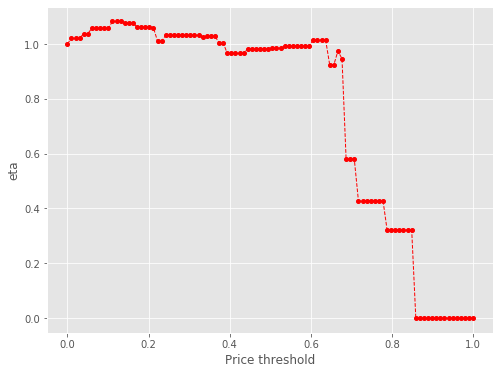

957 25
Number of cells with price above 81.0th percentile:  25


eta =  1.0
eta =  1.0172710296471805
eta =  1.0172710296471805
eta =  1.0364123434284747
eta =  1.0364123434284747
eta =  1.0364123434284747
eta =  1.0364123434284747
eta =  1.0364123434284747
eta =  1.0603600927745376
eta =  1.0603600927745376
eta =  1.0603600927745376
eta =  1.054979282984761
eta =  1.054979282984761
eta =  1.054979282984761
eta =  1.054979282984761
eta =  1.0406628911712619
eta =  1.0406628911712619
eta =  1.0406628911712619
eta =  1.0373537709865785
eta =  1.022142254347712
eta =  0.9901211430049596
eta =  0.9901211430049596
eta =  1.0107276416744955
eta =  1.0107276416744955
eta =  1.0107276416744955
eta =  1.0107276416744955
eta =  1.0107276416744955
eta =  1.0107276416744955
eta =  1.0107276416744955
eta =  1.0107276416744955
eta =  1.0107276416744955
eta =  1.0034609679961437
eta =  1.0073007815171702
eta =  1.0073007815171702
eta =  0.9847232513476244
eta =  0.9847232513476244
eta =  0.9847232513476244
eta =  0.9462002528243116
eta =  0.9462002528243116
eta = 

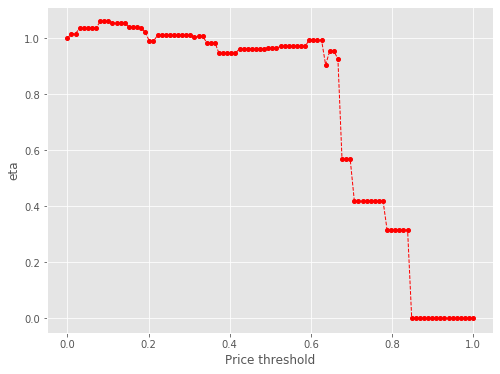

957 23
Number of cells with price above 82.0th percentile:  23


eta =  1.0
eta =  1.0231063914839562
eta =  1.0231063914839562
eta =  1.0231063914839562
eta =  1.0179146260405068
eta =  1.0179146260405068
eta =  1.0179146260405068
eta =  1.0179146260405068
eta =  1.004101212967733
eta =  1.004101212967733
eta =  1.004101212967733
eta =  1.0009083523214222
eta =  1.0009083523214222
eta =  0.9553351513834901
eta =  0.9553351513834901
eta =  0.9553351513834901
eta =  0.9752176805719878
eta =  0.9752176805719878
eta =  0.9752176805719878
eta =  0.9752176805719878
eta =  0.9752176805719878
eta =  0.9752176805719878
eta =  0.9752176805719878
eta =  0.9752176805719878
eta =  0.9752176805719878
eta =  0.968206307420725
eta =  0.968206307420725
eta =  0.9719112165192832
eta =  0.9719112165192832
eta =  0.9501269042108649
eta =  0.9501269042108649
eta =  0.9501269042108649
eta =  0.9129573367432701
eta =  0.9129573367432701
eta =  0.9129573367432701
eta =  0.9129573367432701
eta =  0.9129573367432701
eta =  0.9296635633355789
eta =  0.9296635633355789
eta = 

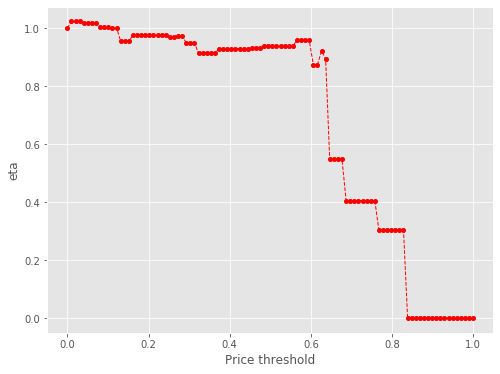

957 22
Number of cells with price above 83.0th percentile:  22


eta =  1.0
eta =  0.9949254882125025
eta =  0.9949254882125025
eta =  0.9949254882125025
eta =  0.9949254882125025
eta =  0.9814240447773398
eta =  0.9814240447773398
eta =  0.9814240447773398
eta =  0.9783032934333086
eta =  0.9783032934333086
eta =  0.9337593424646993
eta =  0.9337593424646993
eta =  0.9337593424646993
eta =  0.9531928337946275
eta =  0.9531928337946275
eta =  0.9531928337946275
eta =  0.9531928337946275
eta =  0.9531928337946275
eta =  0.9531928337946275
eta =  0.9531928337946275
eta =  0.9531928337946275
eta =  0.9531928337946275
eta =  0.9531928337946275
eta =  0.9463398093099566
eta =  0.9499610447253513
eta =  0.9499610447253513
eta =  0.9499610447253513
eta =  0.9286687211803664
eta =  0.9286687211803664
eta =  0.9286687211803664
eta =  0.8923386114508371
eta =  0.8923386114508371
eta =  0.8923386114508371
eta =  0.8923386114508371
eta =  0.8923386114508371
eta =  0.9086675355308416
eta =  0.9086675355308416
eta =  0.9086675355308416
eta =  0.9086675355308416
e

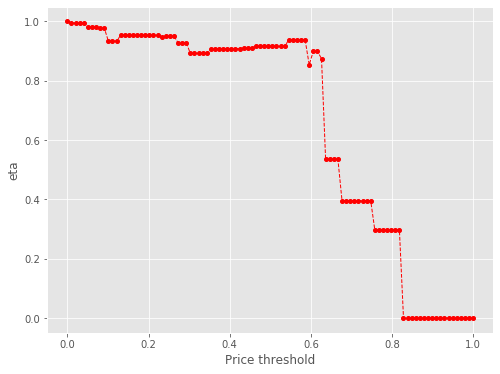

957 20
Number of cells with price above 84.00000000000001th percentile:  20


eta =  1.0
eta =  0.9968201804707777
eta =  0.9822030390622414
eta =  0.9514331215275508
eta =  0.9514331215275508
eta =  0.9712344412866741
eta =  0.9712344412866741
eta =  0.9712344412866741
eta =  0.9712344412866741
eta =  0.9712344412866741
eta =  0.9712344412866741
eta =  0.9712344412866741
eta =  0.9712344412866741
eta =  0.9712344412866741
eta =  0.9712344412866741
eta =  0.9712344412866741
eta =  0.9642517058206549
eta =  0.9642517058206549
eta =  0.9679414823598227
eta =  0.9679414823598227
eta =  0.9679414823598227
eta =  0.9462461472411323
eta =  0.9462461472411323
eta =  0.9462461472411323
eta =  0.9092283974490212
eta =  0.9092283974490212
eta =  0.9092283974490212
eta =  0.9092283974490212
eta =  0.9092283974490212
eta =  0.9092283974490212
eta =  0.9258663880983221
eta =  0.9258663880983221
eta =  0.9258663880983221
eta =  0.9258663880983221
eta =  0.9258663880983221
eta =  0.9258663880983221
eta =  0.9258663880983221
eta =  0.9258663880983221
eta =  0.9272546935517824
e

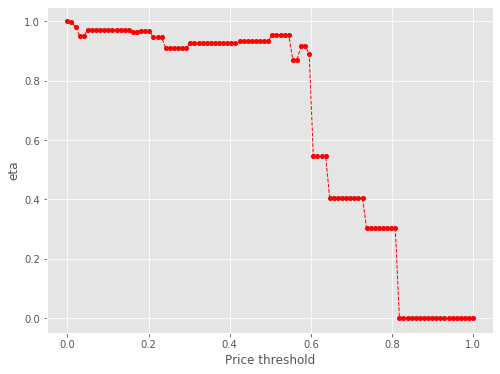

957 17
Number of cells with price above 85.0th percentile:  17


eta =  1.0
eta =  1.0208120984135298
eta =  1.0208120984135298
eta =  1.0208120984135298
eta =  1.0208120984135298
eta =  1.0208120984135298
eta =  1.0208120984135298
eta =  1.0208120984135298
eta =  1.0208120984135298
eta =  1.0208120984135298
eta =  1.0208120984135298
eta =  1.0134729220615355
eta =  1.0134729220615355
eta =  1.0173510470244795
eta =  1.0173510470244795
eta =  1.0173510470244795
eta =  0.9945482512968535
eta =  0.9945482512968535
eta =  0.9945482512968535
eta =  0.9945482512968535
eta =  0.9556408925403304
eta =  0.9556408925403304
eta =  0.9556408925403304
eta =  0.9556408925403304
eta =  0.9556408925403304
eta =  0.9556408925403304
eta =  0.9731281864686604
eta =  0.9731281864686604
eta =  0.9731281864686604
eta =  0.9731281864686604
eta =  0.9731281864686604
eta =  0.9731281864686604
eta =  0.9731281864686604
eta =  0.9731281864686604
eta =  0.9731281864686604
eta =  0.9745873593963711
eta =  0.9745873593963711
eta =  0.9745873593963711
eta =  0.9745873593963711
e

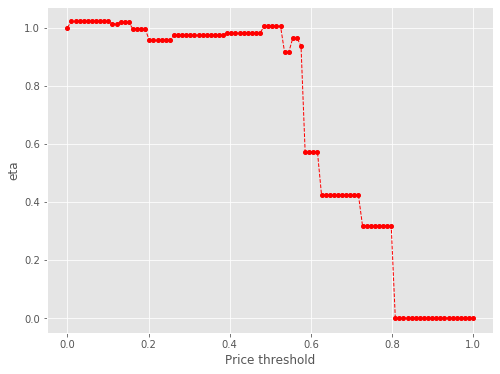

957 16
Number of cells with price above 86.0th percentile:  16


eta =  1.0
eta =  0.9928104532034833
eta =  0.9928104532034833
eta =  0.996609511785343
eta =  0.996609511785343
eta =  0.996609511785343
eta =  0.9742716145728545
eta =  0.9742716145728545
eta =  0.9742716145728545
eta =  0.9742716145728545
eta =  0.9361574907130472
eta =  0.9361574907130472
eta =  0.9361574907130472
eta =  0.9361574907130472
eta =  0.9361574907130472
eta =  0.9361574907130472
eta =  0.9361574907130472
eta =  0.9532882574383902
eta =  0.9532882574383902
eta =  0.9532882574383902
eta =  0.9532882574383902
eta =  0.9532882574383902
eta =  0.9532882574383902
eta =  0.9532882574383902
eta =  0.9532882574383902
eta =  0.9532882574383902
eta =  0.9532882574383902
eta =  0.9547176810609926
eta =  0.9547176810609926
eta =  0.9547176810609926
eta =  0.9547176810609926
eta =  0.9607155801213537
eta =  0.9607155801213537
eta =  0.9607155801213537
eta =  0.9607155801213537
eta =  0.9607155801213537
eta =  0.9607155801213537
eta =  0.9607155801213537
eta =  0.9607155801213537
eta 

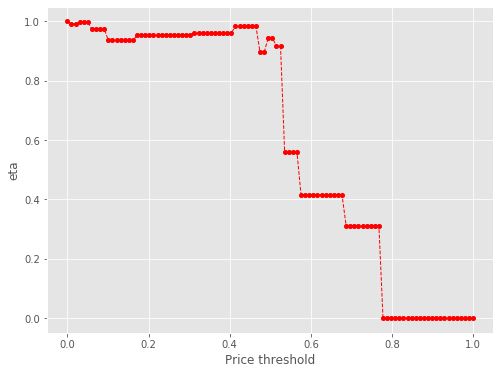

957 15
Number of cells with price above 87.0th percentile:  15


eta =  1.0
eta =  1.0038265698851188
eta =  1.0038265698851188
eta =  1.0038265698851188
eta =  0.9813269103172616
eta =  0.9813269103172616
eta =  0.9813269103172616
eta =  0.9813269103172616
eta =  0.9429367788104617
eta =  0.9429367788104617
eta =  0.9429367788104617
eta =  0.9429367788104617
eta =  0.9429367788104617
eta =  0.9429367788104617
eta =  0.9429367788104617
eta =  0.960191599879345
eta =  0.960191599879345
eta =  0.960191599879345
eta =  0.960191599879345
eta =  0.960191599879345
eta =  0.960191599879345
eta =  0.960191599879345
eta =  0.960191599879345
eta =  0.960191599879345
eta =  0.960191599879345
eta =  0.9616313748313413
eta =  0.9616313748313413
eta =  0.9616313748313413
eta =  0.9616313748313413
eta =  0.9616313748313413
eta =  0.9676727083416884
eta =  0.9676727083416884
eta =  0.9676727083416884
eta =  0.9676727083416884
eta =  0.9676727083416884
eta =  0.9676727083416884
eta =  0.9676727083416884
eta =  0.9676727083416884
eta =  0.9676727083416884
eta =  0.96

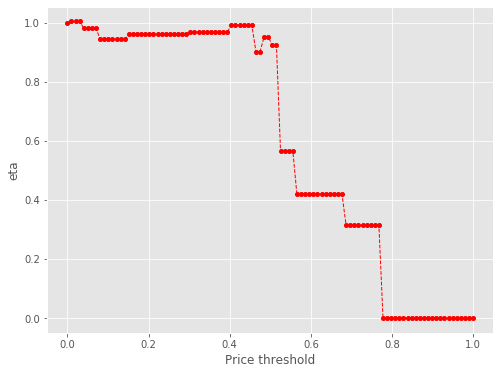

957 13
Number of cells with price above 88.0th percentile:  13


eta =  1.0
eta =  0.9608793653743904
eta =  0.9608793653743904
eta =  0.9608793653743904
eta =  0.9608793653743904
eta =  0.9608793653743904
eta =  0.9608793653743904
eta =  0.9608793653743904
eta =  0.9784625182335175
eta =  0.9784625182335175
eta =  0.9784625182335175
eta =  0.9784625182335175
eta =  0.9784625182335175
eta =  0.9784625182335175
eta =  0.9784625182335175
eta =  0.9784625182335175
eta =  0.9784625182335175
eta =  0.9784625182335175
eta =  0.9784625182335175
eta =  0.9799296898119784
eta =  0.9799296898119784
eta =  0.9799296898119784
eta =  0.9799296898119784
eta =  0.9799296898119784
eta =  0.9860859802864685
eta =  0.9860859802864685
eta =  0.9860859802864685
eta =  0.9860859802864685
eta =  0.9860859802864685
eta =  0.9860859802864685
eta =  0.9860859802864685
eta =  0.9860859802864685
eta =  0.9860859802864685
eta =  0.9860859802864685
eta =  0.9860859802864685
eta =  1.009991970054938
eta =  1.009991970054938
eta =  1.009991970054938
eta =  1.009991970054938
eta =

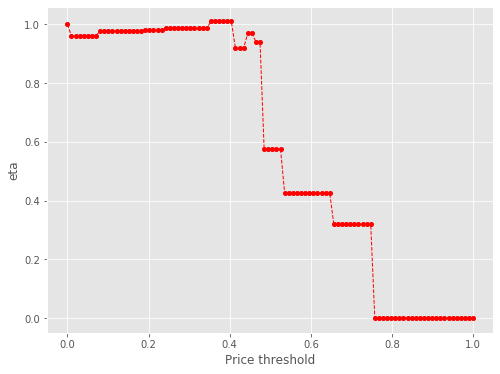

957 12
Number of cells with price above 89.0th percentile:  12


eta =  1.0
eta =  1.0182990222214585
eta =  1.0182990222214585
eta =  1.0182990222214585
eta =  1.0182990222214585
eta =  1.0182990222214585
eta =  1.0182990222214585
eta =  1.0182990222214585
eta =  1.0182990222214585
eta =  1.0182990222214585
eta =  1.0182990222214585
eta =  1.0182990222214585
eta =  1.0198259272954262
eta =  1.0198259272954262
eta =  1.0198259272954262
eta =  1.0198259272954262
eta =  1.0198259272954262
eta =  1.0198259272954262
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0262328610858
eta =  1.0511121441986755
eta =  1.0511121441986755
eta =  1.0511121441986755
eta =  1.0511121441986755
eta =  1.0511121441986755
eta =  1.0511121441986755
eta =  0.9567008116734076
eta =  0.9567008116734076
eta =  0.9567008116734076
eta =  1.008933698497337
eta =  1.008

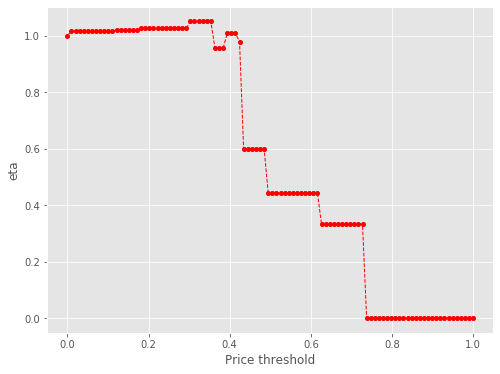

957 11
Number of cells with price above 90.0th percentile:  11


eta =  1.0
eta =  1.001499466306701
eta =  1.001499466306701
eta =  1.001499466306701
eta =  1.001499466306701
eta =  1.001499466306701
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0077912663090194
eta =  1.0322234640917496
eta =  1.0322234640917496
eta =  1.0322234640917496
eta =  1.0322234640917496
eta =  1.0322234640917496
eta =  1.0322234640917496
eta =  1.0322234640917496
eta =  0.9395087207157755
eta =  0.9395087207157755
eta =  0.9395087207157755
eta =  0.9908029728795272
eta =  0.9908029728795272
eta =  0.9908029728795272
eta =  0.9621373289902294
eta =  0.9621373289902294
eta =  0.5889479452688731
eta =  0.5889479452688731
eta =  0.5889479452688731
eta = 

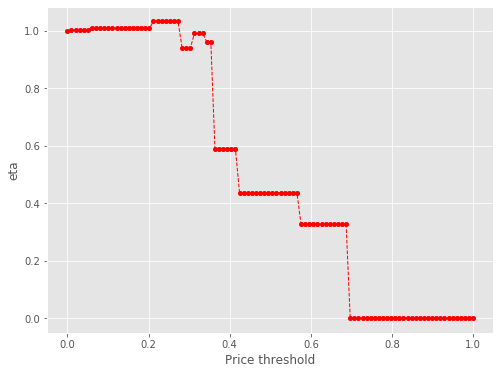

957 9
Number of cells with price above 91.0th percentile:  9


eta =  1.0
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  0.9322453489368636
eta =  0.9322453489368636
eta =  0.9322453489368636
eta =  0.9322453489368636
eta =  0.9831430436069258
eta =  0.9831430436069258
eta =  0.9831430436069258
eta =  0.9546990147215751
eta =  0.9546990147215751
eta =  0.9546990147215751
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799

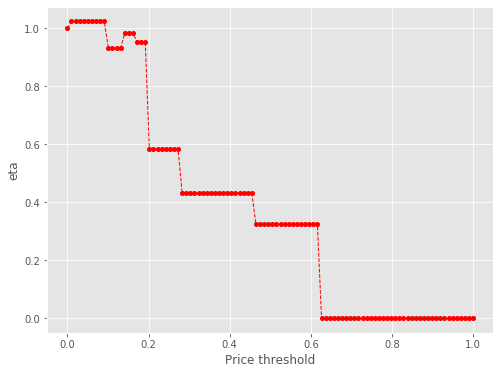

957 9
Number of cells with price above 92.0th percentile:  9


eta =  1.0
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  1.0242433116851783
eta =  0.9322453489368636
eta =  0.9322453489368636
eta =  0.9322453489368636
eta =  0.9322453489368636
eta =  0.9831430436069258
eta =  0.9831430436069258
eta =  0.9831430436069258
eta =  0.9546990147215751
eta =  0.9546990147215751
eta =  0.9546990147215751
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.5843947699863116
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799117866074
eta =  0.43223799

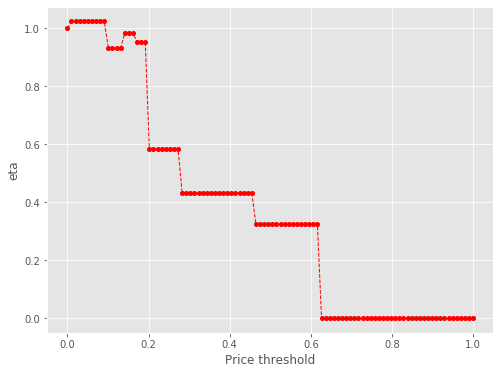

957 8
Number of cells with price above 93.0th percentile:  8


eta =  1.0
eta =  0.9101795816494508
eta =  0.9101795816494508
eta =  0.9101795816494508
eta =  0.9101795816494508
eta =  0.9598725540998354
eta =  0.9598725540998354
eta =  0.9598725540998354
eta =  0.9598725540998354
eta =  0.932101780729051
eta =  0.932101780729051
eta =  0.932101780729051
eta =  0.5705624467538012
eta =  0.5705624467538012
eta =  0.5705624467538012
eta =  0.5705624467538012
eta =  0.5705624467538012
eta =  0.5705624467538012
eta =  0.5705624467538012
eta =  0.5705624467538012
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta =  0.4220071405372455
eta 

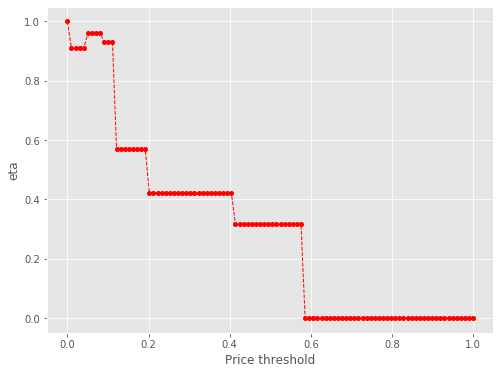

957 4
Number of cells with price above 94.0th percentile:  4


eta =  1.0
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.7396335719924139
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
eta =  0.5547251789942552
e

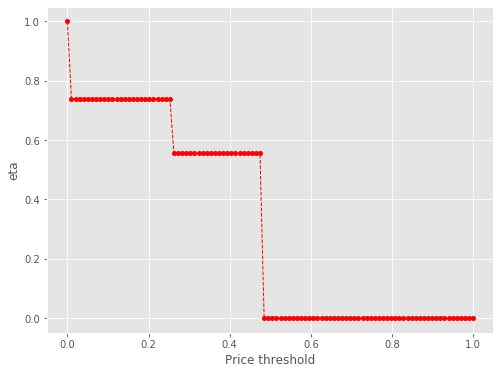

957 3
Number of cells with price above 95.0th percentile:  3


eta =  1.0
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  0.7499999999999253
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta 

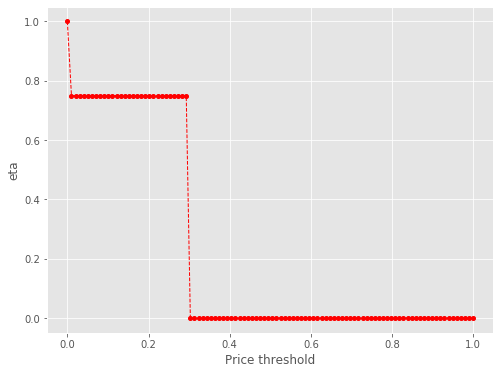

957 2
Number of cells with price above 96.00000000000001th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

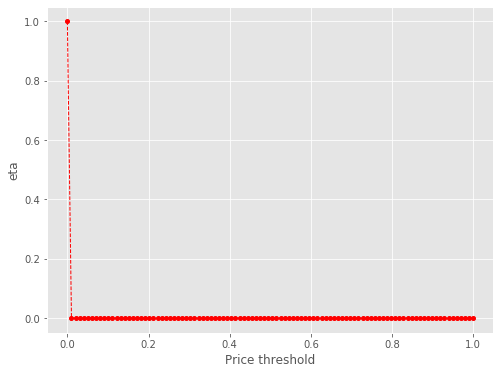

957 2
Number of cells with price above 97.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

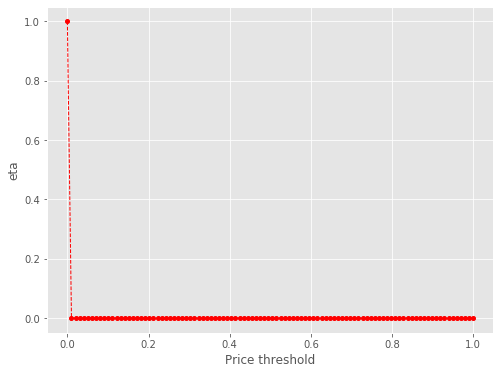

957 1
Number of cells with price above 98.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



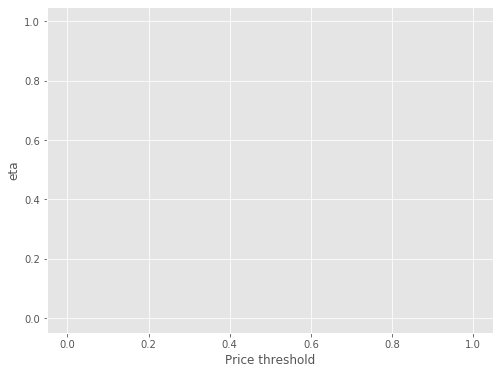

957 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

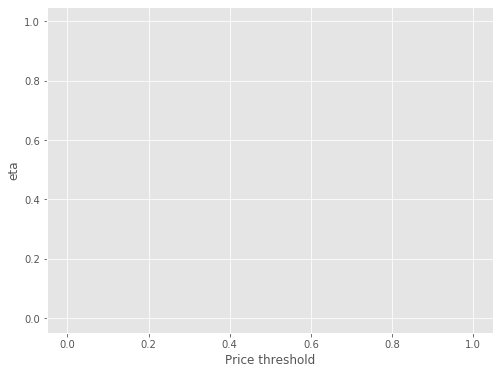

957 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

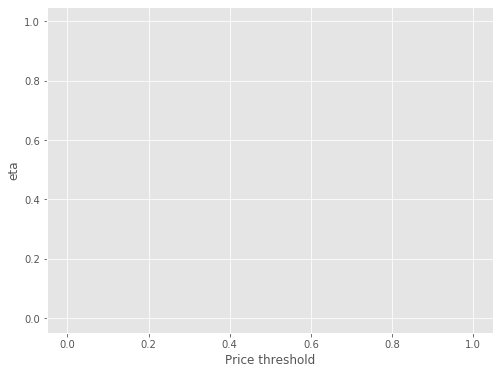


time: 1min 16s


In [27]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

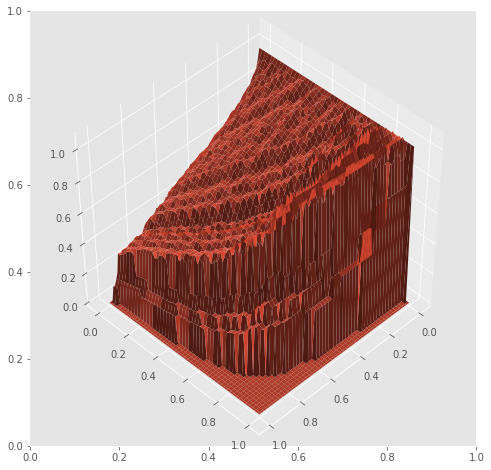

time: 1.08 s


In [28]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [29]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Dublin'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96708982, 0.94781127, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 32.7 ms


957 233
Number of cells with price above 5th percentile:  233
total number of cells:  957
number of cells within urban airbnb territory:  233



Mean travel times in minutes:  11.236571614583333
Mean travel times in minutes:  18.245795572916666
Mean travel times in minutes:  23.732350327765808


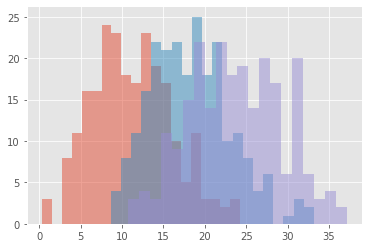

time: 24.2 s


In [30]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.09*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.09*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.2)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

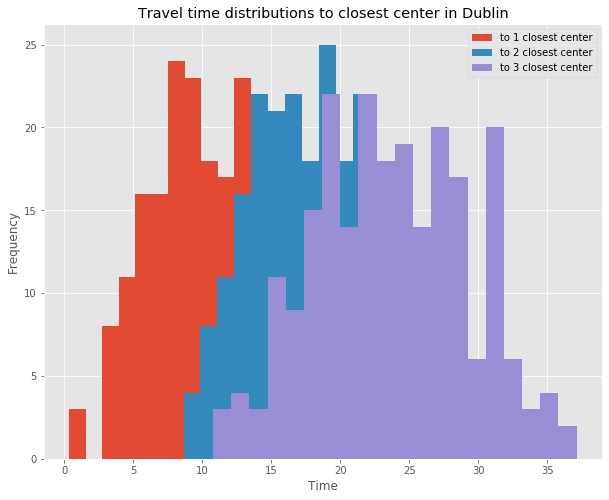

time: 417 ms


In [31]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Dublin')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [32]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Dublin'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 886 ms


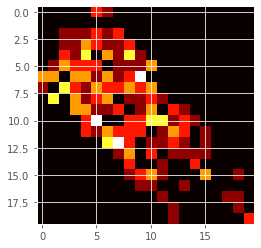

time: 180 ms


In [33]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [34]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.737422451109326
0.7986125546548525
1.1093694217496641
2.7208575177633882
0.9524701765114418
2.7893997901724665
average mutual information =  1.8513553186601897
time: 21 ms


In [35]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Dublin'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.629373608642793,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.9300969123092464,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9957279038792954,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.8513553186601897,
 'Boston': 1.1451275682586615,

time: 8 ms
